# Part 3 - Transfer Learning using Pretrained BERT Transformer

In Part 2, we tried to build a classfier by using TFIDF and BoW as feature extraction techniques. In this part, we will try directly adopting a pretrained BERT transformer model and add a FC MLP after the transformer model for classification task. The flow of this Jupyter notebook is making reference to this [blog](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f) and customizations were made to accomodate the need of this project  

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import torch
# import torchtext
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import torch.optim as optim
from transformers import BertTokenizer
from transformers import BertModel, BertConfig
import time
import random



As in previous parts, the prepared data file csv is first loaded.

In [2]:
df = pd.read_csv('merged_emotions.csv', encoding="utf-8", index_col=0)
data_words = df['text'].values.tolist()
data_labels = df['merged_labels']


Next is splitting the datasets into training, testing and validation sets.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data_labels)
Y_labels = le.transform(data_labels)

# feature_vec_bow_no_stopws, feature_vec_tfidf_no_stopws, feature_vec_bow , feature_vec_tfidf

def CreateTrainTestValSet(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=8964)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=8964)
    X_Dict = {'train': X_train, 'test': X_test, 'val': X_val}
    Y_Dict = {'train': y_train, 'test': y_test, 'val': y_val}
    
    return X_Dict, Y_Dict

X, Y = CreateTrainTestValSet(data_words, Y_labels)

In [4]:
torch.manual_seed(4698)
random.seed(4698)
np.random.seed(4698)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)



cuda:0


Next we adopted a pretrained BERT mode with option "bert-base-uncased". There are different variants of pretrained BERT models for different application scenarios, for example, for the "base" option, there are also case-sensitive option "bert-base-cased". The subtle differences can be referred to [here](https://iq.opengenus.org/bert-cased-vs-bert-uncased/#:~:text=In%20BERT%20uncased%2C%20the%20text,cased%20takes%20in%20%22OpenGenus%22). We will try both "bert-base-uncased" and "bert-base-cased" to compare the performance.

The pretained BERT transformer layer is implemented in the BertClassifier which is a subclass of Torch module. After the BERT transformer layer, a dropout layer is applied to introduce regularization to avoid overfitting. The 'pooled_output' from the BERT transformer is used as input to the dropout layer. The 'pooled_output' is with fixed size 768 which is derived from the  classifier token (CLS) from the BERT layer ouput, and is used as input for subsequent classfication layer. A Linear layer with 768 input size and number of emotion classes as output size is then implemented for the classification task.

We also defined an 'OriginalEmotionDataset' for creating Dataloader objects for training and evaluation. We will pass a pretrained BERT tokenizer to the dataset, which serves the sames purpose in previous part to tokenize input sample text. The tokenizer output will be fed to the pretained BERT transformer, which expects the input embedding vector with max length up to 512. Since each text sample is with different length, it is required to pad to the same size for feeding to the BERT transformer, and the padding job can be done by specifying the 'padding' option of the tokenizer.

In [5]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5, bert_model='bert-base-uncased', isfulltrain=True):

        super(BertClassifier, self).__init__()

        self.bert_model = bert_model
        self.bert = BertModel.from_pretrained(bert_model)
        self.dropout = torch.nn.Dropout(dropout)
        # we have 14 emotion classes in output, with 768 input from CLS from Bert tokenizer
        self.linear = torch.nn.Linear(768, EMOTIONS_NUM)
        self.relu = torch.nn.ReLU()
        
        # freeze gradient if not full train
        if not isfulltrain:
            for param in self.bert.parameters():
                param.requires_grad_(False)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, 
                                     attention_mask=mask,
                                     return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        output_vec = self.relu(linear_output)

        return output_vec


# MAX_SEQ_LEN is estimated from the tokenizer output 
# MAX_SEQ_LEN = max([len(tokenizer(x)['input_ids']) for x in valid_iter[:][0]])
MAX_SEQ_LEN = 320
# MAX_SEQ_LEN = 512

BATCH_SIZE = 10

# Number of output in the emotion classification
EMOTIONS_NUM = 14

class OriginalEmotionDataset(Dataset):

    def __init__(self, text_list, labels_list, tokenizer):
       
        self.tokenizer = tokenizer
        self.text_list = []
        for text in text_list:
            token =  self.tokenizer(text, padding='max_length', 
                      max_length = MAX_SEQ_LEN, truncation=True,
                      return_tensors="pt")
            self.text_list.append(token)
            
        self.labels_list = labels_list
        
    def __len__(self):
        return len(self.text_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sampletext = self.text_list[idx]
        label = self.labels_list[idx]
        
        return sampletext, label

In [6]:
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Evaluation Function
def EvalBertNN(model, testlder, modelfilename):

    if (device.type=='cuda'):
        model.to(device)
        model = model.cuda()
    
    if modelfilename is not None:
        ret =model.load_state_dict(torch.load(modelfilename))
        print(f'Loaded {modelfilename} for evaluation. Loading return {ret}')
        
    if (device.type=='cuda'):
        model.to(device)
        model = model.cuda()
        
    model.eval()
    model.train(False)
        
    y_target = []
    y_pred = []
    
    total_accuracy = []
    total_test_samples = 0
    with torch.no_grad():

        for test_input, test_label in testlder:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask)
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_accuracy.append(acc)
            total_test_samples += len(test_label)
            
            y_target.extend(test_label.data.cpu().numpy().astype(int))
            y_pred.extend(output.argmax(dim=1).data.cpu().numpy().astype(int))
            
            
    print(f'Test Accuracy: {sum(total_accuracy) / total_test_samples: .3f}')
    return sum(total_accuracy) / total_test_samples, y_target, y_pred

# function to generate confusion matrix display and classification report
def GenerateReports(y_true, y_pred, classlabels, figtitle):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                                   xticks_rotation='vertical', 
                                                   display_labels=classlabels,
                                                   ax=ax)

    disp.ax_.set_title('Confusion Matrix: ' + figtitle)
    # disp.plot(ax=ax)
    disp.im_.colorbar.remove()

    print('Classificaton Report: ' + figtitle)
    print(classification_report(y_true, y_pred))

In [7]:
# Training function 
SAVE_FOLDER = '/scratch/sk02039/'

def TrainBertNN(model, trnldr, valldr, learning_rate, checkpoint_modelfilename, output_modelfilename, epochs):

    if (device.type=='cuda'):
         model.to(device)
        
    loss_func = nn.CrossEntropyLoss()
    
     # What optimiser to use, e.g. SGD or Rprop or Adam
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.02) #lr = learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #lr = learning rate

    if (device.type=='cuda'):
            model = model.cuda()
            loss_func = loss_func.cuda()
            
    if checkpoint_modelfilename != None:
        print(f'Load checkfile file {checkpoint_modelfilename}')
        model.load_state_dict(torch.load(checkpoint_modelfilename))
    else:
        print('Perform a fresh training..')

    loss_values = []
    eval_acc = []
    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            loss_values_per_batch = []
            
            model.train(True)
            
            start_time = time.time()
            
            i = 0
            for train_input, train_label in trnldr:
#             for train_input, train_label in tqdm(trnldr):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                batch_loss = loss_func(output, train_label.long())
                
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
                loss_values_per_batch.append(batch_loss.item()) # keep track of loss values for later plot
                
                i += 1
                if i%20==0:
                    print(f'Completed {i} batch. Batch train Loss = {batch_loss.item()}')
            
            #Evaluate the epoch result 
            fname = SAVE_FOLDER + output_modelfilename + '_temp.pkl'
            torch.save(model.state_dict(), fname)  # save
            model_eval = BertClassifier(dropout=0.5, bert_model=model.bert_model)
            acc, *_ = EvalBertNN(model_eval, valldr, fname)
            
            # Only save the model for max eval accuracy so far
            if len(eval_acc)>0 and acc>max(eval_acc):
#                 fname = SAVE_FOLDER + output_modelfilename + '_' + str(epoch_num+1) + 'epochs.pkl'
                fname = SAVE_FOLDER + output_modelfilename + '.pkl'
                torch.save(model.state_dict(), fname)  # save
            eval_acc.append(acc)
            
            end_time = time.time()
            training_time = round(end_time - start_time)

            loss_values.append(sum(loss_values_per_batch)/len(loss_values_per_batch))
            print(f'***Completed epoch {epoch_num}. Average train Loss = {loss_values[-1]}. Time taken {training_time} sec.') 
            
            
    fname = SAVE_FOLDER + output_modelfilename + '_' + str(epochs) + 'epochs_trainloss.txt'
    with open(fname, 'w') as fp:
        for item in loss_values:
            fp.write("%s\n" % item)
            
    fname = SAVE_FOLDER + output_modelfilename + '_' + str(epochs) + 'epochs_evalacc.txt'
    with open(fname, 'w') as fp:
        for item in eval_acc:
            fp.write("%s\n" % item)
    
    
    return loss_values, eval_acc

Next, we create a loop with two options of BERT transformer, 'bert-base-uncased' and 'bert-base-cased'. Then, perform training and evaluation for 10 epochs to fine tune the BERT transformer.

In [11]:
LR = 1e-6
EPOCHS = 8

bert_pretrained_models = ['bert-base-uncased', 'bert-base-cased']
train_mode = ['full','finetune']

In [ ]:

train_loss = []
val_acc = []
# Training loop to try different options in the pretrained model
for option in bert_pretrained_models:
    
    mytokenizer = BertTokenizer.from_pretrained(option)
    
    train_iter = OriginalEmotionDataset(X['train'], Y['train'], mytokenizer)

    valid_iter = OriginalEmotionDataset(X['val'], Y['val'], mytokenizer)

    train_loader = torch.utils.data.DataLoader(train_iter, batch_size=BATCH_SIZE,
                                                shuffle=False, num_workers=0)

    valid_loader = torch.utils.data.DataLoader(valid_iter, batch_size=BATCH_SIZE,
                                                shuffle=False, num_workers=0)
    
    for mode in train_mode:
        model = BertClassifier(dropout=0.5, bert_model=option, isfulltrain = (mode=='full'))

        output_modelfilename = option + '-' + mode

        loss, evl = TrainBertNN(model = model, 
                                trnldr = train_loader,
                                valldr = valid_loader,
                                learning_rate = LR, 
                                checkpoint_modelfilename = None,
                                output_modelfilename = output_modelfilename, 
                                epochs = EPOCHS)
        train_loss.append(loss)
        val_acc.append(evl)
    
    # Save the tokenizer to future eval
#     mytokenizer.save_pretrained(SAVE_FOLDER + option + '_tokenizer')
    

In [14]:
# function to generate confusion matrix display and classification report
def GenerateReports(y_true, y_pred, classlabels, figtitle):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, 
                                                   xticks_rotation='vertical', 
                                                   display_labels=classlabels,
                                                   ax=ax)

    disp.ax_.set_title('Confusion Matrix: ' + figtitle)
    # disp.plot(ax=ax)
    disp.im_.colorbar.remove()

    print('Classificaton Report: ' + figtitle)
    print(classification_report(y_true, y_pred))
    
    
# function to plot training and evaluation results
def PlotTwinResults(ax, x_data, y_datas, x_label, y_labels, fig_title):
    ax.plot(range(0,len(x_data)),y_datas[0], color='r')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_labels[0], color='r')
    ax2 = ax.twinx()
    ax2.plot(range(0,len(x_data)),y_datas[1], color='b')
    ax2.set_ylabel(y_labels[1], color='b')
    ax.set_title(fig_title)

### Plot the change in training loss and the validation accuracy

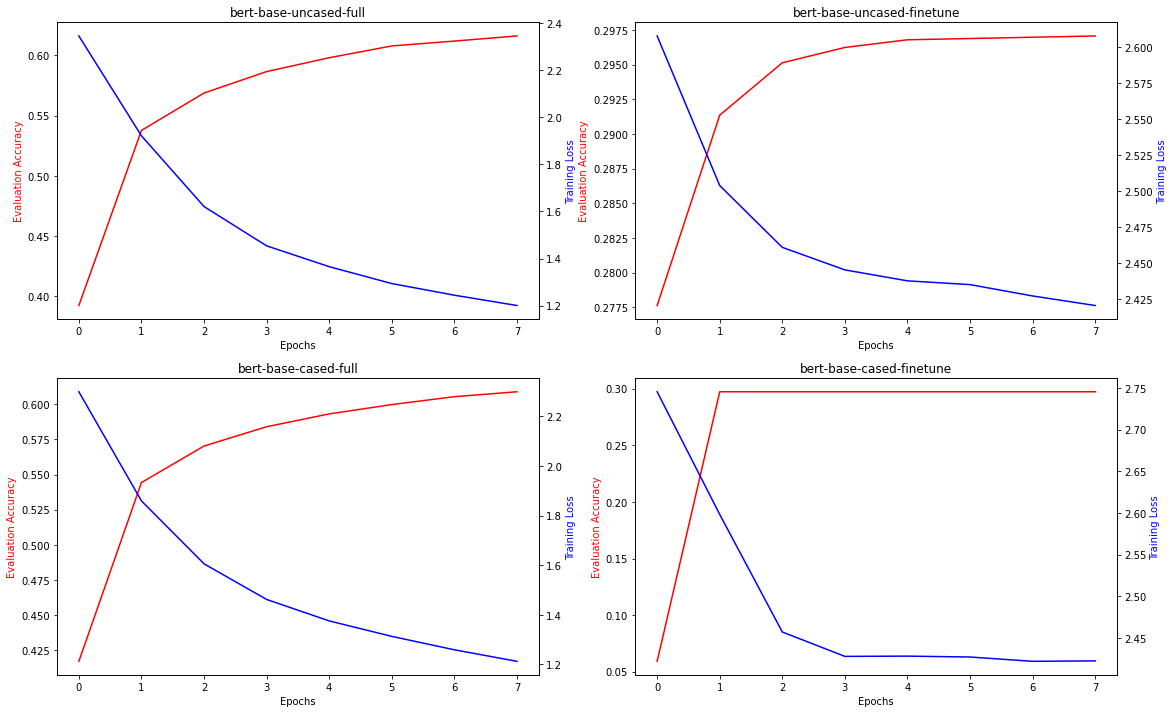

In [14]:
# train_loss, val_acc
# bert_pretrained_models = ['bert-base-uncased', 'bert-base-cased']
# train_mode = ['full','finetune']

fig, ax = plt.subplots(2,2,figsize=(19,12))

k = 0
for i in range(2):
    for j in range(2):
        figtitle = bert_pretrained_models[i] + '-' + train_mode[j]
        PlotTwinResults(ax[i,j], range(0,len(train_loss[0])), 
                            [val_acc[k], train_loss[k]], 
                            'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                            figtitle)
        k+=1


### Confusion matrix and classification report

In [ ]:
for option in bert_pretrained_models:
    
    mytokenizer = BertTokenizer.from_pretrained(option)
    
    test_iter = OriginalEmotionDataset(X['test'], Y['test'], mytokenizer)
   
    test_loader = torch.utils.data.DataLoader(test_iter, batch_size=BATCH_SIZE,
                                                shuffle=False, num_workers=0)
    
    for mode in train_mode:
        model = BertClassifier(dropout=0.5, bert_model=option, isfulltrain = (mode=='full'))

        output_modelfilename = option + '-' + mode

        model_eval = BertClassifier(dropout=0.5, bert_model=model.bert_model)
        fname = SAVE_FOLDER + output_modelfilename + '_' + str(EPOCHS) + 'epochs.pkl'
        acc, y_target, y_pred = EvalBertNN(model_eval, test_loader, fname)
        
        y_target = le.inverse_transform(y_target)
        y_pred = le.inverse_transform(y_pred)

        GenerateReports(y_target, y_pred, le.classes_, output_modelfilename)
            
            
        

### Next we try to vary the training rate and batch size to observe the effect on accuracy

In [8]:
EPOCHS = 10

option = 'bert-base-uncased'
mode = 'full'

learing_rate = {1: 1e-6, 2: 1e-5, 3: 1e-4}
batch_size = [10,5,1]

mytokenizer = BertTokenizer.from_pretrained(option)
    
train_iter = OriginalEmotionDataset(X['train'], Y['train'], mytokenizer)
valid_iter = OriginalEmotionDataset(X['val'], Y['val'], mytokenizer)
    
train_loss = []
val_acc = []
# Training loop to try different options in the pretrained model
for i, lr in learing_rate.items():
    for bs in batch_size:
        print(bs)
        print(lr)
        
        train_loader = torch.utils.data.DataLoader(train_iter, batch_size=bs,
                                                    shuffle=False, num_workers=0)

        valid_loader = torch.utils.data.DataLoader(valid_iter, batch_size=bs,
                                                    shuffle=False, num_workers=0)

   
        model = BertClassifier(dropout=0.5, bert_model=option, isfulltrain = (mode=='full'))

        output_modelfilename = 'batch' + str(bs) + '-lr' + str(i)  

        loss, evl = TrainBertNN(model = model, 
                                trnldr = train_loader,
                                valldr = valid_loader,
                                learning_rate = lr, 
                                checkpoint_modelfilename = None,
                                output_modelfilename = output_modelfilename, 
                                epochs = EPOCHS)
        train_loss.append(loss)
        val_acc.append(evl)
    

10
1e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform a fresh training..
Completed 20 batch. Batch train Loss = 2.3157591819763184
Completed 40 batch. Batch train Loss = 2.341853618621826
Completed 60 batch. Batch train Loss = 2.3212664127349854
Completed 80 batch. Batch train Loss = 2.515902042388916
Completed 100 batch. Batch train Loss = 2.6713500022888184
Completed 120 batch. Batch train Loss = 2.847358226776123
Completed 140 batch. Batch train Loss = 2.3559317588806152
Completed 160 batch. Batch train Loss = 2.494356155395508
Completed 180 batch. Batch train Loss = 2.1049132347106934
Completed 200 batch. Batch train Loss = 2.589216470718384
Completed 220 batch. Batch train Loss = 2.2787539958953857
Completed 240 batch. Batch train Loss = 2.051943063735962
Completed 260 batch. Batch train Loss = 2.294276237487793
Completed 280 batch. Batch train Loss = 2.4016172885894775
Completed 300 batch. Batch train Loss = 2.088557004928589
Completed 320 batch. Batch train Loss = 2.5523457527160645
Completed 340 batch. Batch train Loss = 2

Completed 2780 batch. Batch train Loss = 1.0363333225250244
Completed 2800 batch. Batch train Loss = 1.5369220972061157
Completed 2820 batch. Batch train Loss = 0.6528972387313843
Completed 2840 batch. Batch train Loss = 1.1571640968322754
Completed 2860 batch. Batch train Loss = 0.8260394334793091
Completed 2880 batch. Batch train Loss = 1.167995810508728
Completed 2900 batch. Batch train Loss = 1.500796914100647
Completed 2920 batch. Batch train Loss = 2.072436571121216
Completed 2940 batch. Batch train Loss = 1.495971441268921
Completed 2960 batch. Batch train Loss = 1.5387341976165771
Completed 2980 batch. Batch train Loss = 1.9447362422943115
Completed 3000 batch. Batch train Loss = 0.9633649587631226
Completed 3020 batch. Batch train Loss = 1.5325515270233154
Completed 3040 batch. Batch train Loss = 1.5147724151611328
Completed 3060 batch. Batch train Loss = 1.1222178936004639
Completed 3080 batch. Batch train Loss = 1.2669265270233154
Completed 3100 batch. Batch train Loss = 0.7

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.613
***Completed epoch 0. Average train Loss = 1.5889883570794099. Time taken 2629 sec.
Completed 20 batch. Batch train Loss = 1.2604953050613403
Completed 40 batch. Batch train Loss = 1.3411448001861572
Completed 60 batch. Batch train Loss = 1.7295444011688232
Completed 80 batch. Batch train Loss = 0.9157530069351196
Completed 100 batch. Batch train Loss = 1.3618800640106201
Completed 120 batch. Batch train Loss = 1.1440117359161377
Completed 140 batch. Batch train Loss = 1.074798345565796
Completed 160 batch. Batch train Loss = 0.9865633845329285
Completed 180 batch. Batch train Loss = 1.3605191707611084
Completed 200 batch. Batch train Loss = 1.8126230239868164
Completed 220 batch. Batch train Loss = 1.4209849834442139
Completed 240 batch. Batch train Loss = 0.3975568413734436
Completed 260 batch. Batch train Loss = 1.1049048900604248
Completed 280 batch. Bat

Completed 2720 batch. Batch train Loss = 1.0240341424942017
Completed 2740 batch. Batch train Loss = 1.3512895107269287
Completed 2760 batch. Batch train Loss = 0.79505455493927
Completed 2780 batch. Batch train Loss = 1.0444267988204956
Completed 2800 batch. Batch train Loss = 1.2686042785644531
Completed 2820 batch. Batch train Loss = 0.6662127375602722
Completed 2840 batch. Batch train Loss = 0.7817872166633606
Completed 2860 batch. Batch train Loss = 0.6840980648994446
Completed 2880 batch. Batch train Loss = 0.8945554494857788
Completed 2900 batch. Batch train Loss = 1.1731364727020264
Completed 2920 batch. Batch train Loss = 1.9485013484954834
Completed 2940 batch. Batch train Loss = 0.9591017961502075
Completed 2960 batch. Batch train Loss = 1.1385217905044556
Completed 2980 batch. Batch train Loss = 1.9074122905731201
Completed 3000 batch. Batch train Loss = 0.6561418175697327
Completed 3020 batch. Batch train Loss = 1.253607153892517
Completed 3040 batch. Batch train Loss = 1.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.615
***Completed epoch 1. Average train Loss = 1.144649323236188. Time taken 2685 sec.
Completed 20 batch. Batch train Loss = 1.2768198251724243
Completed 40 batch. Batch train Loss = 1.3481589555740356
Completed 60 batch. Batch train Loss = 1.1576305627822876
Completed 80 batch. Batch train Loss = 1.3852218389511108
Completed 100 batch. Batch train Loss = 1.3003830909729004
Completed 120 batch. Batch train Loss = 1.0914127826690674
Completed 140 batch. Batch train Loss = 0.9109792709350586
Completed 160 batch. Batch train Loss = 0.6528022885322571
Completed 180 batch. Batch train Loss = 1.1257975101470947
Completed 200 batch. Batch train Loss = 1.466679334640503
Completed 220 batch. Batch train Loss = 1.3077583312988281
Completed 240 batch. Batch train Loss = 0.425301730632782
Completed 260 batch. Batch train Loss = 0.9619051218032837
Completed 280 batch. Batch

Completed 2720 batch. Batch train Loss = 0.6234170198440552
Completed 2740 batch. Batch train Loss = 0.9850550889968872
Completed 2760 batch. Batch train Loss = 0.9084827303886414
Completed 2780 batch. Batch train Loss = 0.6796689033508301
Completed 2800 batch. Batch train Loss = 1.0934431552886963
Completed 2820 batch. Batch train Loss = 0.6380091309547424
Completed 2840 batch. Batch train Loss = 0.3947947323322296
Completed 2860 batch. Batch train Loss = 0.4324476718902588
Completed 2880 batch. Batch train Loss = 0.5678569674491882
Completed 2900 batch. Batch train Loss = 0.9264276623725891
Completed 2920 batch. Batch train Loss = 1.5266807079315186
Completed 2940 batch. Batch train Loss = 0.5800774097442627
Completed 2960 batch. Batch train Loss = 1.5380423069000244
Completed 2980 batch. Batch train Loss = 1.9627889394760132
Completed 3000 batch. Batch train Loss = 0.5453848242759705
Completed 3020 batch. Batch train Loss = 0.8697697520256042
Completed 3040 batch. Batch train Loss =

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.607
***Completed epoch 2. Average train Loss = 0.9368959922910981. Time taken 2677 sec.
Completed 20 batch. Batch train Loss = 1.4260329008102417
Completed 40 batch. Batch train Loss = 1.4057255983352661
Completed 60 batch. Batch train Loss = 0.889955997467041
Completed 80 batch. Batch train Loss = 1.2826526165008545
Completed 100 batch. Batch train Loss = 0.9569522142410278
Completed 120 batch. Batch train Loss = 0.31950318813323975
Completed 140 batch. Batch train Loss = 0.8323217630386353
Completed 160 batch. Batch train Loss = 0.5276349186897278
Completed 180 batch. Batch train Loss = 1.124964952468872
Completed 200 batch. Batch train Loss = 1.0361230373382568
Completed 220 batch. Batch train Loss = 0.9228876829147339
Completed 240 batch. Batch train Loss = 0.31698551774024963
Completed 260 batch. Batch train Loss = 0.8600362539291382
Completed 280 batch. Ba

Completed 2720 batch. Batch train Loss = 0.36651208996772766
Completed 2740 batch. Batch train Loss = 0.7605448961257935
Completed 2760 batch. Batch train Loss = 0.8278840780258179
Completed 2780 batch. Batch train Loss = 0.4398820996284485
Completed 2800 batch. Batch train Loss = 0.4838886260986328
Completed 2820 batch. Batch train Loss = 0.31307241320610046
Completed 2840 batch. Batch train Loss = 0.2735503613948822
Completed 2860 batch. Batch train Loss = 0.27482691407203674
Completed 2880 batch. Batch train Loss = 0.27957865595817566
Completed 2900 batch. Batch train Loss = 0.724696934223175
Completed 2920 batch. Batch train Loss = 1.5699374675750732
Completed 2940 batch. Batch train Loss = 0.2468431293964386
Completed 2960 batch. Batch train Loss = 1.065758466720581
Completed 2980 batch. Batch train Loss = 2.0375633239746094
Completed 3000 batch. Batch train Loss = 0.37766924500465393
Completed 3020 batch. Batch train Loss = 0.4861451983451843
Completed 3040 batch. Batch train Los

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.593
***Completed epoch 3. Average train Loss = 0.726998289456678. Time taken 2672 sec.
Completed 20 batch. Batch train Loss = 0.6306238174438477
Completed 40 batch. Batch train Loss = 1.0894044637680054
Completed 60 batch. Batch train Loss = 0.4450991749763489
Completed 80 batch. Batch train Loss = 1.1772381067276
Completed 100 batch. Batch train Loss = 0.7520356774330139
Completed 120 batch. Batch train Loss = 0.42570096254348755
Completed 140 batch. Batch train Loss = 0.949007511138916
Completed 160 batch. Batch train Loss = 0.39714211225509644
Completed 180 batch. Batch train Loss = 0.6032522320747375
Completed 200 batch. Batch train Loss = 0.8321482539176941
Completed 220 batch. Batch train Loss = 0.5140582323074341
Completed 240 batch. Batch train Loss = 0.29574069380760193
Completed 260 batch. Batch train Loss = 0.5782543420791626
Completed 280 batch. Batc

Completed 2700 batch. Batch train Loss = 0.7253080606460571
Completed 2720 batch. Batch train Loss = 0.22581379115581512
Completed 2740 batch. Batch train Loss = 0.49392715096473694
Completed 2760 batch. Batch train Loss = 0.5296661853790283
Completed 2780 batch. Batch train Loss = 0.324506551027298
Completed 2800 batch. Batch train Loss = 0.4431063234806061
Completed 2820 batch. Batch train Loss = 0.24675121903419495
Completed 2840 batch. Batch train Loss = 0.11923865973949432
Completed 2860 batch. Batch train Loss = 0.18388120830059052
Completed 2880 batch. Batch train Loss = 0.15765847265720367
Completed 2900 batch. Batch train Loss = 0.17269140481948853
Completed 2920 batch. Batch train Loss = 1.6725842952728271
Completed 2940 batch. Batch train Loss = 0.21389397978782654
Completed 2960 batch. Batch train Loss = 0.9620275497436523
Completed 2980 batch. Batch train Loss = 2.099247932434082
Completed 3000 batch. Batch train Loss = 0.2682724893093109
Completed 3020 batch. Batch train 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.583
***Completed epoch 4. Average train Loss = 0.545639438488285. Time taken 2665 sec.
Completed 20 batch. Batch train Loss = 0.7669183015823364
Completed 40 batch. Batch train Loss = 0.8552797436714172
Completed 60 batch. Batch train Loss = 0.20817475020885468
Completed 80 batch. Batch train Loss = 0.6488679647445679
Completed 100 batch. Batch train Loss = 0.6537481546401978
Completed 120 batch. Batch train Loss = 0.12483279407024384
Completed 140 batch. Batch train Loss = 1.0038599967956543
Completed 160 batch. Batch train Loss = 0.15804816782474518
Completed 180 batch. Batch train Loss = 0.5646178722381592
Completed 200 batch. Batch train Loss = 0.5915974974632263
Completed 220 batch. Batch train Loss = 0.4468221664428711
Completed 240 batch. Batch train Loss = 0.0840785875916481
Completed 260 batch. Batch train Loss = 0.47380590438842773
Completed 280 batch.

Completed 2700 batch. Batch train Loss = 0.4583183825016022
Completed 2720 batch. Batch train Loss = 0.36447224020957947
Completed 2740 batch. Batch train Loss = 0.11827011406421661
Completed 2760 batch. Batch train Loss = 0.16661745309829712
Completed 2780 batch. Batch train Loss = 0.12247129529714584
Completed 2800 batch. Batch train Loss = 0.164011150598526
Completed 2820 batch. Batch train Loss = 0.21961593627929688
Completed 2840 batch. Batch train Loss = 0.16412119567394257
Completed 2860 batch. Batch train Loss = 0.057103145867586136
Completed 2880 batch. Batch train Loss = 0.03504272550344467
Completed 2900 batch. Batch train Loss = 0.4912583827972412
Completed 2920 batch. Batch train Loss = 1.3083678483963013
Completed 2940 batch. Batch train Loss = 0.05789744853973389
Completed 2960 batch. Batch train Loss = 0.607508659362793
Completed 2980 batch. Batch train Loss = 2.0419676303863525
Completed 3000 batch. Batch train Loss = 0.1365061104297638
Completed 3020 batch. Batch trai

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.576
***Completed epoch 5. Average train Loss = 0.38213883881189425. Time taken 2660 sec.
Completed 20 batch. Batch train Loss = 0.06227967143058777
Completed 40 batch. Batch train Loss = 0.43954524397850037
Completed 60 batch. Batch train Loss = 0.14052967727184296
Completed 80 batch. Batch train Loss = 0.5216039419174194
Completed 100 batch. Batch train Loss = 0.6395537853240967
Completed 120 batch. Batch train Loss = 0.13914813101291656
Completed 140 batch. Batch train Loss = 0.8212031126022339
Completed 160 batch. Batch train Loss = 0.06492116302251816
Completed 180 batch. Batch train Loss = 0.10095808655023575
Completed 200 batch. Batch train Loss = 0.6064276695251465
Completed 220 batch. Batch train Loss = 0.28164151310920715
Completed 240 batch. Batch train Loss = 0.17123040556907654
Completed 260 batch. Batch train Loss = 0.5921408534049988
Completed 280 

Completed 2680 batch. Batch train Loss = 0.7498723864555359
Completed 2700 batch. Batch train Loss = 0.6410295367240906
Completed 2720 batch. Batch train Loss = 0.04267570376396179
Completed 2740 batch. Batch train Loss = 0.1087585911154747
Completed 2760 batch. Batch train Loss = 0.08886238187551498
Completed 2780 batch. Batch train Loss = 0.20780885219573975
Completed 2800 batch. Batch train Loss = 0.07104843109846115
Completed 2820 batch. Batch train Loss = 0.025541026145219803
Completed 2840 batch. Batch train Loss = 0.06421080976724625
Completed 2860 batch. Batch train Loss = 0.05396808311343193
Completed 2880 batch. Batch train Loss = 0.0298679918050766
Completed 2900 batch. Batch train Loss = 0.18784424662590027
Completed 2920 batch. Batch train Loss = 1.2444391250610352
Completed 2940 batch. Batch train Loss = 0.12265773862600327
Completed 2960 batch. Batch train Loss = 0.058419324457645416
Completed 2980 batch. Batch train Loss = 1.6261367797851562
Completed 3000 batch. Batch 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.568
***Completed epoch 6. Average train Loss = 0.2807259333788484. Time taken 2669 sec.
Completed 20 batch. Batch train Loss = 0.021969251334667206
Completed 40 batch. Batch train Loss = 0.050313062965869904
Completed 60 batch. Batch train Loss = 0.031806398183107376
Completed 80 batch. Batch train Loss = 0.48646217584609985
Completed 100 batch. Batch train Loss = 0.6838196516036987
Completed 120 batch. Batch train Loss = 0.09504272788763046
Completed 140 batch. Batch train Loss = 0.25740090012550354
Completed 160 batch. Batch train Loss = 0.06525959819555283
Completed 180 batch. Batch train Loss = 0.1675683706998825
Completed 200 batch. Batch train Loss = 0.25295311212539673
Completed 220 batch. Batch train Loss = 0.2698115408420563
Completed 240 batch. Batch train Loss = 0.05089582875370979
Completed 260 batch. Batch train Loss = 0.18049368262290955
Completed 

Completed 2680 batch. Batch train Loss = 0.7328569889068604
Completed 2700 batch. Batch train Loss = 0.4278314709663391
Completed 2720 batch. Batch train Loss = 0.01623436063528061
Completed 2740 batch. Batch train Loss = 0.0878424420952797
Completed 2760 batch. Batch train Loss = 0.06751352548599243
Completed 2780 batch. Batch train Loss = 0.08250883221626282
Completed 2800 batch. Batch train Loss = 0.2487049400806427
Completed 2820 batch. Batch train Loss = 0.09241588413715363
Completed 2840 batch. Batch train Loss = 0.02580924890935421
Completed 2860 batch. Batch train Loss = 0.020079832524061203
Completed 2880 batch. Batch train Loss = 0.1317284107208252
Completed 2900 batch. Batch train Loss = 0.0642814189195633
Completed 2920 batch. Batch train Loss = 1.2847915887832642
Completed 2940 batch. Batch train Loss = 0.03183617442846298
Completed 2960 batch. Batch train Loss = 0.13538488745689392
Completed 2980 batch. Batch train Loss = 1.56960129737854
Completed 3000 batch. Batch train

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.579
***Completed epoch 7. Average train Loss = 0.2090903907276047. Time taken 2659 sec.
Completed 20 batch. Batch train Loss = 0.19220732152462006
Completed 40 batch. Batch train Loss = 0.051732778549194336
Completed 60 batch. Batch train Loss = 0.12386797368526459
Completed 80 batch. Batch train Loss = 0.16194447875022888
Completed 100 batch. Batch train Loss = 0.5584608316421509
Completed 120 batch. Batch train Loss = 0.04191311076283455
Completed 140 batch. Batch train Loss = 0.35474658012390137
Completed 160 batch. Batch train Loss = 0.014323471114039421
Completed 180 batch. Batch train Loss = 0.05365193635225296
Completed 200 batch. Batch train Loss = 0.047124799340963364
Completed 220 batch. Batch train Loss = 0.13169391453266144
Completed 240 batch. Batch train Loss = 0.0536760613322258
Completed 260 batch. Batch train Loss = 0.1501893401145935
Completed 

Completed 2660 batch. Batch train Loss = 0.06546511501073837
Completed 2680 batch. Batch train Loss = 0.6158962845802307
Completed 2700 batch. Batch train Loss = 0.4898715019226074
Completed 2720 batch. Batch train Loss = 0.04156596213579178
Completed 2740 batch. Batch train Loss = 0.028263410553336143
Completed 2760 batch. Batch train Loss = 0.04734538495540619
Completed 2780 batch. Batch train Loss = 0.01975656859576702
Completed 2800 batch. Batch train Loss = 0.01227417029440403
Completed 2820 batch. Batch train Loss = 0.07408543676137924
Completed 2840 batch. Batch train Loss = 0.0350138358771801
Completed 2860 batch. Batch train Loss = 0.007961641065776348
Completed 2880 batch. Batch train Loss = 0.02215982787311077
Completed 2900 batch. Batch train Loss = 0.12633346021175385
Completed 2920 batch. Batch train Loss = 1.0729484558105469
Completed 2940 batch. Batch train Loss = 0.014600199647247791
Completed 2960 batch. Batch train Loss = 0.08720587193965912
Completed 2980 batch. Bat

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.575
***Completed epoch 8. Average train Loss = 0.16727124977440982. Time taken 2658 sec.
Completed 20 batch. Batch train Loss = 0.0400460921227932
Completed 40 batch. Batch train Loss = 0.02257542498409748
Completed 60 batch. Batch train Loss = 0.11998055875301361
Completed 80 batch. Batch train Loss = 0.4398375451564789
Completed 100 batch. Batch train Loss = 0.6527014374732971
Completed 120 batch. Batch train Loss = 0.052468519657850266
Completed 140 batch. Batch train Loss = 0.3144991993904114
Completed 160 batch. Batch train Loss = 0.020026961341500282
Completed 180 batch. Batch train Loss = 0.01953086443245411
Completed 200 batch. Batch train Loss = 0.22142919898033142
Completed 220 batch. Batch train Loss = 0.12180055677890778
Completed 240 batch. Batch train Loss = 0.016650209203362465
Completed 260 batch. Batch train Loss = 0.3782382309436798
Completed 2

Completed 2660 batch. Batch train Loss = 0.014909429475665092
Completed 2680 batch. Batch train Loss = 0.6489515900611877
Completed 2700 batch. Batch train Loss = 0.38353508710861206
Completed 2720 batch. Batch train Loss = 0.01911883056163788
Completed 2740 batch. Batch train Loss = 0.009166964329779148
Completed 2760 batch. Batch train Loss = 0.01676848530769348
Completed 2780 batch. Batch train Loss = 0.014227332547307014
Completed 2800 batch. Batch train Loss = 0.022691713646054268
Completed 2820 batch. Batch train Loss = 0.015209285542368889
Completed 2840 batch. Batch train Loss = 0.025904003530740738
Completed 2860 batch. Batch train Loss = 0.009570818394422531
Completed 2880 batch. Batch train Loss = 0.007613231893628836
Completed 2900 batch. Batch train Loss = 0.018421463668346405
Completed 2920 batch. Batch train Loss = 0.8105939030647278
Completed 2940 batch. Batch train Loss = 0.017446914687752724
Completed 2960 batch. Batch train Loss = 0.14038841426372528
Completed 2980 b

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.551
***Completed epoch 9. Average train Loss = 0.13590108235851467. Time taken 2654 sec.
5
1e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform a fresh training..
Completed 20 batch. Batch train Loss = 2.6350255012512207
Completed 40 batch. Batch train Loss = 2.481513738632202
Completed 60 batch. Batch train Loss = 2.1669540405273438
Completed 80 batch. Batch train Loss = 2.0317704677581787
Completed 100 batch. Batch train Loss = 2.7956976890563965
Completed 120 batch. Batch train Loss = 2.937335968017578
Completed 140 batch. Batch train Loss = 2.5341808795928955
Completed 160 batch. Batch train Loss = 2.378406047821045
Completed 180 batch. Batch train Loss = 1.877907156944275
Completed 200 batch. Batch train Loss = 2.568441867828369
Completed 220 batch. Batch train Loss = 2.047666549682617
Completed 240 batch. Batch train Loss = 2.9157536029815674
Completed 260 batch. Batch train Loss = 2.13043475151062
Completed 280 batch. Batch train Loss = 2.193263530731201
Completed 300 batch. Batch train Loss = 2.0881285667419434
Completed 320 batch. Batch train Loss = 2.488640308380127
Completed 340 batch. Batch train Loss = 2.5

Completed 2780 batch. Batch train Loss = 1.935186743736267
Completed 2800 batch. Batch train Loss = 0.5932686924934387
Completed 2820 batch. Batch train Loss = 1.5487635135650635
Completed 2840 batch. Batch train Loss = 1.4029476642608643
Completed 2860 batch. Batch train Loss = 1.7790170907974243
Completed 2880 batch. Batch train Loss = 2.949796676635742
Completed 2900 batch. Batch train Loss = 1.5127545595169067
Completed 2920 batch. Batch train Loss = 0.7297211289405823
Completed 2940 batch. Batch train Loss = 1.3215526342391968
Completed 2960 batch. Batch train Loss = 1.0616562366485596
Completed 2980 batch. Batch train Loss = 1.2813256978988647
Completed 3000 batch. Batch train Loss = 1.9153766632080078
Completed 3020 batch. Batch train Loss = 0.9969255328178406
Completed 3040 batch. Batch train Loss = 1.950018286705017
Completed 3060 batch. Batch train Loss = 2.798722267150879
Completed 3080 batch. Batch train Loss = 2.4647438526153564
Completed 3100 batch. Batch train Loss = 2.2

Completed 5540 batch. Batch train Loss = 0.7374446392059326
Completed 5560 batch. Batch train Loss = 0.7395499348640442
Completed 5580 batch. Batch train Loss = 0.8708781003952026
Completed 5600 batch. Batch train Loss = 1.7576525211334229
Completed 5620 batch. Batch train Loss = 2.4097042083740234
Completed 5640 batch. Batch train Loss = 0.9292948842048645
Completed 5660 batch. Batch train Loss = 0.8740642666816711
Completed 5680 batch. Batch train Loss = 0.423920214176178
Completed 5700 batch. Batch train Loss = 1.655735731124878
Completed 5720 batch. Batch train Loss = 1.4666086435317993
Completed 5740 batch. Batch train Loss = 1.0310155153274536
Completed 5760 batch. Batch train Loss = 1.3206193447113037
Completed 5780 batch. Batch train Loss = 1.1265146732330322
Completed 5800 batch. Batch train Loss = 1.9662284851074219
Completed 5820 batch. Batch train Loss = 1.0937108993530273
Completed 5840 batch. Batch train Loss = 1.7137746810913086
Completed 5860 batch. Batch train Loss = 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.610
***Completed epoch 0. Average train Loss = 1.5304517680390095. Time taken 2797 sec.
Completed 20 batch. Batch train Loss = 1.2860372066497803
Completed 40 batch. Batch train Loss = 0.8179348111152649
Completed 60 batch. Batch train Loss = 0.6663137674331665
Completed 80 batch. Batch train Loss = 0.4452747404575348
Completed 100 batch. Batch train Loss = 2.123595952987671
Completed 120 batch. Batch train Loss = 2.136902332305908
Completed 140 batch. Batch train Loss = 0.3494912087917328
Completed 160 batch. Batch train Loss = 1.3335978984832764
Completed 180 batch. Batch train Loss = 1.5598945617675781
Completed 200 batch. Batch train Loss = 2.1338918209075928
Completed 220 batch. Batch train Loss = 2.0759661197662354
Completed 240 batch. Batch train Loss = 0.7417569160461426
Completed 260 batch. Batch train Loss = 1.8090360164642334
Completed 280 batch. Batch

Completed 2720 batch. Batch train Loss = 0.6296051740646362
Completed 2740 batch. Batch train Loss = 1.4350131750106812
Completed 2760 batch. Batch train Loss = 0.4327898919582367
Completed 2780 batch. Batch train Loss = 0.8506646156311035
Completed 2800 batch. Batch train Loss = 0.34047913551330566
Completed 2820 batch. Batch train Loss = 1.4139245748519897
Completed 2840 batch. Batch train Loss = 1.9752686023712158
Completed 2860 batch. Batch train Loss = 1.3961570262908936
Completed 2880 batch. Batch train Loss = 2.578432083129883
Completed 2900 batch. Batch train Loss = 1.5811097621917725
Completed 2920 batch. Batch train Loss = 0.6463049650192261
Completed 2940 batch. Batch train Loss = 0.6724246740341187
Completed 2960 batch. Batch train Loss = 0.8354846239089966
Completed 2980 batch. Batch train Loss = 1.0618129968643188
Completed 3000 batch. Batch train Loss = 1.6346118450164795
Completed 3020 batch. Batch train Loss = 0.41973233222961426
Completed 3040 batch. Batch train Loss 

Completed 5460 batch. Batch train Loss = 0.3222818076610565
Completed 5480 batch. Batch train Loss = 0.6597660183906555
Completed 5500 batch. Batch train Loss = 0.3046821653842926
Completed 5520 batch. Batch train Loss = 1.4777586460113525
Completed 5540 batch. Batch train Loss = 0.3130969703197479
Completed 5560 batch. Batch train Loss = 0.4645446240901947
Completed 5580 batch. Batch train Loss = 1.0225576162338257
Completed 5600 batch. Batch train Loss = 1.1663020849227905
Completed 5620 batch. Batch train Loss = 2.0912461280822754
Completed 5640 batch. Batch train Loss = 0.9152777791023254
Completed 5660 batch. Batch train Loss = 0.5285096764564514
Completed 5680 batch. Batch train Loss = 0.121890127658844
Completed 5700 batch. Batch train Loss = 2.0023207664489746
Completed 5720 batch. Batch train Loss = 0.7666287422180176
Completed 5740 batch. Batch train Loss = 0.7253854870796204
Completed 5760 batch. Batch train Loss = 1.0997941493988037
Completed 5780 batch. Batch train Loss = 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.612
***Completed epoch 1. Average train Loss = 1.1069908567271778. Time taken 2802 sec.
Completed 20 batch. Batch train Loss = 1.434349536895752
Completed 40 batch. Batch train Loss = 0.6317251324653625
Completed 60 batch. Batch train Loss = 0.38303837180137634
Completed 80 batch. Batch train Loss = 0.26629704236984253
Completed 100 batch. Batch train Loss = 2.0523695945739746
Completed 120 batch. Batch train Loss = 1.2967438697814941
Completed 140 batch. Batch train Loss = 0.26032915711402893
Completed 160 batch. Batch train Loss = 1.015176773071289
Completed 180 batch. Batch train Loss = 1.1061105728149414
Completed 200 batch. Batch train Loss = 1.8608064651489258
Completed 220 batch. Batch train Loss = 2.0579543113708496
Completed 240 batch. Batch train Loss = 0.412903368473053
Completed 260 batch. Batch train Loss = 1.8190233707427979
Completed 280 batch. Bat

Completed 2700 batch. Batch train Loss = 1.4159555435180664
Completed 2720 batch. Batch train Loss = 0.3250673711299896
Completed 2740 batch. Batch train Loss = 1.2341983318328857
Completed 2760 batch. Batch train Loss = 0.5505157113075256
Completed 2780 batch. Batch train Loss = 0.4891205430030823
Completed 2800 batch. Batch train Loss = 0.42317527532577515
Completed 2820 batch. Batch train Loss = 1.332100510597229
Completed 2840 batch. Batch train Loss = 1.4437793493270874
Completed 2860 batch. Batch train Loss = 0.900143027305603
Completed 2880 batch. Batch train Loss = 1.332725167274475
Completed 2900 batch. Batch train Loss = 1.071185827255249
Completed 2920 batch. Batch train Loss = 0.28567197918891907
Completed 2940 batch. Batch train Loss = 0.3499238193035126
Completed 2960 batch. Batch train Loss = 0.7871835827827454
Completed 2980 batch. Batch train Loss = 1.078153371810913
Completed 3000 batch. Batch train Loss = 1.6009842157363892
Completed 3020 batch. Batch train Loss = 0.

Completed 5440 batch. Batch train Loss = 0.49760374426841736
Completed 5460 batch. Batch train Loss = 0.29980093240737915
Completed 5480 batch. Batch train Loss = 0.8945128321647644
Completed 5500 batch. Batch train Loss = 0.14405906200408936
Completed 5520 batch. Batch train Loss = 0.6110522150993347
Completed 5540 batch. Batch train Loss = 0.815660297870636
Completed 5560 batch. Batch train Loss = 0.5317060947418213
Completed 5580 batch. Batch train Loss = 0.5637183785438538
Completed 5600 batch. Batch train Loss = 1.256351113319397
Completed 5620 batch. Batch train Loss = 2.1200430393218994
Completed 5640 batch. Batch train Loss = 0.5893949270248413
Completed 5660 batch. Batch train Loss = 0.4538930058479309
Completed 5680 batch. Batch train Loss = 0.08680407702922821
Completed 5700 batch. Batch train Loss = 1.9594917297363281
Completed 5720 batch. Batch train Loss = 0.6760778427124023
Completed 5740 batch. Batch train Loss = 0.22076058387756348
Completed 5760 batch. Batch train Los

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.596
***Completed epoch 2. Average train Loss = 0.8639825206794559. Time taken 2804 sec.
Completed 20 batch. Batch train Loss = 0.9428455233573914
Completed 40 batch. Batch train Loss = 0.3863619863986969
Completed 60 batch. Batch train Loss = 0.3478773832321167
Completed 80 batch. Batch train Loss = 0.32735511660575867
Completed 100 batch. Batch train Loss = 1.2811977863311768
Completed 120 batch. Batch train Loss = 1.345666766166687
Completed 140 batch. Batch train Loss = 0.18485751748085022
Completed 160 batch. Batch train Loss = 1.1773836612701416
Completed 180 batch. Batch train Loss = 0.36975687742233276
Completed 200 batch. Batch train Loss = 1.5715196132659912
Completed 220 batch. Batch train Loss = 2.129643201828003
Completed 240 batch. Batch train Loss = 0.5505026578903198
Completed 260 batch. Batch train Loss = 1.800143837928772
Completed 280 batch. Bat

Completed 2700 batch. Batch train Loss = 0.8400076031684875
Completed 2720 batch. Batch train Loss = 0.27208057045936584
Completed 2740 batch. Batch train Loss = 1.1969313621520996
Completed 2760 batch. Batch train Loss = 0.5714410543441772
Completed 2780 batch. Batch train Loss = 0.5085137486457825
Completed 2800 batch. Batch train Loss = 0.7723401784896851
Completed 2820 batch. Batch train Loss = 1.3498491048812866
Completed 2840 batch. Batch train Loss = 1.6749639511108398
Completed 2860 batch. Batch train Loss = 0.6686102151870728
Completed 2880 batch. Batch train Loss = 1.3176683187484741
Completed 2900 batch. Batch train Loss = 1.8371498584747314
Completed 2920 batch. Batch train Loss = 0.26395875215530396
Completed 2940 batch. Batch train Loss = 0.8169525265693665
Completed 2960 batch. Batch train Loss = 0.4890628457069397
Completed 2980 batch. Batch train Loss = 0.8519180417060852
Completed 3000 batch. Batch train Loss = 1.2438875436782837
Completed 3020 batch. Batch train Loss

Completed 5440 batch. Batch train Loss = 0.1475222259759903
Completed 5460 batch. Batch train Loss = 0.05138121172785759
Completed 5480 batch. Batch train Loss = 0.4714376926422119
Completed 5500 batch. Batch train Loss = 0.08755844831466675
Completed 5520 batch. Batch train Loss = 0.37082573771476746
Completed 5540 batch. Batch train Loss = 0.04883038252592087
Completed 5560 batch. Batch train Loss = 0.08882120996713638
Completed 5580 batch. Batch train Loss = 0.2796115577220917
Completed 5600 batch. Batch train Loss = 0.36771076917648315
Completed 5620 batch. Batch train Loss = 2.0387141704559326
Completed 5640 batch. Batch train Loss = 0.23949041962623596
Completed 5660 batch. Batch train Loss = 0.31347376108169556
Completed 5680 batch. Batch train Loss = 0.06712348759174347
Completed 5700 batch. Batch train Loss = 1.2687599658966064
Completed 5720 batch. Batch train Loss = 0.2371261566877365
Completed 5740 batch. Batch train Loss = 0.15829519927501678
Completed 5760 batch. Batch tr

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.570
***Completed epoch 3. Average train Loss = 0.6238553536193747. Time taken 2807 sec.
Completed 20 batch. Batch train Loss = 1.174847960472107
Completed 40 batch. Batch train Loss = 0.16653981804847717
Completed 60 batch. Batch train Loss = 0.447654664516449
Completed 80 batch. Batch train Loss = 0.19411307573318481
Completed 100 batch. Batch train Loss = 0.7770279049873352
Completed 120 batch. Batch train Loss = 0.48334893584251404
Completed 140 batch. Batch train Loss = 0.18152518570423126
Completed 160 batch. Batch train Loss = 0.8611658215522766
Completed 180 batch. Batch train Loss = 0.2849979102611542
Completed 200 batch. Batch train Loss = 1.2122563123703003
Completed 220 batch. Batch train Loss = 1.901340126991272
Completed 240 batch. Batch train Loss = 0.24076895415782928
Completed 260 batch. Batch train Loss = 1.503598690032959
Completed 280 batch. Ba

Completed 2680 batch. Batch train Loss = 0.40040692687034607
Completed 2700 batch. Batch train Loss = 0.8458296060562134
Completed 2720 batch. Batch train Loss = 0.09672661870718002
Completed 2740 batch. Batch train Loss = 1.2394071817398071
Completed 2760 batch. Batch train Loss = 0.8247210383415222
Completed 2780 batch. Batch train Loss = 0.4926886558532715
Completed 2800 batch. Batch train Loss = 0.011523421853780746
Completed 2820 batch. Batch train Loss = 0.695590615272522
Completed 2840 batch. Batch train Loss = 0.990594744682312
Completed 2860 batch. Batch train Loss = 0.6505951285362244
Completed 2880 batch. Batch train Loss = 0.362801194190979
Completed 2900 batch. Batch train Loss = 1.1876968145370483
Completed 2920 batch. Batch train Loss = 0.4302494525909424
Completed 2940 batch. Batch train Loss = 0.24981248378753662
Completed 2960 batch. Batch train Loss = 0.5188544988632202
Completed 2980 batch. Batch train Loss = 0.8336893320083618
Completed 3000 batch. Batch train Loss

Completed 5400 batch. Batch train Loss = 0.029285144060850143
Completed 5420 batch. Batch train Loss = 0.7086461782455444
Completed 5440 batch. Batch train Loss = 0.04135694354772568
Completed 5460 batch. Batch train Loss = 0.14298319816589355
Completed 5480 batch. Batch train Loss = 0.4343956410884857
Completed 5500 batch. Batch train Loss = 0.04544331133365631
Completed 5520 batch. Batch train Loss = 0.7207075953483582
Completed 5540 batch. Batch train Loss = 0.13365139067173004
Completed 5560 batch. Batch train Loss = 0.036033883690834045
Completed 5580 batch. Batch train Loss = 0.28519484400749207
Completed 5600 batch. Batch train Loss = 0.0832061842083931
Completed 5620 batch. Batch train Loss = 1.6946033239364624
Completed 5640 batch. Batch train Loss = 0.546712338924408
Completed 5660 batch. Batch train Loss = 0.06196368858218193
Completed 5680 batch. Batch train Loss = 0.021036192774772644
Completed 5700 batch. Batch train Loss = 0.3575151562690735
Completed 5720 batch. Batch t

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.565
***Completed epoch 4. Average train Loss = 0.43215501938163675. Time taken 2805 sec.
Completed 20 batch. Batch train Loss = 0.4590383470058441
Completed 40 batch. Batch train Loss = 0.7066085338592529
Completed 60 batch. Batch train Loss = 0.08068296313285828
Completed 80 batch. Batch train Loss = 0.06811413913965225
Completed 100 batch. Batch train Loss = 0.7441364526748657
Completed 120 batch. Batch train Loss = 0.23279301822185516
Completed 140 batch. Batch train Loss = 0.05537014454603195
Completed 160 batch. Batch train Loss = 1.173350214958191
Completed 180 batch. Batch train Loss = 0.2046547830104828
Completed 200 batch. Batch train Loss = 1.2444097995758057
Completed 220 batch. Batch train Loss = 1.5529875755310059
Completed 240 batch. Batch train Loss = 0.12846413254737854
Completed 260 batch. Batch train Loss = 1.592124342918396
Completed 280 batch.

Completed 2680 batch. Batch train Loss = 0.591671884059906
Completed 2700 batch. Batch train Loss = 0.8572932481765747
Completed 2720 batch. Batch train Loss = 0.42660871148109436
Completed 2740 batch. Batch train Loss = 1.0244227647781372
Completed 2760 batch. Batch train Loss = 0.3207858204841614
Completed 2780 batch. Batch train Loss = 0.16248078644275665
Completed 2800 batch. Batch train Loss = 0.008337059989571571
Completed 2820 batch. Batch train Loss = 0.2246602326631546
Completed 2840 batch. Batch train Loss = 0.9697785377502441
Completed 2860 batch. Batch train Loss = 0.6433892846107483
Completed 2880 batch. Batch train Loss = 0.12937963008880615
Completed 2900 batch. Batch train Loss = 1.280369520187378
Completed 2920 batch. Batch train Loss = 0.04624389111995697
Completed 2940 batch. Batch train Loss = 0.520072877407074
Completed 2960 batch. Batch train Loss = 0.16669505834579468
Completed 2980 batch. Batch train Loss = 0.07204100489616394
Completed 3000 batch. Batch train L

Completed 5380 batch. Batch train Loss = 0.1902550905942917
Completed 5400 batch. Batch train Loss = 0.03770671784877777
Completed 5420 batch. Batch train Loss = 0.8767587542533875
Completed 5440 batch. Batch train Loss = 0.03931552916765213
Completed 5460 batch. Batch train Loss = 0.007043751422315836
Completed 5480 batch. Batch train Loss = 0.14902335405349731
Completed 5500 batch. Batch train Loss = 0.046288181096315384
Completed 5520 batch. Batch train Loss = 0.05140066146850586
Completed 5540 batch. Batch train Loss = 0.012309396639466286
Completed 5560 batch. Batch train Loss = 0.022063149139285088
Completed 5580 batch. Batch train Loss = 0.02030767872929573
Completed 5600 batch. Batch train Loss = 0.22883816063404083
Completed 5620 batch. Batch train Loss = 0.3162877559661865
Completed 5640 batch. Batch train Loss = 0.02752898633480072
Completed 5660 batch. Batch train Loss = 0.1781909167766571
Completed 5680 batch. Batch train Loss = 0.0059508997946977615
Completed 5700 batch. 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.558
***Completed epoch 5. Average train Loss = 0.29466274039925955. Time taken 2822 sec.
Completed 20 batch. Batch train Loss = 1.0181552171707153
Completed 40 batch. Batch train Loss = 0.016162343323230743
Completed 60 batch. Batch train Loss = 0.03327957168221474
Completed 80 batch. Batch train Loss = 0.018941929563879967
Completed 100 batch. Batch train Loss = 0.5510430335998535
Completed 120 batch. Batch train Loss = 0.5955085158348083
Completed 140 batch. Batch train Loss = 0.01595541089773178
Completed 160 batch. Batch train Loss = 1.1896679401397705
Completed 180 batch. Batch train Loss = 0.09380386769771576
Completed 200 batch. Batch train Loss = 0.9168534278869629
Completed 220 batch. Batch train Loss = 0.8386805653572083
Completed 240 batch. Batch train Loss = 0.13273239135742188
Completed 260 batch. Batch train Loss = 1.2608463764190674
Completed 280 b

Completed 2660 batch. Batch train Loss = 1.718597650527954
Completed 2680 batch. Batch train Loss = 0.22229960560798645
Completed 2700 batch. Batch train Loss = 0.2096954584121704
Completed 2720 batch. Batch train Loss = 0.009545673616230488
Completed 2740 batch. Batch train Loss = 0.9304968118667603
Completed 2760 batch. Batch train Loss = 0.2589094042778015
Completed 2780 batch. Batch train Loss = 0.04619666188955307
Completed 2800 batch. Batch train Loss = 0.012111294083297253
Completed 2820 batch. Batch train Loss = 0.06684219837188721
Completed 2840 batch. Batch train Loss = 0.15439866483211517
Completed 2860 batch. Batch train Loss = 0.04247387498617172
Completed 2880 batch. Batch train Loss = 0.01229726243764162
Completed 2900 batch. Batch train Loss = 0.13767875730991364
Completed 2920 batch. Batch train Loss = 0.009235716424882412
Completed 2940 batch. Batch train Loss = 0.11052409559488297
Completed 2960 batch. Batch train Loss = 0.022585982456803322
Completed 2980 batch. Bat

Completed 5360 batch. Batch train Loss = 1.42177414894104
Completed 5380 batch. Batch train Loss = 0.03116152249276638
Completed 5400 batch. Batch train Loss = 0.06792154908180237
Completed 5420 batch. Batch train Loss = 0.525583803653717
Completed 5440 batch. Batch train Loss = 0.03298848867416382
Completed 5460 batch. Batch train Loss = 0.16805031895637512
Completed 5480 batch. Batch train Loss = 0.11509430408477783
Completed 5500 batch. Batch train Loss = 0.03681792691349983
Completed 5520 batch. Batch train Loss = 0.025426756590604782
Completed 5540 batch. Batch train Loss = 0.007823092862963676
Completed 5560 batch. Batch train Loss = 0.008911499753594398
Completed 5580 batch. Batch train Loss = 0.018827373161911964
Completed 5600 batch. Batch train Loss = 0.05164958909153938
Completed 5620 batch. Batch train Loss = 0.24765589833259583
Completed 5640 batch. Batch train Loss = 0.19532348215579987
Completed 5660 batch. Batch train Loss = 0.023921441286802292
Completed 5680 batch. Ba

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.571
***Completed epoch 6. Average train Loss = 0.2183258761163413. Time taken 2829 sec.
Completed 20 batch. Batch train Loss = 0.3583811819553375
Completed 40 batch. Batch train Loss = 0.0076368870213627815
Completed 60 batch. Batch train Loss = 0.010043549351394176
Completed 80 batch. Batch train Loss = 0.004976775962859392
Completed 100 batch. Batch train Loss = 1.0921772718429565
Completed 120 batch. Batch train Loss = 0.05951495096087456
Completed 140 batch. Batch train Loss = 0.015398258343338966
Completed 160 batch. Batch train Loss = 0.19033774733543396
Completed 180 batch. Batch train Loss = 0.04220709577202797
Completed 200 batch. Batch train Loss = 0.4709213674068451
Completed 220 batch. Batch train Loss = 0.1422732174396515
Completed 240 batch. Batch train Loss = 0.12439203262329102
Completed 260 batch. Batch train Loss = 0.39300018548965454
Completed 

Completed 2660 batch. Batch train Loss = 1.3970047235488892
Completed 2680 batch. Batch train Loss = 0.10465612262487411
Completed 2700 batch. Batch train Loss = 0.10345979034900665
Completed 2720 batch. Batch train Loss = 0.04193349927663803
Completed 2740 batch. Batch train Loss = 0.1571849286556244
Completed 2760 batch. Batch train Loss = 0.8118616342544556
Completed 2780 batch. Batch train Loss = 0.093131884932518
Completed 2800 batch. Batch train Loss = 0.004081304185092449
Completed 2820 batch. Batch train Loss = 0.08642075955867767
Completed 2840 batch. Batch train Loss = 0.0973212867975235
Completed 2860 batch. Batch train Loss = 0.037718918174505234
Completed 2880 batch. Batch train Loss = 0.23032954335212708
Completed 2900 batch. Batch train Loss = 0.09331443160772324
Completed 2920 batch. Batch train Loss = 0.008263953030109406
Completed 2940 batch. Batch train Loss = 0.22500836849212646
Completed 2960 batch. Batch train Loss = 0.039710599929094315
Completed 2980 batch. Batc

Completed 5360 batch. Batch train Loss = 1.511277437210083
Completed 5380 batch. Batch train Loss = 0.2989237308502197
Completed 5400 batch. Batch train Loss = 0.007887001149356365
Completed 5420 batch. Batch train Loss = 0.015542581677436829
Completed 5440 batch. Batch train Loss = 0.005366586148738861
Completed 5460 batch. Batch train Loss = 0.0031532521825283766
Completed 5480 batch. Batch train Loss = 0.03490399569272995
Completed 5500 batch. Batch train Loss = 0.02114034630358219
Completed 5520 batch. Batch train Loss = 0.05192660167813301
Completed 5540 batch. Batch train Loss = 0.008942553773522377
Completed 5560 batch. Batch train Loss = 0.2523263096809387
Completed 5580 batch. Batch train Loss = 0.2033705711364746
Completed 5600 batch. Batch train Loss = 0.006525886245071888
Completed 5620 batch. Batch train Loss = 0.843780517578125
Completed 5640 batch. Batch train Loss = 0.04514753073453903
Completed 5660 batch. Batch train Loss = 1.567909598350525
Completed 5680 batch. Batc

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.558
***Completed epoch 7. Average train Loss = 0.16581922903332955. Time taken 2826 sec.
Completed 20 batch. Batch train Loss = 0.012835392728447914
Completed 40 batch. Batch train Loss = 0.013724485412240028
Completed 60 batch. Batch train Loss = 0.00651666009798646
Completed 80 batch. Batch train Loss = 0.03243403136730194
Completed 100 batch. Batch train Loss = 0.09717665612697601
Completed 120 batch. Batch train Loss = 0.3774608075618744
Completed 140 batch. Batch train Loss = 0.014466987922787666
Completed 160 batch. Batch train Loss = 0.08919619768857956
Completed 180 batch. Batch train Loss = 0.0038829732220619917
Completed 200 batch. Batch train Loss = 0.6196690201759338
Completed 220 batch. Batch train Loss = 1.2471364736557007
Completed 240 batch. Batch train Loss = 0.013597851619124413
Completed 260 batch. Batch train Loss = 0.2857626676559448
Complete

Completed 2660 batch. Batch train Loss = 1.726318359375
Completed 2680 batch. Batch train Loss = 0.07934491336345673
Completed 2700 batch. Batch train Loss = 0.5197753310203552
Completed 2720 batch. Batch train Loss = 0.2969009280204773
Completed 2740 batch. Batch train Loss = 0.36971724033355713
Completed 2760 batch. Batch train Loss = 0.37089937925338745
Completed 2780 batch. Batch train Loss = 0.3951103687286377
Completed 2800 batch. Batch train Loss = 0.05867514759302139
Completed 2820 batch. Batch train Loss = 1.1941068172454834
Completed 2840 batch. Batch train Loss = 0.0653243213891983
Completed 2860 batch. Batch train Loss = 0.07706810534000397
Completed 2880 batch. Batch train Loss = 0.16326698660850525
Completed 2900 batch. Batch train Loss = 0.5581440925598145
Completed 2920 batch. Batch train Loss = 0.01504194550216198
Completed 2940 batch. Batch train Loss = 0.04930204153060913
Completed 2960 batch. Batch train Loss = 0.006242790725082159
Completed 2980 batch. Batch train 

Completed 5340 batch. Batch train Loss = 0.30352431535720825
Completed 5360 batch. Batch train Loss = 1.808988332748413
Completed 5380 batch. Batch train Loss = 0.01889117620885372
Completed 5400 batch. Batch train Loss = 0.048738714307546616
Completed 5420 batch. Batch train Loss = 0.7565218210220337
Completed 5440 batch. Batch train Loss = 0.1794186383485794
Completed 5460 batch. Batch train Loss = 0.004405568819493055
Completed 5480 batch. Batch train Loss = 0.031342629343271255
Completed 5500 batch. Batch train Loss = 0.03350796923041344
Completed 5520 batch. Batch train Loss = 0.023046111688017845
Completed 5540 batch. Batch train Loss = 0.0027955349069088697
Completed 5560 batch. Batch train Loss = 0.007888194173574448
Completed 5580 batch. Batch train Loss = 0.4477398991584778
Completed 5600 batch. Batch train Loss = 0.011774609796702862
Completed 5620 batch. Batch train Loss = 0.07524281740188599
Completed 5640 batch. Batch train Loss = 0.09505010396242142
Completed 5660 batch.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.568
***Completed epoch 8. Average train Loss = 0.13606362423684842. Time taken 2828 sec.
Completed 20 batch. Batch train Loss = 0.062437623739242554
Completed 40 batch. Batch train Loss = 0.16008083522319794
Completed 60 batch. Batch train Loss = 0.008861938491463661
Completed 80 batch. Batch train Loss = 0.010412024334073067
Completed 100 batch. Batch train Loss = 0.11182346194982529
Completed 120 batch. Batch train Loss = 0.007041072007268667
Completed 140 batch. Batch train Loss = 0.017008285969495773
Completed 160 batch. Batch train Loss = 0.0114106060937047
Completed 180 batch. Batch train Loss = 0.005636941641569138
Completed 200 batch. Batch train Loss = 0.2761910855770111
Completed 220 batch. Batch train Loss = 0.6122786402702332
Completed 240 batch. Batch train Loss = 0.06457880139350891
Completed 260 batch. Batch train Loss = 0.6021263003349304
Complete

Completed 2640 batch. Batch train Loss = 0.0027211601845920086
Completed 2660 batch. Batch train Loss = 1.5148224830627441
Completed 2680 batch. Batch train Loss = 0.03537914901971817
Completed 2700 batch. Batch train Loss = 0.027452871203422546
Completed 2720 batch. Batch train Loss = 0.029064452275633812
Completed 2740 batch. Batch train Loss = 0.002852297853678465
Completed 2760 batch. Batch train Loss = 0.0197923444211483
Completed 2780 batch. Batch train Loss = 0.012043200433254242
Completed 2800 batch. Batch train Loss = 0.07635273784399033
Completed 2820 batch. Batch train Loss = 0.3179473280906677
Completed 2840 batch. Batch train Loss = 0.11797680705785751
Completed 2860 batch. Batch train Loss = 0.008455513045191765
Completed 2880 batch. Batch train Loss = 0.9077235460281372
Completed 2900 batch. Batch train Loss = 0.30647116899490356
Completed 2920 batch. Batch train Loss = 0.0016200116369873285
Completed 2940 batch. Batch train Loss = 0.00956746470183134
Completed 2960 batc

Completed 5320 batch. Batch train Loss = 0.001919216476380825
Completed 5340 batch. Batch train Loss = 0.0015015089884400368
Completed 5360 batch. Batch train Loss = 1.3281447887420654
Completed 5380 batch. Batch train Loss = 0.016268158331513405
Completed 5400 batch. Batch train Loss = 0.0057583339512348175
Completed 5420 batch. Batch train Loss = 0.008496509864926338
Completed 5440 batch. Batch train Loss = 0.004336618352681398
Completed 5460 batch. Batch train Loss = 0.0016166319837793708
Completed 5480 batch. Batch train Loss = 0.010900923982262611
Completed 5500 batch. Batch train Loss = 0.006685006432235241
Completed 5520 batch. Batch train Loss = 0.22885160148143768
Completed 5540 batch. Batch train Loss = 0.0070076147094368935
Completed 5560 batch. Batch train Loss = 0.004041398875415325
Completed 5580 batch. Batch train Loss = 0.01282582152634859
Completed 5600 batch. Batch train Loss = 0.017448320984840393
Completed 5620 batch. Batch train Loss = 0.028177410364151
Completed 5

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.570
***Completed epoch 9. Average train Loss = 0.11388505298121544. Time taken 2839 sec.
1
1e-05


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform a fresh training..
Completed 20 batch. Batch train Loss = 2.807668685913086
Completed 40 batch. Batch train Loss = 2.7143187522888184
Completed 60 batch. Batch train Loss = 2.857748508453369
Completed 80 batch. Batch train Loss = 2.742885112762451
Completed 100 batch. Batch train Loss = 2.728663921356201
Completed 120 batch. Batch train Loss = 2.7452552318573
Completed 140 batch. Batch train Loss = 2.6666035652160645
Completed 160 batch. Batch train Loss = 2.72245717048645
Completed 180 batch. Batch train Loss = 2.8326330184936523
Completed 200 batch. Batch train Loss = 1.6162586212158203
Completed 220 batch. Batch train Loss = 1.6057097911834717
Completed 240 batch. Batch train Loss = 0.9782301187515259
Completed 260 batch. Batch train Loss = 2.9066038131713867
Completed 280 batch. Batch train Loss = 2.831429958343506
Completed 300 batch. Batch train Loss = 2.9345502853393555
Completed 320 batch. Batch train Loss = 2.3951058387756348
Completed 340 batch. Batch train Loss = 1.3

Completed 2780 batch. Batch train Loss = 0.46869954466819763
Completed 2800 batch. Batch train Loss = 1.9468839168548584
Completed 2820 batch. Batch train Loss = 2.362989902496338
Completed 2840 batch. Batch train Loss = 3.756685495376587
Completed 2860 batch. Batch train Loss = 1.319087266921997
Completed 2880 batch. Batch train Loss = 3.206817150115967
Completed 2900 batch. Batch train Loss = 0.7606172561645508
Completed 2920 batch. Batch train Loss = 1.7136223316192627
Completed 2940 batch. Batch train Loss = 0.2418254315853119
Completed 2960 batch. Batch train Loss = 1.7627242803573608
Completed 2980 batch. Batch train Loss = 1.4868988990783691
Completed 3000 batch. Batch train Loss = 1.6373447179794312
Completed 3020 batch. Batch train Loss = 0.6269134283065796
Completed 3040 batch. Batch train Loss = 2.0243887901306152
Completed 3060 batch. Batch train Loss = 3.356170177459717
Completed 3080 batch. Batch train Loss = 3.3190412521362305
Completed 3100 batch. Batch train Loss = 0.6

Completed 5540 batch. Batch train Loss = 0.5904532670974731
Completed 5560 batch. Batch train Loss = 0.13847559690475464
Completed 5580 batch. Batch train Loss = 1.3264405727386475
Completed 5600 batch. Batch train Loss = 1.1343587636947632
Completed 5620 batch. Batch train Loss = 0.36950796842575073
Completed 5640 batch. Batch train Loss = 2.0751309394836426
Completed 5660 batch. Batch train Loss = 2.844644069671631
Completed 5680 batch. Batch train Loss = 1.8264479637145996
Completed 5700 batch. Batch train Loss = 0.44051194190979004
Completed 5720 batch. Batch train Loss = 0.5398964285850525
Completed 5740 batch. Batch train Loss = 1.3591357469558716
Completed 5760 batch. Batch train Loss = 3.521690607070923
Completed 5780 batch. Batch train Loss = 0.5420567393302917
Completed 5800 batch. Batch train Loss = 1.9715274572372437
Completed 5820 batch. Batch train Loss = 0.9155049920082092
Completed 5840 batch. Batch train Loss = 1.4073810577392578
Completed 5860 batch. Batch train Loss 

Completed 8280 batch. Batch train Loss = 0.7641291618347168
Completed 8300 batch. Batch train Loss = 1.1214599609375
Completed 8320 batch. Batch train Loss = 0.45386677980422974
Completed 8340 batch. Batch train Loss = 0.18342585861682892
Completed 8360 batch. Batch train Loss = 3.5703229904174805
Completed 8380 batch. Batch train Loss = 1.843680739402771
Completed 8400 batch. Batch train Loss = 1.0281462669372559
Completed 8420 batch. Batch train Loss = 0.06444793194532394
Completed 8440 batch. Batch train Loss = 2.8264007568359375
Completed 8460 batch. Batch train Loss = 0.2887671887874603
Completed 8480 batch. Batch train Loss = 0.11861821264028549
Completed 8500 batch. Batch train Loss = 0.18498912453651428
Completed 8520 batch. Batch train Loss = 0.9139168858528137
Completed 8540 batch. Batch train Loss = 0.6362392902374268
Completed 8560 batch. Batch train Loss = 0.8192503452301025
Completed 8580 batch. Batch train Loss = 3.2460358142852783
Completed 8600 batch. Batch train Loss 

Completed 11000 batch. Batch train Loss = 0.1142662763595581
Completed 11020 batch. Batch train Loss = 0.05984466150403023
Completed 11040 batch. Batch train Loss = 0.4264201819896698
Completed 11060 batch. Batch train Loss = 0.23996597528457642
Completed 11080 batch. Batch train Loss = 0.34486743807792664
Completed 11100 batch. Batch train Loss = 3.912497043609619
Completed 11120 batch. Batch train Loss = 2.4820632934570312
Completed 11140 batch. Batch train Loss = 3.8213376998901367
Completed 11160 batch. Batch train Loss = 0.2293844372034073
Completed 11180 batch. Batch train Loss = 3.6647098064422607
Completed 11200 batch. Batch train Loss = 0.4321034252643585
Completed 11220 batch. Batch train Loss = 0.10363301634788513
Completed 11240 batch. Batch train Loss = 0.7088034749031067
Completed 11260 batch. Batch train Loss = 2.9435524940490723
Completed 11280 batch. Batch train Loss = 4.338077545166016
Completed 11300 batch. Batch train Loss = 0.8835105895996094
Completed 11320 batch.

Completed 13700 batch. Batch train Loss = 0.7070355415344238
Completed 13720 batch. Batch train Loss = 0.10108198970556259
Completed 13740 batch. Batch train Loss = 0.6197257041931152
Completed 13760 batch. Batch train Loss = 4.379677772521973
Completed 13780 batch. Batch train Loss = 0.6321839094161987
Completed 13800 batch. Batch train Loss = 0.14316385984420776
Completed 13820 batch. Batch train Loss = 2.001680612564087
Completed 13840 batch. Batch train Loss = 0.32225632667541504
Completed 13860 batch. Batch train Loss = 0.761207640171051
Completed 13880 batch. Batch train Loss = 0.2805997431278229
Completed 13900 batch. Batch train Loss = 0.9996088743209839
Completed 13920 batch. Batch train Loss = 0.5249088406562805
Completed 13940 batch. Batch train Loss = 0.3262680470943451
Completed 13960 batch. Batch train Loss = 2.3539767265319824
Completed 13980 batch. Batch train Loss = 1.5522034168243408
Completed 14000 batch. Batch train Loss = 1.2853535413742065
Completed 14020 batch. B

Completed 16400 batch. Batch train Loss = 0.5523041486740112
Completed 16420 batch. Batch train Loss = 1.0607138872146606
Completed 16440 batch. Batch train Loss = 2.0728540420532227
Completed 16460 batch. Batch train Loss = 3.921851396560669
Completed 16480 batch. Batch train Loss = 1.9591903686523438
Completed 16500 batch. Batch train Loss = 0.2873070538043976
Completed 16520 batch. Batch train Loss = 1.2276369333267212
Completed 16540 batch. Batch train Loss = 0.4339573085308075
Completed 16560 batch. Batch train Loss = 1.3053655624389648
Completed 16580 batch. Batch train Loss = 0.5850956439971924
Completed 16600 batch. Batch train Loss = 1.7864716053009033
Completed 16620 batch. Batch train Loss = 0.6653351187705994
Completed 16640 batch. Batch train Loss = 1.2787957191467285
Completed 16660 batch. Batch train Loss = 1.0708506107330322
Completed 16680 batch. Batch train Loss = 0.40133464336395264
Completed 16700 batch. Batch train Loss = 1.5577261447906494
Completed 16720 batch. B

Completed 19100 batch. Batch train Loss = 0.2812983989715576
Completed 19120 batch. Batch train Loss = 3.330394983291626
Completed 19140 batch. Batch train Loss = 4.0910210609436035
Completed 19160 batch. Batch train Loss = 2.4480361938476562
Completed 19180 batch. Batch train Loss = 0.2940254807472229
Completed 19200 batch. Batch train Loss = 0.11478272825479507
Completed 19220 batch. Batch train Loss = 0.07436026632785797
Completed 19240 batch. Batch train Loss = 0.8876590132713318
Completed 19260 batch. Batch train Loss = 4.416404724121094
Completed 19280 batch. Batch train Loss = 2.548069715499878
Completed 19300 batch. Batch train Loss = 1.2827938795089722
Completed 19320 batch. Batch train Loss = 0.8441099524497986
Completed 19340 batch. Batch train Loss = 0.8001773357391357
Completed 19360 batch. Batch train Loss = 0.5986149311065674
Completed 19380 batch. Batch train Loss = 2.681743860244751
Completed 19400 batch. Batch train Loss = 0.7259495258331299
Completed 19420 batch. Bat

Completed 21800 batch. Batch train Loss = 2.4100911617279053
Completed 21820 batch. Batch train Loss = 1.644163727760315
Completed 21840 batch. Batch train Loss = 4.995095252990723
Completed 21860 batch. Batch train Loss = 2.6540281772613525
Completed 21880 batch. Batch train Loss = 1.1912990808486938
Completed 21900 batch. Batch train Loss = 0.9918711185455322
Completed 21920 batch. Batch train Loss = 0.18459849059581757
Completed 21940 batch. Batch train Loss = 0.6961915493011475
Completed 21960 batch. Batch train Loss = 3.6450772285461426
Completed 21980 batch. Batch train Loss = 0.31478142738342285
Completed 22000 batch. Batch train Loss = 3.62099552154541
Completed 22020 batch. Batch train Loss = 2.989185333251953
Completed 22040 batch. Batch train Loss = 0.3954024910926819
Completed 22060 batch. Batch train Loss = 1.1941123008728027
Completed 22080 batch. Batch train Loss = 0.5109652876853943
Completed 22100 batch. Batch train Loss = 0.4659937620162964
Completed 22120 batch. Batc

Completed 24500 batch. Batch train Loss = 0.6541372537612915
Completed 24520 batch. Batch train Loss = 0.6628267168998718
Completed 24540 batch. Batch train Loss = 1.5773754119873047
Completed 24560 batch. Batch train Loss = 3.7351527214050293
Completed 24580 batch. Batch train Loss = 0.9942492842674255
Completed 24600 batch. Batch train Loss = 0.07858619093894958
Completed 24620 batch. Batch train Loss = 0.8249244093894958
Completed 24640 batch. Batch train Loss = 0.38504132628440857
Completed 24660 batch. Batch train Loss = 1.1559500694274902
Completed 24680 batch. Batch train Loss = 2.9571690559387207
Completed 24700 batch. Batch train Loss = 0.1801871657371521
Completed 24720 batch. Batch train Loss = 2.008500576019287
Completed 24740 batch. Batch train Loss = 0.8693481683731079
Completed 24760 batch. Batch train Loss = 0.7777088284492493
Completed 24780 batch. Batch train Loss = 2.152698040008545
Completed 24800 batch. Batch train Loss = 5.578307151794434
Completed 24820 batch. Ba

Completed 27200 batch. Batch train Loss = 1.3126170635223389
Completed 27220 batch. Batch train Loss = 0.9824124574661255
Completed 27240 batch. Batch train Loss = 0.4408400058746338
Completed 27260 batch. Batch train Loss = 2.011178970336914
Completed 27280 batch. Batch train Loss = 2.6517834663391113
Completed 27300 batch. Batch train Loss = 0.10684765130281448
Completed 27320 batch. Batch train Loss = 3.3263661861419678
Completed 27340 batch. Batch train Loss = 0.49583765864372253
Completed 27360 batch. Batch train Loss = 0.08303287625312805
Completed 27380 batch. Batch train Loss = 0.6145404577255249
Completed 27400 batch. Batch train Loss = 2.496988296508789
Completed 27420 batch. Batch train Loss = 1.7635595798492432
Completed 27440 batch. Batch train Loss = 0.5936505794525146
Completed 27460 batch. Batch train Loss = 0.061046842485666275
Completed 27480 batch. Batch train Loss = 0.7608809471130371
Completed 27500 batch. Batch train Loss = 0.4573810398578644
Completed 27520 batch

Completed 29900 batch. Batch train Loss = 5.278409481048584
Completed 29920 batch. Batch train Loss = 1.365710735321045
Completed 29940 batch. Batch train Loss = 2.083425521850586
Completed 29960 batch. Batch train Loss = 0.4523250460624695
Completed 29980 batch. Batch train Loss = 1.4320931434631348
Completed 30000 batch. Batch train Loss = 0.7034430503845215
Completed 30020 batch. Batch train Loss = 0.10923206806182861
Completed 30040 batch. Batch train Loss = 0.23010265827178955
Completed 30060 batch. Batch train Loss = 0.462658166885376
Completed 30080 batch. Batch train Loss = 0.2461535781621933
Completed 30100 batch. Batch train Loss = 1.1352853775024414
Completed 30120 batch. Batch train Loss = 0.6172955632209778
Completed 30140 batch. Batch train Loss = 2.1333415508270264
Completed 30160 batch. Batch train Loss = 1.2267998456954956
Completed 30180 batch. Batch train Loss = 0.4989722967147827
Completed 30200 batch. Batch train Loss = 0.5535953640937805
Completed 30220 batch. Bat

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.600
***Completed epoch 0. Average train Loss = 1.4705366365027193. Time taken 4190 sec.
Completed 20 batch. Batch train Loss = 2.3776776790618896
Completed 40 batch. Batch train Loss = 2.047752857208252
Completed 60 batch. Batch train Loss = 0.5571255087852478
Completed 80 batch. Batch train Loss = 2.9157066345214844
Completed 100 batch. Batch train Loss = 3.5259337425231934
Completed 120 batch. Batch train Loss = 0.44722890853881836
Completed 140 batch. Batch train Loss = 0.30610811710357666
Completed 160 batch. Batch train Loss = 1.182085394859314
Completed 180 batch. Batch train Loss = 0.3077886402606964
Completed 200 batch. Batch train Loss = 1.6532098054885864
Completed 220 batch. Batch train Loss = 0.7357590198516846
Completed 240 batch. Batch train Loss = 0.5501060485839844
Completed 260 batch. Batch train Loss = 1.232751488685608
Completed 280 batch. Batc

Completed 2700 batch. Batch train Loss = 0.7443372011184692
Completed 2720 batch. Batch train Loss = 4.768923759460449
Completed 2740 batch. Batch train Loss = 0.4323829710483551
Completed 2760 batch. Batch train Loss = 0.8634056448936462
Completed 2780 batch. Batch train Loss = 1.0323677062988281
Completed 2800 batch. Batch train Loss = 0.12219874560832977
Completed 2820 batch. Batch train Loss = 0.1918083280324936
Completed 2840 batch. Batch train Loss = 2.5924758911132812
Completed 2860 batch. Batch train Loss = 0.22217662632465363
Completed 2880 batch. Batch train Loss = 0.1862623393535614
Completed 2900 batch. Batch train Loss = 0.6717374324798584
Completed 2920 batch. Batch train Loss = 1.280327558517456
Completed 2940 batch. Batch train Loss = 0.2559642493724823
Completed 2960 batch. Batch train Loss = 0.12634387612342834
Completed 2980 batch. Batch train Loss = 1.3629200458526611
Completed 3000 batch. Batch train Loss = 2.691539764404297
Completed 3020 batch. Batch train Loss =

Completed 5440 batch. Batch train Loss = 1.1643846035003662
Completed 5460 batch. Batch train Loss = 0.7508953213691711
Completed 5480 batch. Batch train Loss = 1.0937464237213135
Completed 5500 batch. Batch train Loss = 4.290350914001465
Completed 5520 batch. Batch train Loss = 3.093809127807617
Completed 5540 batch. Batch train Loss = 0.08414505422115326
Completed 5560 batch. Batch train Loss = 0.04537559300661087
Completed 5580 batch. Batch train Loss = 0.625727653503418
Completed 5600 batch. Batch train Loss = 0.4764150381088257
Completed 5620 batch. Batch train Loss = 0.16960299015045166
Completed 5640 batch. Batch train Loss = 3.8520119190216064
Completed 5660 batch. Batch train Loss = 1.2342100143432617
Completed 5680 batch. Batch train Loss = 0.660792887210846
Completed 5700 batch. Batch train Loss = 0.10230085253715515
Completed 5720 batch. Batch train Loss = 0.32162046432495117
Completed 5740 batch. Batch train Loss = 1.572328805923462
Completed 5760 batch. Batch train Loss =

Completed 8180 batch. Batch train Loss = 2.729945182800293
Completed 8200 batch. Batch train Loss = 0.681796133518219
Completed 8220 batch. Batch train Loss = 1.526846170425415
Completed 8240 batch. Batch train Loss = 2.169687271118164
Completed 8260 batch. Batch train Loss = 0.482211172580719
Completed 8280 batch. Batch train Loss = 0.7479931712150574
Completed 8300 batch. Batch train Loss = 0.4681423306465149
Completed 8320 batch. Batch train Loss = 0.9559098482131958
Completed 8340 batch. Batch train Loss = 0.4088226854801178
Completed 8360 batch. Batch train Loss = 3.383859157562256
Completed 8380 batch. Batch train Loss = 1.049349069595337
Completed 8400 batch. Batch train Loss = 0.4639737010002136
Completed 8420 batch. Batch train Loss = 0.016600223258137703
Completed 8440 batch. Batch train Loss = 1.6376579999923706
Completed 8460 batch. Batch train Loss = 0.07726943492889404
Completed 8480 batch. Batch train Loss = 0.0787113755941391
Completed 8500 batch. Batch train Loss = 0.0

Completed 10900 batch. Batch train Loss = 0.048129934817552567
Completed 10920 batch. Batch train Loss = 5.359099388122559
Completed 10940 batch. Batch train Loss = 0.3700503706932068
Completed 10960 batch. Batch train Loss = 0.20702959597110748
Completed 10980 batch. Batch train Loss = 0.4958561658859253
Completed 11000 batch. Batch train Loss = 0.02672882005572319
Completed 11020 batch. Batch train Loss = 0.02132137306034565
Completed 11040 batch. Batch train Loss = 0.07815290242433548
Completed 11060 batch. Batch train Loss = 0.17728586494922638
Completed 11080 batch. Batch train Loss = 0.2129262238740921
Completed 11100 batch. Batch train Loss = 2.9507861137390137
Completed 11120 batch. Batch train Loss = 1.426702857017517
Completed 11140 batch. Batch train Loss = 0.7423238158226013
Completed 11160 batch. Batch train Loss = 0.14743056893348694
Completed 11180 batch. Batch train Loss = 3.761775493621826
Completed 11200 batch. Batch train Loss = 0.17093883454799652
Completed 11220 ba

Completed 13580 batch. Batch train Loss = 0.06523682177066803
Completed 13600 batch. Batch train Loss = 0.384811669588089
Completed 13620 batch. Batch train Loss = 2.3136706352233887
Completed 13640 batch. Batch train Loss = 4.901199817657471
Completed 13660 batch. Batch train Loss = 0.09024171531200409
Completed 13680 batch. Batch train Loss = 0.11085917800664902
Completed 13700 batch. Batch train Loss = 0.7199357748031616
Completed 13720 batch. Batch train Loss = 0.07508541643619537
Completed 13740 batch. Batch train Loss = 1.0660123825073242
Completed 13760 batch. Batch train Loss = 1.107967734336853
Completed 13780 batch. Batch train Loss = 0.370670348405838
Completed 13800 batch. Batch train Loss = 0.13220824301242828
Completed 13820 batch. Batch train Loss = 0.1832590401172638
Completed 13840 batch. Batch train Loss = 0.244693785905838
Completed 13860 batch. Batch train Loss = 0.16878950595855713
Completed 13880 batch. Batch train Loss = 0.07368773967027664
Completed 13900 batch.

Completed 16260 batch. Batch train Loss = 3.519374132156372
Completed 16280 batch. Batch train Loss = 0.713975191116333
Completed 16300 batch. Batch train Loss = 0.9483137130737305
Completed 16320 batch. Batch train Loss = 0.07495193183422089
Completed 16340 batch. Batch train Loss = 4.542064189910889
Completed 16360 batch. Batch train Loss = 0.100993312895298
Completed 16380 batch. Batch train Loss = 0.05673493817448616
Completed 16400 batch. Batch train Loss = 0.16873382031917572
Completed 16420 batch. Batch train Loss = 1.3286125659942627
Completed 16440 batch. Batch train Loss = 1.3432438373565674
Completed 16460 batch. Batch train Loss = 3.979959011077881
Completed 16480 batch. Batch train Loss = 0.9415175318717957
Completed 16500 batch. Batch train Loss = 0.2430272251367569
Completed 16520 batch. Batch train Loss = 0.8594489097595215
Completed 16540 batch. Batch train Loss = 0.4205246567726135
Completed 16560 batch. Batch train Loss = 0.5150830745697021
Completed 16580 batch. Bat

Completed 18940 batch. Batch train Loss = 0.7301456928253174
Completed 18960 batch. Batch train Loss = 0.10548286139965057
Completed 18980 batch. Batch train Loss = 0.08697512745857239
Completed 19000 batch. Batch train Loss = 0.7905368208885193
Completed 19020 batch. Batch train Loss = 0.0841897651553154
Completed 19040 batch. Batch train Loss = 0.2547612190246582
Completed 19060 batch. Batch train Loss = 0.24968458712100983
Completed 19080 batch. Batch train Loss = 0.2678709030151367
Completed 19100 batch. Batch train Loss = 0.1746339201927185
Completed 19120 batch. Batch train Loss = 4.646997928619385
Completed 19140 batch. Batch train Loss = 3.1170215606689453
Completed 19160 batch. Batch train Loss = 1.8541934490203857
Completed 19180 batch. Batch train Loss = 0.16254490613937378
Completed 19200 batch. Batch train Loss = 0.0727405697107315
Completed 19220 batch. Batch train Loss = 0.0540340431034565
Completed 19240 batch. Batch train Loss = 0.2917148768901825
Completed 19260 batch

Completed 21620 batch. Batch train Loss = 1.440368890762329
Completed 21640 batch. Batch train Loss = 0.25507494807243347
Completed 21660 batch. Batch train Loss = 0.04281375929713249
Completed 21680 batch. Batch train Loss = 0.17735205590724945
Completed 21700 batch. Batch train Loss = 0.030314484611153603
Completed 21720 batch. Batch train Loss = 4.602686882019043
Completed 21740 batch. Batch train Loss = 1.2237932682037354
Completed 21760 batch. Batch train Loss = 0.2651823163032532
Completed 21780 batch. Batch train Loss = 0.22808831930160522
Completed 21800 batch. Batch train Loss = 2.0805065631866455
Completed 21820 batch. Batch train Loss = 1.8896973133087158
Completed 21840 batch. Batch train Loss = 4.318607330322266
Completed 21860 batch. Batch train Loss = 1.3536391258239746
Completed 21880 batch. Batch train Loss = 0.39194101095199585
Completed 21900 batch. Batch train Loss = 0.35460418462753296
Completed 21920 batch. Batch train Loss = 0.10006993263959885
Completed 21940 ba

Completed 24300 batch. Batch train Loss = 0.12742750346660614
Completed 24320 batch. Batch train Loss = 0.21341641247272491
Completed 24340 batch. Batch train Loss = 1.4119997024536133
Completed 24360 batch. Batch train Loss = 0.38573378324508667
Completed 24380 batch. Batch train Loss = 0.2570551633834839
Completed 24400 batch. Batch train Loss = 1.6584068536758423
Completed 24420 batch. Batch train Loss = 0.3627032935619354
Completed 24440 batch. Batch train Loss = 1.9263060092926025
Completed 24460 batch. Batch train Loss = 0.22099557518959045
Completed 24480 batch. Batch train Loss = 0.16379590332508087
Completed 24500 batch. Batch train Loss = 0.29838597774505615
Completed 24520 batch. Batch train Loss = 0.3648403286933899
Completed 24540 batch. Batch train Loss = 0.08901426941156387
Completed 24560 batch. Batch train Loss = 1.6392924785614014
Completed 24580 batch. Batch train Loss = 1.0205447673797607
Completed 24600 batch. Batch train Loss = 0.09480874240398407
Completed 24620 

Completed 26980 batch. Batch train Loss = 0.05047035217285156
Completed 27000 batch. Batch train Loss = 0.5483058094978333
Completed 27020 batch. Batch train Loss = 1.790461778640747
Completed 27040 batch. Batch train Loss = 0.055753301829099655
Completed 27060 batch. Batch train Loss = 0.26713523268699646
Completed 27080 batch. Batch train Loss = 0.3765304982662201
Completed 27100 batch. Batch train Loss = 0.16008475422859192
Completed 27120 batch. Batch train Loss = 0.288358598947525
Completed 27140 batch. Batch train Loss = 0.9352321624755859
Completed 27160 batch. Batch train Loss = 0.5189844369888306
Completed 27180 batch. Batch train Loss = 0.02474166825413704
Completed 27200 batch. Batch train Loss = 0.23096826672554016
Completed 27220 batch. Batch train Loss = 0.6814067363739014
Completed 27240 batch. Batch train Loss = 0.47961682081222534
Completed 27260 batch. Batch train Loss = 1.8370733261108398
Completed 27280 batch. Batch train Loss = 2.062063455581665
Completed 27300 bat

Completed 29660 batch. Batch train Loss = 0.16699522733688354
Completed 29680 batch. Batch train Loss = 1.0051356554031372
Completed 29700 batch. Batch train Loss = 0.3215864896774292
Completed 29720 batch. Batch train Loss = 0.6915397047996521
Completed 29740 batch. Batch train Loss = 0.3610862195491791
Completed 29760 batch. Batch train Loss = 0.4728918671607971
Completed 29780 batch. Batch train Loss = 0.5789895057678223
Completed 29800 batch. Batch train Loss = 0.07937909662723541
Completed 29820 batch. Batch train Loss = 0.2334815412759781
Completed 29840 batch. Batch train Loss = 0.3097996711730957
Completed 29860 batch. Batch train Loss = 0.20878447592258453
Completed 29880 batch. Batch train Loss = 0.8685779571533203
Completed 29900 batch. Batch train Loss = 5.442100524902344
Completed 29920 batch. Batch train Loss = 1.1042346954345703
Completed 29940 batch. Batch train Loss = 1.011562466621399
Completed 29960 batch. Batch train Loss = 0.11547651141881943
Completed 29980 batch.

Completed 32340 batch. Batch train Loss = 3.686861276626587
Completed 32360 batch. Batch train Loss = 0.08885209262371063
Completed 32380 batch. Batch train Loss = 0.6688823699951172
Completed 32400 batch. Batch train Loss = 0.5287975072860718
Completed 32420 batch. Batch train Loss = 0.3671714961528778
Completed 32440 batch. Batch train Loss = 1.4290999174118042
Completed 32460 batch. Batch train Loss = 1.665808916091919
Completed 32480 batch. Batch train Loss = 0.35890984535217285
Completed 32500 batch. Batch train Loss = 4.645047187805176
Completed 32520 batch. Batch train Loss = 0.03094538487493992
Completed 32540 batch. Batch train Loss = 2.3711702823638916


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.591
***Completed epoch 1. Average train Loss = 1.0707128355193318. Time taken 4199 sec.
Completed 20 batch. Batch train Loss = 3.5129146575927734
Completed 40 batch. Batch train Loss = 0.4579145908355713
Completed 60 batch. Batch train Loss = 0.2674972116947174
Completed 80 batch. Batch train Loss = 1.0249778032302856
Completed 100 batch. Batch train Loss = 2.823485851287842
Completed 120 batch. Batch train Loss = 0.09433145076036453
Completed 140 batch. Batch train Loss = 0.14399473369121552
Completed 160 batch. Batch train Loss = 0.8012326955795288
Completed 180 batch. Batch train Loss = 0.1750035434961319
Completed 200 batch. Batch train Loss = 2.047574281692505
Completed 220 batch. Batch train Loss = 0.28755173087120056
Completed 240 batch. Batch train Loss = 0.5029317736625671
Completed 260 batch. Batch train Loss = 2.378756284713745
Completed 280 batch. Bat

Completed 2700 batch. Batch train Loss = 0.597678005695343
Completed 2720 batch. Batch train Loss = 2.672816276550293
Completed 2740 batch. Batch train Loss = 0.07449094951152802
Completed 2760 batch. Batch train Loss = 0.39045342803001404
Completed 2780 batch. Batch train Loss = 0.5134912729263306
Completed 2800 batch. Batch train Loss = 0.09753488004207611
Completed 2820 batch. Batch train Loss = 0.5042617917060852
Completed 2840 batch. Batch train Loss = 0.4682497978210449
Completed 2860 batch. Batch train Loss = 0.03564926236867905
Completed 2880 batch. Batch train Loss = 0.11859269440174103
Completed 2900 batch. Batch train Loss = 0.5342838764190674
Completed 2920 batch. Batch train Loss = 0.3809860944747925
Completed 2940 batch. Batch train Loss = 0.09367580711841583
Completed 2960 batch. Batch train Loss = 0.11588830500841141
Completed 2980 batch. Batch train Loss = 0.3682468831539154
Completed 3000 batch. Batch train Loss = 1.0669533014297485
Completed 3020 batch. Batch train L

Completed 5420 batch. Batch train Loss = 2.8204541206359863
Completed 5440 batch. Batch train Loss = 0.05205792188644409
Completed 5460 batch. Batch train Loss = 0.9271124601364136
Completed 5480 batch. Batch train Loss = 0.7639156579971313
Completed 5500 batch. Batch train Loss = 3.0618414878845215
Completed 5520 batch. Batch train Loss = 2.1948800086975098
Completed 5540 batch. Batch train Loss = 0.08015882968902588
Completed 5560 batch. Batch train Loss = 0.01465743500739336
Completed 5580 batch. Batch train Loss = 0.7492135167121887
Completed 5600 batch. Batch train Loss = 0.16159260272979736
Completed 5620 batch. Batch train Loss = 0.06496238708496094
Completed 5640 batch. Batch train Loss = 2.5305769443511963
Completed 5660 batch. Batch train Loss = 0.30231794714927673
Completed 5680 batch. Batch train Loss = 0.1355067491531372
Completed 5700 batch. Batch train Loss = 0.030183443799614906
Completed 5720 batch. Batch train Loss = 0.2761278748512268
Completed 5740 batch. Batch trai

Completed 8140 batch. Batch train Loss = 1.5809626579284668
Completed 8160 batch. Batch train Loss = 0.3795543611049652
Completed 8180 batch. Batch train Loss = 0.07614007592201233
Completed 8200 batch. Batch train Loss = 0.5725797414779663
Completed 8220 batch. Batch train Loss = 2.276911973953247
Completed 8240 batch. Batch train Loss = 0.9975558519363403
Completed 8260 batch. Batch train Loss = 0.0809784084558487
Completed 8280 batch. Batch train Loss = 0.43605533242225647
Completed 8300 batch. Batch train Loss = 0.38873016834259033
Completed 8320 batch. Batch train Loss = 0.6901913285255432
Completed 8340 batch. Batch train Loss = 0.295447438955307
Completed 8360 batch. Batch train Loss = 1.0448064804077148
Completed 8380 batch. Batch train Loss = 0.3853881061077118
Completed 8400 batch. Batch train Loss = 0.4069211781024933
Completed 8420 batch. Batch train Loss = 0.01962120644748211
Completed 8440 batch. Batch train Loss = 2.0371487140655518
Completed 8460 batch. Batch train Loss

Completed 10840 batch. Batch train Loss = 1.112971305847168
Completed 10860 batch. Batch train Loss = 0.17933392524719238
Completed 10880 batch. Batch train Loss = 2.340510129928589
Completed 10900 batch. Batch train Loss = 0.027098767459392548
Completed 10920 batch. Batch train Loss = 4.442061901092529
Completed 10940 batch. Batch train Loss = 0.24469593167304993
Completed 10960 batch. Batch train Loss = 0.043690990656614304
Completed 10980 batch. Batch train Loss = 0.1675446480512619
Completed 11000 batch. Batch train Loss = 0.025659868493676186
Completed 11020 batch. Batch train Loss = 0.01231377199292183
Completed 11040 batch. Batch train Loss = 0.024065526202321053
Completed 11060 batch. Batch train Loss = 0.03388376533985138
Completed 11080 batch. Batch train Loss = 0.05699317529797554
Completed 11100 batch. Batch train Loss = 3.104764223098755
Completed 11120 batch. Batch train Loss = 0.18920129537582397
Completed 11140 batch. Batch train Loss = 2.3276004791259766
Completed 1116

Completed 13500 batch. Batch train Loss = 0.1917494833469391
Completed 13520 batch. Batch train Loss = 0.2812518775463104
Completed 13540 batch. Batch train Loss = 0.03185698762536049
Completed 13560 batch. Batch train Loss = 1.3728288412094116
Completed 13580 batch. Batch train Loss = 0.036604855209589005
Completed 13600 batch. Batch train Loss = 0.2827235758304596
Completed 13620 batch. Batch train Loss = 0.2217225283384323
Completed 13640 batch. Batch train Loss = 4.971506118774414
Completed 13660 batch. Batch train Loss = 0.12098574638366699
Completed 13680 batch. Batch train Loss = 0.4765300154685974
Completed 13700 batch. Batch train Loss = 0.48172271251678467
Completed 13720 batch. Batch train Loss = 0.10273198038339615
Completed 13740 batch. Batch train Loss = 1.0883066654205322
Completed 13760 batch. Batch train Loss = 0.3807826340198517
Completed 13780 batch. Batch train Loss = 0.1178860291838646
Completed 13800 batch. Batch train Loss = 0.022777942940592766
Completed 13820 b

Completed 16180 batch. Batch train Loss = 0.02010561153292656
Completed 16200 batch. Batch train Loss = 0.04488595202565193
Completed 16220 batch. Batch train Loss = 0.16654835641384125
Completed 16240 batch. Batch train Loss = 2.6694061756134033
Completed 16260 batch. Batch train Loss = 2.9699816703796387
Completed 16280 batch. Batch train Loss = 0.696907103061676
Completed 16300 batch. Batch train Loss = 0.18502241373062134
Completed 16320 batch. Batch train Loss = 0.12750117480754852
Completed 16340 batch. Batch train Loss = 4.95676851272583
Completed 16360 batch. Batch train Loss = 0.18306012451648712
Completed 16380 batch. Batch train Loss = 0.20382563769817352
Completed 16400 batch. Batch train Loss = 0.08207222819328308
Completed 16420 batch. Batch train Loss = 2.0485057830810547
Completed 16440 batch. Batch train Loss = 0.49199825525283813
Completed 16460 batch. Batch train Loss = 1.4110398292541504
Completed 16480 batch. Batch train Loss = 0.9013581871986389
Completed 16500 ba

Completed 18860 batch. Batch train Loss = 2.265228509902954
Completed 18880 batch. Batch train Loss = 0.532903790473938
Completed 18900 batch. Batch train Loss = 0.09601545333862305
Completed 18920 batch. Batch train Loss = 0.10952966660261154
Completed 18940 batch. Batch train Loss = 0.19890189170837402
Completed 18960 batch. Batch train Loss = 0.03122388757765293
Completed 18980 batch. Batch train Loss = 0.08467444777488708
Completed 19000 batch. Batch train Loss = 0.233597069978714
Completed 19020 batch. Batch train Loss = 0.01977420784533024
Completed 19040 batch. Batch train Loss = 0.05770132318139076
Completed 19060 batch. Batch train Loss = 0.2740425765514374
Completed 19080 batch. Batch train Loss = 0.602121114730835
Completed 19100 batch. Batch train Loss = 0.04066767916083336
Completed 19120 batch. Batch train Loss = 3.546682119369507
Completed 19140 batch. Batch train Loss = 2.6147258281707764
Completed 19160 batch. Batch train Loss = 0.08741018176078796
Completed 19180 batc

Completed 21540 batch. Batch train Loss = 2.1023433208465576
Completed 21560 batch. Batch train Loss = 0.027010701596736908
Completed 21580 batch. Batch train Loss = 0.05186167731881142
Completed 21600 batch. Batch train Loss = 0.012295402586460114
Completed 21620 batch. Batch train Loss = 0.34198319911956787
Completed 21640 batch. Batch train Loss = 0.03403575345873833
Completed 21660 batch. Batch train Loss = 0.007471948396414518
Completed 21680 batch. Batch train Loss = 0.11525227874517441
Completed 21700 batch. Batch train Loss = 0.016010062769055367
Completed 21720 batch. Batch train Loss = 4.377084255218506
Completed 21740 batch. Batch train Loss = 0.1804673671722412
Completed 21760 batch. Batch train Loss = 0.44377297163009644
Completed 21780 batch. Batch train Loss = 0.13108450174331665
Completed 21800 batch. Batch train Loss = 0.9231929779052734
Completed 21820 batch. Batch train Loss = 2.1142070293426514
Completed 21840 batch. Batch train Loss = 2.4543099403381348
Completed 2

Completed 24200 batch. Batch train Loss = 0.043944403529167175
Completed 24220 batch. Batch train Loss = 0.025413865223526955
Completed 24240 batch. Batch train Loss = 0.1486092507839203
Completed 24260 batch. Batch train Loss = 0.0166845191270113
Completed 24280 batch. Batch train Loss = 0.4625452160835266
Completed 24300 batch. Batch train Loss = 0.014294959604740143
Completed 24320 batch. Batch train Loss = 0.05433881655335426
Completed 24340 batch. Batch train Loss = 0.8934928178787231
Completed 24360 batch. Batch train Loss = 0.15813301503658295
Completed 24380 batch. Batch train Loss = 0.14542725682258606
Completed 24400 batch. Batch train Loss = 2.1515727043151855
Completed 24420 batch. Batch train Loss = 0.13033482432365417
Completed 24440 batch. Batch train Loss = 1.291968822479248
Completed 24460 batch. Batch train Loss = 0.26571041345596313
Completed 24480 batch. Batch train Loss = 0.037357788532972336
Completed 24500 batch. Batch train Loss = 0.1336791217327118
Completed 24

Completed 26880 batch. Batch train Loss = 0.7542288899421692
Completed 26900 batch. Batch train Loss = 0.16149798035621643
Completed 26920 batch. Batch train Loss = 3.334782838821411
Completed 26940 batch. Batch train Loss = 0.030837316066026688
Completed 26960 batch. Batch train Loss = 0.8833924531936646
Completed 26980 batch. Batch train Loss = 0.007662191987037659
Completed 27000 batch. Batch train Loss = 0.038906097412109375
Completed 27020 batch. Batch train Loss = 3.404850721359253
Completed 27040 batch. Batch train Loss = 0.03203214332461357
Completed 27060 batch. Batch train Loss = 0.23538681864738464
Completed 27080 batch. Batch train Loss = 0.041037652641534805
Completed 27100 batch. Batch train Loss = 0.5865246057510376
Completed 27120 batch. Batch train Loss = 0.019552823156118393
Completed 27140 batch. Batch train Loss = 0.047718022018671036
Completed 27160 batch. Batch train Loss = 0.1227106973528862
Completed 27180 batch. Batch train Loss = 0.01954183354973793
Completed 

Completed 29560 batch. Batch train Loss = 0.04827829450368881
Completed 29580 batch. Batch train Loss = 0.04981955513358116
Completed 29600 batch. Batch train Loss = 4.419736385345459
Completed 29620 batch. Batch train Loss = 1.0251293182373047
Completed 29640 batch. Batch train Loss = 0.038403529673814774
Completed 29660 batch. Batch train Loss = 0.2653812766075134
Completed 29680 batch. Batch train Loss = 0.20222856104373932
Completed 29700 batch. Batch train Loss = 0.0629144087433815
Completed 29720 batch. Batch train Loss = 0.04087356850504875
Completed 29740 batch. Batch train Loss = 0.3596118092536926
Completed 29760 batch. Batch train Loss = 0.4510268270969391
Completed 29780 batch. Batch train Loss = 0.02719668485224247
Completed 29800 batch. Batch train Loss = 0.12382334470748901
Completed 29820 batch. Batch train Loss = 0.040488190948963165
Completed 29840 batch. Batch train Loss = 0.09731567651033401
Completed 29860 batch. Batch train Loss = 0.2000342607498169
Completed 2988

Completed 32240 batch. Batch train Loss = 0.14228731393814087
Completed 32260 batch. Batch train Loss = 0.1753264218568802
Completed 32280 batch. Batch train Loss = 1.0884827375411987
Completed 32300 batch. Batch train Loss = 2.9987268447875977
Completed 32320 batch. Batch train Loss = 0.7594382762908936
Completed 32340 batch. Batch train Loss = 4.033233642578125
Completed 32360 batch. Batch train Loss = 0.026671946048736572
Completed 32380 batch. Batch train Loss = 0.9516736268997192
Completed 32400 batch. Batch train Loss = 0.1174313873052597
Completed 32420 batch. Batch train Loss = 0.46452853083610535
Completed 32440 batch. Batch train Loss = 0.12492191791534424
Completed 32460 batch. Batch train Loss = 0.770237922668457
Completed 32480 batch. Batch train Loss = 0.29156437516212463
Completed 32500 batch. Batch train Loss = 3.526132106781006
Completed 32520 batch. Batch train Loss = 0.023061290383338928
Completed 32540 batch. Batch train Loss = 2.1731491088867188


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.567
***Completed epoch 2. Average train Loss = 0.7520014533371681. Time taken 4194 sec.
Completed 20 batch. Batch train Loss = 4.3295464515686035
Completed 40 batch. Batch train Loss = 0.052739039063453674
Completed 60 batch. Batch train Loss = 0.23614808917045593
Completed 80 batch. Batch train Loss = 0.4305707514286041
Completed 100 batch. Batch train Loss = 2.778458833694458
Completed 120 batch. Batch train Loss = 0.06065580993890762
Completed 140 batch. Batch train Loss = 0.0676993578672409
Completed 160 batch. Batch train Loss = 0.1878083199262619
Completed 180 batch. Batch train Loss = 0.27196595072746277
Completed 200 batch. Batch train Loss = 2.2022950649261475
Completed 220 batch. Batch train Loss = 0.07295791059732437
Completed 240 batch. Batch train Loss = 0.12754766643047333
Completed 260 batch. Batch train Loss = 1.1340770721435547
Completed 280 batc

Completed 2680 batch. Batch train Loss = 0.04167509451508522
Completed 2700 batch. Batch train Loss = 0.20044183731079102
Completed 2720 batch. Batch train Loss = 5.553637504577637
Completed 2740 batch. Batch train Loss = 0.045213352888822556
Completed 2760 batch. Batch train Loss = 0.007140710949897766
Completed 2780 batch. Batch train Loss = 0.03587700426578522
Completed 2800 batch. Batch train Loss = 0.026557259261608124
Completed 2820 batch. Batch train Loss = 0.09165355563163757
Completed 2840 batch. Batch train Loss = 0.3370389938354492
Completed 2860 batch. Batch train Loss = 0.21062937378883362
Completed 2880 batch. Batch train Loss = 0.012308708392083645
Completed 2900 batch. Batch train Loss = 0.4393570125102997
Completed 2920 batch. Batch train Loss = 0.17092034220695496
Completed 2940 batch. Batch train Loss = 0.015235360711812973
Completed 2960 batch. Batch train Loss = 0.02069919742643833
Completed 2980 batch. Batch train Loss = 0.014679284766316414
Completed 3000 batch. 

Completed 5380 batch. Batch train Loss = 0.5010219812393188
Completed 5400 batch. Batch train Loss = 0.01036675926297903
Completed 5420 batch. Batch train Loss = 2.1803600788116455
Completed 5440 batch. Batch train Loss = 0.01244081649929285
Completed 5460 batch. Batch train Loss = 0.08760317414999008
Completed 5480 batch. Batch train Loss = 0.1125594899058342
Completed 5500 batch. Batch train Loss = 0.8982371091842651
Completed 5520 batch. Batch train Loss = 0.23496928811073303
Completed 5540 batch. Batch train Loss = 0.03309522941708565
Completed 5560 batch. Batch train Loss = 0.011969528160989285
Completed 5580 batch. Batch train Loss = 0.4662608504295349
Completed 5600 batch. Batch train Loss = 0.041084107011556625
Completed 5620 batch. Batch train Loss = 0.0586714968085289
Completed 5640 batch. Batch train Loss = 0.09636302292346954
Completed 5660 batch. Batch train Loss = 0.38616427779197693
Completed 5680 batch. Batch train Loss = 0.07663971930742264
Completed 5700 batch. Batch 

Completed 8080 batch. Batch train Loss = 0.009417160414159298
Completed 8100 batch. Batch train Loss = 0.009480101056396961
Completed 8120 batch. Batch train Loss = 0.015122879296541214
Completed 8140 batch. Batch train Loss = 0.09004148840904236
Completed 8160 batch. Batch train Loss = 0.16590942442417145
Completed 8180 batch. Batch train Loss = 0.16356979310512543
Completed 8200 batch. Batch train Loss = 0.5986098647117615
Completed 8220 batch. Batch train Loss = 0.3803054988384247
Completed 8240 batch. Batch train Loss = 0.01818976178765297
Completed 8260 batch. Batch train Loss = 0.03646475076675415
Completed 8280 batch. Batch train Loss = 0.10885580629110336
Completed 8300 batch. Batch train Loss = 0.07579336315393448
Completed 8320 batch. Batch train Loss = 0.04022016003727913
Completed 8340 batch. Batch train Loss = 0.11224904656410217
Completed 8360 batch. Batch train Loss = 0.043223246932029724
Completed 8380 batch. Batch train Loss = 0.2090783566236496
Completed 8400 batch. B

Completed 10780 batch. Batch train Loss = 0.07907139509916306
Completed 10800 batch. Batch train Loss = 1.2133625745773315
Completed 10820 batch. Batch train Loss = 0.007171602454036474
Completed 10840 batch. Batch train Loss = 0.20605123043060303
Completed 10860 batch. Batch train Loss = 0.021992724388837814
Completed 10880 batch. Batch train Loss = 0.7682638168334961
Completed 10900 batch. Batch train Loss = 0.006578219123184681
Completed 10920 batch. Batch train Loss = 7.024597644805908
Completed 10940 batch. Batch train Loss = 0.09603364765644073
Completed 10960 batch. Batch train Loss = 0.014197180047631264
Completed 10980 batch. Batch train Loss = 0.20118796825408936
Completed 11000 batch. Batch train Loss = 0.02455127239227295
Completed 11020 batch. Batch train Loss = 0.005575463175773621
Completed 11040 batch. Batch train Loss = 0.012148554436862469
Completed 11060 batch. Batch train Loss = 0.018967444077134132
Completed 11080 batch. Batch train Loss = 0.019130954518914223
Comp

Completed 13440 batch. Batch train Loss = 0.12201379239559174
Completed 13460 batch. Batch train Loss = 0.27197331190109253
Completed 13480 batch. Batch train Loss = 0.05780945345759392
Completed 13500 batch. Batch train Loss = 0.04987853020429611
Completed 13520 batch. Batch train Loss = 0.03424370288848877
Completed 13540 batch. Batch train Loss = 0.043898314237594604
Completed 13560 batch. Batch train Loss = 0.8354721069335938
Completed 13580 batch. Batch train Loss = 0.022256825119256973
Completed 13600 batch. Batch train Loss = 0.02844163402915001
Completed 13620 batch. Batch train Loss = 0.9279781579971313
Completed 13640 batch. Batch train Loss = 4.3546552658081055
Completed 13660 batch. Batch train Loss = 0.045544181019067764
Completed 13680 batch. Batch train Loss = 0.011500728316605091
Completed 13700 batch. Batch train Loss = 0.499362051486969
Completed 13720 batch. Batch train Loss = 0.13469421863555908
Completed 13740 batch. Batch train Loss = 0.0356563925743103
Completed 

Completed 16100 batch. Batch train Loss = 3.1169321537017822
Completed 16120 batch. Batch train Loss = 0.7118690609931946
Completed 16140 batch. Batch train Loss = 0.04159173369407654
Completed 16160 batch. Batch train Loss = 0.01056683249771595
Completed 16180 batch. Batch train Loss = 0.05082380399107933
Completed 16200 batch. Batch train Loss = 0.010615783743560314
Completed 16220 batch. Batch train Loss = 0.03866619989275932
Completed 16240 batch. Batch train Loss = 0.5436976552009583
Completed 16260 batch. Batch train Loss = 1.6361961364746094
Completed 16280 batch. Batch train Loss = 0.07237216085195541
Completed 16300 batch. Batch train Loss = 0.027122434228658676
Completed 16320 batch. Batch train Loss = 0.028174063190817833
Completed 16340 batch. Batch train Loss = 3.8841757774353027
Completed 16360 batch. Batch train Loss = 0.15743960440158844
Completed 16380 batch. Batch train Loss = 0.032081667333841324
Completed 16400 batch. Batch train Loss = 0.030731545761227608
Complete

Completed 18760 batch. Batch train Loss = 0.0736956000328064
Completed 18780 batch. Batch train Loss = 0.022730166092514992
Completed 18800 batch. Batch train Loss = 0.17560529708862305
Completed 18820 batch. Batch train Loss = 0.058952949941158295
Completed 18840 batch. Batch train Loss = 0.01788676343858242
Completed 18860 batch. Batch train Loss = 2.0681312084198
Completed 18880 batch. Batch train Loss = 0.11420992016792297
Completed 18900 batch. Batch train Loss = 0.0120290108025074
Completed 18920 batch. Batch train Loss = 0.013366964645683765
Completed 18940 batch. Batch train Loss = 0.06978070735931396
Completed 18960 batch. Batch train Loss = 0.01820310764014721
Completed 18980 batch. Batch train Loss = 0.03245287388563156
Completed 19000 batch. Batch train Loss = 0.09864142537117004
Completed 19020 batch. Batch train Loss = 0.01314556784927845
Completed 19040 batch. Batch train Loss = 0.173749178647995
Completed 19060 batch. Batch train Loss = 0.06795745342969894
Completed 190

Completed 21420 batch. Batch train Loss = 0.11011937260627747
Completed 21440 batch. Batch train Loss = 0.08525567501783371
Completed 21460 batch. Batch train Loss = 0.4481196105480194
Completed 21480 batch. Batch train Loss = 0.2896469533443451
Completed 21500 batch. Batch train Loss = 0.16150355339050293
Completed 21520 batch. Batch train Loss = 3.1600513458251953
Completed 21540 batch. Batch train Loss = 0.10537547618150711
Completed 21560 batch. Batch train Loss = 0.004340157378464937
Completed 21580 batch. Batch train Loss = 0.1308552771806717
Completed 21600 batch. Batch train Loss = 0.014236551709473133
Completed 21620 batch. Batch train Loss = 0.8127101063728333
Completed 21640 batch. Batch train Loss = 0.009291856549680233
Completed 21660 batch. Batch train Loss = 0.004082085099071264
Completed 21680 batch. Batch train Loss = 0.007151836529374123
Completed 21700 batch. Batch train Loss = 0.019346237182617188
Completed 21720 batch. Batch train Loss = 4.6361403465271
Completed 2

Completed 24080 batch. Batch train Loss = 0.3862682282924652
Completed 24100 batch. Batch train Loss = 0.0052087316289544106
Completed 24120 batch. Batch train Loss = 0.20485639572143555
Completed 24140 batch. Batch train Loss = 0.469219833612442
Completed 24160 batch. Batch train Loss = 0.02002464048564434
Completed 24180 batch. Batch train Loss = 0.1743043065071106
Completed 24200 batch. Batch train Loss = 0.017357584089040756
Completed 24220 batch. Batch train Loss = 0.03983166813850403
Completed 24240 batch. Batch train Loss = 1.4808886051177979
Completed 24260 batch. Batch train Loss = 0.017163552343845367
Completed 24280 batch. Batch train Loss = 0.024447977542877197
Completed 24300 batch. Batch train Loss = 0.008007803000509739
Completed 24320 batch. Batch train Loss = 0.0033582027535885572
Completed 24340 batch. Batch train Loss = 0.14622855186462402
Completed 24360 batch. Batch train Loss = 0.04730275645852089
Completed 24380 batch. Batch train Loss = 0.03241836652159691
Compl

Completed 26720 batch. Batch train Loss = 1.6262818574905396
Completed 26740 batch. Batch train Loss = 0.004172192420810461
Completed 26760 batch. Batch train Loss = 0.003230711678043008
Completed 26780 batch. Batch train Loss = 0.05990147590637207
Completed 26800 batch. Batch train Loss = 0.08387214690446854
Completed 26820 batch. Batch train Loss = 0.01408916525542736
Completed 26840 batch. Batch train Loss = 0.024393649771809578
Completed 26860 batch. Batch train Loss = 0.04218413308262825
Completed 26880 batch. Batch train Loss = 0.08239679038524628
Completed 26900 batch. Batch train Loss = 0.09076309949159622
Completed 26920 batch. Batch train Loss = 0.5779049396514893
Completed 26940 batch. Batch train Loss = 0.006379122380167246
Completed 26960 batch. Batch train Loss = 0.8432437181472778
Completed 26980 batch. Batch train Loss = 0.00719906110316515
Completed 27000 batch. Batch train Loss = 0.021737301722168922
Completed 27020 batch. Batch train Loss = 1.4006112813949585
Complet

Completed 29380 batch. Batch train Loss = 0.539647102355957
Completed 29400 batch. Batch train Loss = 0.021536534652113914
Completed 29420 batch. Batch train Loss = 0.004578108433634043
Completed 29440 batch. Batch train Loss = 0.30759820342063904
Completed 29460 batch. Batch train Loss = 0.005733591504395008
Completed 29480 batch. Batch train Loss = 0.0505688413977623
Completed 29500 batch. Batch train Loss = 0.13204863667488098
Completed 29520 batch. Batch train Loss = 0.01337343454360962
Completed 29540 batch. Batch train Loss = 1.799647331237793
Completed 29560 batch. Batch train Loss = 0.09883777052164078
Completed 29580 batch. Batch train Loss = 0.04534187167882919
Completed 29600 batch. Batch train Loss = 2.0167298316955566
Completed 29620 batch. Batch train Loss = 0.07500690221786499
Completed 29640 batch. Batch train Loss = 0.035115357488393784
Completed 29660 batch. Batch train Loss = 0.032519228756427765
Completed 29680 batch. Batch train Loss = 0.04625774919986725
Completed

Completed 32020 batch. Batch train Loss = 0.3660169243812561
Completed 32040 batch. Batch train Loss = 0.009645878337323666
Completed 32060 batch. Batch train Loss = 2.704742908477783
Completed 32080 batch. Batch train Loss = 1.3114110231399536
Completed 32100 batch. Batch train Loss = 0.3558328151702881
Completed 32120 batch. Batch train Loss = 0.0050642783753573895
Completed 32140 batch. Batch train Loss = 0.13138477504253387
Completed 32160 batch. Batch train Loss = 0.11505966633558273
Completed 32180 batch. Batch train Loss = 0.9429007768630981
Completed 32200 batch. Batch train Loss = 0.028092004358768463
Completed 32220 batch. Batch train Loss = 0.9504560232162476
Completed 32240 batch. Batch train Loss = 0.07351075857877731
Completed 32260 batch. Batch train Loss = 0.8176608085632324
Completed 32280 batch. Batch train Loss = 0.019320396706461906
Completed 32300 batch. Batch train Loss = 0.028857508674263954
Completed 32320 batch. Batch train Loss = 1.6045794486999512
Completed 3

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.569
***Completed epoch 3. Average train Loss = 0.49760092223662705. Time taken 4200 sec.
Completed 20 batch. Batch train Loss = 1.3799588680267334
Completed 40 batch. Batch train Loss = 0.031090769916772842
Completed 60 batch. Batch train Loss = 0.05713707581162453
Completed 80 batch. Batch train Loss = 0.44755375385284424
Completed 100 batch. Batch train Loss = 2.9002437591552734
Completed 120 batch. Batch train Loss = 0.02450881525874138
Completed 140 batch. Batch train Loss = 0.3232676386833191
Completed 160 batch. Batch train Loss = 0.014550174586474895
Completed 180 batch. Batch train Loss = 0.016122445464134216
Completed 200 batch. Batch train Loss = 0.007188882678747177
Completed 220 batch. Batch train Loss = 0.015497496351599693
Completed 240 batch. Batch train Loss = 0.046163953840732574
Completed 260 batch. Batch train Loss = 0.29339689016342163
Complet

Completed 2660 batch. Batch train Loss = 0.06919398158788681
Completed 2680 batch. Batch train Loss = 0.008912780322134495
Completed 2700 batch. Batch train Loss = 0.04963092878460884
Completed 2720 batch. Batch train Loss = 0.4876590371131897
Completed 2740 batch. Batch train Loss = 0.036599911749362946
Completed 2760 batch. Batch train Loss = 0.010052647441625595
Completed 2780 batch. Batch train Loss = 0.027259675785899162
Completed 2800 batch. Batch train Loss = 0.02208752930164337
Completed 2820 batch. Batch train Loss = 0.013573025353252888
Completed 2840 batch. Batch train Loss = 0.4989066421985626
Completed 2860 batch. Batch train Loss = 0.03029887191951275
Completed 2880 batch. Batch train Loss = 0.0034578789491206408
Completed 2900 batch. Batch train Loss = 3.0383310317993164
Completed 2920 batch. Batch train Loss = 0.1663520485162735
Completed 2940 batch. Batch train Loss = 0.002519886940717697
Completed 2960 batch. Batch train Loss = 0.02391248196363449
Completed 2980 batch

Completed 5340 batch. Batch train Loss = 0.009754256345331669
Completed 5360 batch. Batch train Loss = 0.010605521500110626
Completed 5380 batch. Batch train Loss = 0.021240733563899994
Completed 5400 batch. Batch train Loss = 0.08343718945980072
Completed 5420 batch. Batch train Loss = 0.07657501101493835
Completed 5440 batch. Batch train Loss = 0.010813920758664608
Completed 5460 batch. Batch train Loss = 1.0285918712615967
Completed 5480 batch. Batch train Loss = 0.03730496019124985
Completed 5500 batch. Batch train Loss = 0.05568159371614456
Completed 5520 batch. Batch train Loss = 0.19233809411525726
Completed 5540 batch. Batch train Loss = 1.4441863298416138
Completed 5560 batch. Batch train Loss = 0.011185675859451294
Completed 5580 batch. Batch train Loss = 0.017016949132084846
Completed 5600 batch. Batch train Loss = 0.006618128623813391
Completed 5620 batch. Batch train Loss = 0.004366269335150719
Completed 5640 batch. Batch train Loss = 0.024137675762176514
Completed 5660 ba

Completed 8020 batch. Batch train Loss = 5.649801731109619
Completed 8040 batch. Batch train Loss = 2.4406960010528564
Completed 8060 batch. Batch train Loss = 0.004851593170315027
Completed 8080 batch. Batch train Loss = 0.01606590487062931
Completed 8100 batch. Batch train Loss = 0.04063059389591217
Completed 8120 batch. Batch train Loss = 0.007066613994538784
Completed 8140 batch. Batch train Loss = 0.25761422514915466
Completed 8160 batch. Batch train Loss = 0.018237054347991943
Completed 8180 batch. Batch train Loss = 0.10984490811824799
Completed 8200 batch. Batch train Loss = 0.07085663080215454
Completed 8220 batch. Batch train Loss = 0.5243531465530396
Completed 8240 batch. Batch train Loss = 0.002800117013975978
Completed 8260 batch. Batch train Loss = 0.25261005759239197
Completed 8280 batch. Batch train Loss = 0.47889500856399536
Completed 8300 batch. Batch train Loss = 0.007784624584019184
Completed 8320 batch. Batch train Loss = 0.010293254628777504
Completed 8340 batch. 

Completed 10700 batch. Batch train Loss = 0.016206782311201096
Completed 10720 batch. Batch train Loss = 0.02321784384548664
Completed 10740 batch. Batch train Loss = 0.014391906559467316
Completed 10760 batch. Batch train Loss = 0.2785836458206177
Completed 10780 batch. Batch train Loss = 0.3382343649864197
Completed 10800 batch. Batch train Loss = 0.011980129405856133
Completed 10820 batch. Batch train Loss = 0.4004603624343872
Completed 10840 batch. Batch train Loss = 0.1558234542608261
Completed 10860 batch. Batch train Loss = 0.011351170018315315
Completed 10880 batch. Batch train Loss = 0.04125799611210823
Completed 10900 batch. Batch train Loss = 0.016480272635817528
Completed 10920 batch. Batch train Loss = 0.6813918352127075
Completed 10940 batch. Batch train Loss = 0.01155104674398899
Completed 10960 batch. Batch train Loss = 0.011325357481837273
Completed 10980 batch. Batch train Loss = 0.028352759778499603
Completed 11000 batch. Batch train Loss = 0.0067558446899056435
Comp

Completed 13340 batch. Batch train Loss = 0.0029068617150187492
Completed 13360 batch. Batch train Loss = 0.18556033074855804
Completed 13380 batch. Batch train Loss = 0.0040831537917256355
Completed 13400 batch. Batch train Loss = 0.009734541177749634
Completed 13420 batch. Batch train Loss = 0.004837001673877239
Completed 13440 batch. Batch train Loss = 0.04362868145108223
Completed 13460 batch. Batch train Loss = 0.17975032329559326
Completed 13480 batch. Batch train Loss = 0.010233551263809204
Completed 13500 batch. Batch train Loss = 0.2686237096786499
Completed 13520 batch. Batch train Loss = 0.1318070888519287
Completed 13540 batch. Batch train Loss = 0.05237053707242012
Completed 13560 batch. Batch train Loss = 0.04291529208421707
Completed 13580 batch. Batch train Loss = 0.006247988436371088
Completed 13600 batch. Batch train Loss = 0.11054693162441254
Completed 13620 batch. Batch train Loss = 0.0025827880017459393
Completed 13640 batch. Batch train Loss = 4.876904487609863
Co

Completed 15980 batch. Batch train Loss = 0.04241667687892914
Completed 16000 batch. Batch train Loss = 0.002238508081063628
Completed 16020 batch. Batch train Loss = 0.006441899575293064
Completed 16040 batch. Batch train Loss = 0.04545009136199951
Completed 16060 batch. Batch train Loss = 0.007329833693802357
Completed 16080 batch. Batch train Loss = 0.259524941444397
Completed 16100 batch. Batch train Loss = 4.017634868621826
Completed 16120 batch. Batch train Loss = 0.58962082862854
Completed 16140 batch. Batch train Loss = 0.026462413370609283
Completed 16160 batch. Batch train Loss = 0.004727615043520927
Completed 16180 batch. Batch train Loss = 0.011941729113459587
Completed 16200 batch. Batch train Loss = 0.014282620511949062
Completed 16220 batch. Batch train Loss = 0.003949818201363087
Completed 16240 batch. Batch train Loss = 0.06594128161668777
Completed 16260 batch. Batch train Loss = 0.1704505980014801
Completed 16280 batch. Batch train Loss = 0.007958251982927322
Complet

Completed 18620 batch. Batch train Loss = 0.00928973127156496
Completed 18640 batch. Batch train Loss = 0.003838315838947892
Completed 18660 batch. Batch train Loss = 0.020259706303477287
Completed 18680 batch. Batch train Loss = 0.06261077523231506
Completed 18700 batch. Batch train Loss = 0.09828351438045502
Completed 18720 batch. Batch train Loss = 1.3670053482055664
Completed 18740 batch. Batch train Loss = 0.02153956890106201
Completed 18760 batch. Batch train Loss = 0.4524652659893036
Completed 18780 batch. Batch train Loss = 0.1393338143825531
Completed 18800 batch. Batch train Loss = 0.12310202419757843
Completed 18820 batch. Batch train Loss = 0.05734928324818611
Completed 18840 batch. Batch train Loss = 0.01744849421083927
Completed 18860 batch. Batch train Loss = 0.0014346078969538212
Completed 18880 batch. Batch train Loss = 0.05715306103229523
Completed 18900 batch. Batch train Loss = 0.009373819455504417
Completed 18920 batch. Batch train Loss = 0.00851417612284422
Comple

Completed 21260 batch. Batch train Loss = 0.10169478505849838
Completed 21280 batch. Batch train Loss = 0.008723601698875427
Completed 21300 batch. Batch train Loss = 0.06778569519519806
Completed 21320 batch. Batch train Loss = 0.1344643533229828
Completed 21340 batch. Batch train Loss = 2.271793842315674
Completed 21360 batch. Batch train Loss = 0.04586942866444588
Completed 21380 batch. Batch train Loss = 0.00541493808850646
Completed 21400 batch. Batch train Loss = 0.14794158935546875
Completed 21420 batch. Batch train Loss = 0.0434868223965168
Completed 21440 batch. Batch train Loss = 0.02244054712355137
Completed 21460 batch. Batch train Loss = 0.027368830516934395
Completed 21480 batch. Batch train Loss = 0.6237081289291382
Completed 21500 batch. Batch train Loss = 0.011208898387849331
Completed 21520 batch. Batch train Loss = 0.38088640570640564
Completed 21540 batch. Batch train Loss = 0.5674439668655396
Completed 21560 batch. Batch train Loss = 0.02109881117939949
Completed 2

Completed 23900 batch. Batch train Loss = 0.008089989423751831
Completed 23920 batch. Batch train Loss = 0.0015987483784556389
Completed 23940 batch. Batch train Loss = 0.011093487031757832
Completed 23960 batch. Batch train Loss = 0.09467081725597382
Completed 23980 batch. Batch train Loss = 0.006472812965512276
Completed 24000 batch. Batch train Loss = 0.8470801711082458
Completed 24020 batch. Batch train Loss = 1.1422621011734009
Completed 24040 batch. Batch train Loss = 0.029683414846658707
Completed 24060 batch. Batch train Loss = 0.1300847977399826
Completed 24080 batch. Batch train Loss = 0.004719902761280537
Completed 24100 batch. Batch train Loss = 0.0009324969723820686
Completed 24120 batch. Batch train Loss = 0.59353107213974
Completed 24140 batch. Batch train Loss = 0.2513250708580017
Completed 24160 batch. Batch train Loss = 0.07795830070972443
Completed 24180 batch. Batch train Loss = 0.08991772681474686
Completed 24200 batch. Batch train Loss = 0.012115578167140484
Compl

Completed 26540 batch. Batch train Loss = 0.006589824799448252
Completed 26560 batch. Batch train Loss = 0.7347095012664795
Completed 26580 batch. Batch train Loss = 0.04796178266406059
Completed 26600 batch. Batch train Loss = 0.017486684024333954
Completed 26620 batch. Batch train Loss = 0.11048395186662674
Completed 26640 batch. Batch train Loss = 0.2104242444038391
Completed 26660 batch. Batch train Loss = 0.3530668318271637
Completed 26680 batch. Batch train Loss = 0.00163588160648942
Completed 26700 batch. Batch train Loss = 0.003177833277732134
Completed 26720 batch. Batch train Loss = 0.07648192346096039
Completed 26740 batch. Batch train Loss = 0.004710054956376553
Completed 26760 batch. Batch train Loss = 0.003810290014371276
Completed 26780 batch. Batch train Loss = 0.02185860648751259
Completed 26800 batch. Batch train Loss = 0.019889207556843758
Completed 26820 batch. Batch train Loss = 0.01708761602640152
Completed 26840 batch. Batch train Loss = 0.015013202093541622
Comp

Completed 29180 batch. Batch train Loss = 0.13435836136341095
Completed 29200 batch. Batch train Loss = 0.012422684580087662
Completed 29220 batch. Batch train Loss = 0.003216690383851528
Completed 29240 batch. Batch train Loss = 0.36386343836784363
Completed 29260 batch. Batch train Loss = 0.03763657435774803
Completed 29280 batch. Batch train Loss = 0.27670061588287354
Completed 29300 batch. Batch train Loss = 0.06012263894081116
Completed 29320 batch. Batch train Loss = 0.004555562045425177
Completed 29340 batch. Batch train Loss = 0.006292767822742462
Completed 29360 batch. Batch train Loss = 0.019601451233029366
Completed 29380 batch. Batch train Loss = 0.020571330562233925
Completed 29400 batch. Batch train Loss = 0.04350747913122177
Completed 29420 batch. Batch train Loss = 0.002022127853706479
Completed 29440 batch. Batch train Loss = 0.0815066248178482
Completed 29460 batch. Batch train Loss = 0.08236221224069595
Completed 29480 batch. Batch train Loss = 0.005454894155263901
C

Completed 31820 batch. Batch train Loss = 0.02220727503299713
Completed 31840 batch. Batch train Loss = 0.16737575829029083
Completed 31860 batch. Batch train Loss = 3.5599467754364014
Completed 31880 batch. Batch train Loss = 5.622722148895264
Completed 31900 batch. Batch train Loss = 0.0032900036312639713
Completed 31920 batch. Batch train Loss = 0.009780699387192726
Completed 31940 batch. Batch train Loss = 0.015804152935743332
Completed 31960 batch. Batch train Loss = 0.08725222200155258
Completed 31980 batch. Batch train Loss = 0.016184145584702492
Completed 32000 batch. Batch train Loss = 0.1381390541791916
Completed 32020 batch. Batch train Loss = 0.01087252888828516
Completed 32040 batch. Batch train Loss = 0.0032948751468211412
Completed 32060 batch. Batch train Loss = 0.003980927634984255
Completed 32080 batch. Batch train Loss = 1.3554948568344116
Completed 32100 batch. Batch train Loss = 1.006205677986145
Completed 32120 batch. Batch train Loss = 0.003225127002224326
Comple

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.563
***Completed epoch 4. Average train Loss = 0.33683453711250955. Time taken 4211 sec.
Completed 20 batch. Batch train Loss = 0.015353817492723465
Completed 40 batch. Batch train Loss = 2.3402156829833984
Completed 60 batch. Batch train Loss = 0.9402461051940918
Completed 80 batch. Batch train Loss = 0.017787227407097816
Completed 100 batch. Batch train Loss = 1.554652452468872
Completed 120 batch. Batch train Loss = 0.00730036711320281
Completed 140 batch. Batch train Loss = 0.004185607191175222
Completed 160 batch. Batch train Loss = 0.004750513471662998
Completed 180 batch. Batch train Loss = 0.005249407142400742
Completed 200 batch. Batch train Loss = 0.2188424915075302
Completed 220 batch. Batch train Loss = 0.004427629988640547
Completed 240 batch. Batch train Loss = 0.004730818327516317
Completed 260 batch. Batch train Loss = 2.4133951663970947
Completed

Completed 2640 batch. Batch train Loss = 0.04695863649249077
Completed 2660 batch. Batch train Loss = 0.005119785200804472
Completed 2680 batch. Batch train Loss = 0.00606138538569212
Completed 2700 batch. Batch train Loss = 0.015174425207078457
Completed 2720 batch. Batch train Loss = 0.26937541365623474
Completed 2740 batch. Batch train Loss = 0.004311670549213886
Completed 2760 batch. Batch train Loss = 0.0006410212954506278
Completed 2780 batch. Batch train Loss = 0.0017884464468806982
Completed 2800 batch. Batch train Loss = 0.05072964355349541
Completed 2820 batch. Batch train Loss = 0.058708369731903076
Completed 2840 batch. Batch train Loss = 0.060245659202337265
Completed 2860 batch. Batch train Loss = 0.004937479272484779
Completed 2880 batch. Batch train Loss = 0.00806172750890255
Completed 2900 batch. Batch train Loss = 0.0010115751065313816
Completed 2920 batch. Batch train Loss = 0.28260162472724915
Completed 2940 batch. Batch train Loss = 0.0008288762182928622
Completed 

Completed 5320 batch. Batch train Loss = 0.017658868804574013
Completed 5340 batch. Batch train Loss = 0.005148130003362894
Completed 5360 batch. Batch train Loss = 0.003940200433135033
Completed 5380 batch. Batch train Loss = 0.004129811190068722
Completed 5400 batch. Batch train Loss = 0.0012881800066679716
Completed 5420 batch. Batch train Loss = 1.459331750869751
Completed 5440 batch. Batch train Loss = 0.004299444612115622
Completed 5460 batch. Batch train Loss = 0.0070507521741092205
Completed 5480 batch. Batch train Loss = 0.005560407415032387
Completed 5500 batch. Batch train Loss = 0.031118158251047134
Completed 5520 batch. Batch train Loss = 0.3545132875442505
Completed 5540 batch. Batch train Loss = 0.001095290994271636
Completed 5560 batch. Batch train Loss = 0.002556034829467535
Completed 5580 batch. Batch train Loss = 0.0037794129457324743
Completed 5600 batch. Batch train Loss = 0.0007134514744393528
Completed 5620 batch. Batch train Loss = 0.005112313199788332
Completed

Completed 7980 batch. Batch train Loss = 0.03760649636387825
Completed 8000 batch. Batch train Loss = 0.04440496861934662
Completed 8020 batch. Batch train Loss = 1.176774263381958
Completed 8040 batch. Batch train Loss = 0.06665784120559692
Completed 8060 batch. Batch train Loss = 0.008321848697960377
Completed 8080 batch. Batch train Loss = 0.2615036368370056
Completed 8100 batch. Batch train Loss = 0.001536261523142457
Completed 8120 batch. Batch train Loss = 0.004256356507539749
Completed 8140 batch. Batch train Loss = 0.002914468990638852
Completed 8160 batch. Batch train Loss = 0.16447249054908752
Completed 8180 batch. Batch train Loss = 0.014458294957876205
Completed 8200 batch. Batch train Loss = 0.017412999644875526
Completed 8220 batch. Batch train Loss = 0.027684738859534264
Completed 8240 batch. Batch train Loss = 0.006665496621280909
Completed 8260 batch. Batch train Loss = 0.013782452791929245
Completed 8280 batch. Batch train Loss = 0.029553912580013275
Completed 8300 ba

Completed 10640 batch. Batch train Loss = 0.04228184372186661
Completed 10660 batch. Batch train Loss = 0.0830131322145462
Completed 10680 batch. Batch train Loss = 0.09832608699798584
Completed 10700 batch. Batch train Loss = 0.1649254560470581
Completed 10720 batch. Batch train Loss = 0.04866522550582886
Completed 10740 batch. Batch train Loss = 0.1700042486190796
Completed 10760 batch. Batch train Loss = 0.24023208022117615
Completed 10780 batch. Batch train Loss = 0.005071632098406553
Completed 10800 batch. Batch train Loss = 0.0032976078800857067
Completed 10820 batch. Batch train Loss = 0.008584619499742985
Completed 10840 batch. Batch train Loss = 0.040344852954149246
Completed 10860 batch. Batch train Loss = 0.008822744712233543
Completed 10880 batch. Batch train Loss = 0.031606730073690414
Completed 10900 batch. Batch train Loss = 0.006235904525965452
Completed 10920 batch. Batch train Loss = 0.530718207359314
Completed 10940 batch. Batch train Loss = 0.0039155022241175175
Com

Completed 13260 batch. Batch train Loss = 0.02270604483783245
Completed 13280 batch. Batch train Loss = 0.0018972031539306045
Completed 13300 batch. Batch train Loss = 0.00678284140303731
Completed 13320 batch. Batch train Loss = 0.5186586380004883
Completed 13340 batch. Batch train Loss = 0.003344777040183544
Completed 13360 batch. Batch train Loss = 0.070564404129982
Completed 13380 batch. Batch train Loss = 0.0030012347269803286
Completed 13400 batch. Batch train Loss = 0.0021002870053052902
Completed 13420 batch. Batch train Loss = 1.0510406494140625
Completed 13440 batch. Batch train Loss = 0.009954098612070084
Completed 13460 batch. Batch train Loss = 0.006506686098873615
Completed 13480 batch. Batch train Loss = 0.0070711118169128895
Completed 13500 batch. Batch train Loss = 0.017422957345843315
Completed 13520 batch. Batch train Loss = 0.013240743428468704
Completed 13540 batch. Batch train Loss = 0.002358514117076993
Completed 13560 batch. Batch train Loss = 0.3097392618656158

Completed 15900 batch. Batch train Loss = 0.00357512547634542
Completed 15920 batch. Batch train Loss = 0.0028986602555960417
Completed 15940 batch. Batch train Loss = 0.003351786872372031
Completed 15960 batch. Batch train Loss = 0.0030797929503023624
Completed 15980 batch. Batch train Loss = 0.011638245545327663
Completed 16000 batch. Batch train Loss = 0.00656767887994647
Completed 16020 batch. Batch train Loss = 0.0016243371646851301
Completed 16040 batch. Batch train Loss = 1.1492350101470947
Completed 16060 batch. Batch train Loss = 0.01067699771374464
Completed 16080 batch. Batch train Loss = 0.015497144311666489
Completed 16100 batch. Batch train Loss = 2.851994037628174
Completed 16120 batch. Batch train Loss = 0.7895568609237671
Completed 16140 batch. Batch train Loss = 0.0024121494498103857
Completed 16160 batch. Batch train Loss = 0.03153534606099129
Completed 16180 batch. Batch train Loss = 0.5804397463798523
Completed 16200 batch. Batch train Loss = 0.012003568932414055
C

Completed 18520 batch. Batch train Loss = 0.002877264516428113
Completed 18540 batch. Batch train Loss = 0.14647117257118225
Completed 18560 batch. Batch train Loss = 0.008809156715869904
Completed 18580 batch. Batch train Loss = 0.928374171257019
Completed 18600 batch. Batch train Loss = 0.13555879890918732
Completed 18620 batch. Batch train Loss = 0.006849855184555054
Completed 18640 batch. Batch train Loss = 0.7059937715530396
Completed 18660 batch. Batch train Loss = 0.02042732760310173
Completed 18680 batch. Batch train Loss = 0.03127310797572136
Completed 18700 batch. Batch train Loss = 0.0025972940493375063
Completed 18720 batch. Batch train Loss = 0.005983179900795221
Completed 18740 batch. Batch train Loss = 0.002512514591217041
Completed 18760 batch. Batch train Loss = 0.024503929540514946
Completed 18780 batch. Batch train Loss = 0.049334585666656494
Completed 18800 batch. Batch train Loss = 0.0043077534064650536
Completed 18820 batch. Batch train Loss = 0.16730305552482605


Completed 21160 batch. Batch train Loss = 0.15923278033733368
Completed 21180 batch. Batch train Loss = 0.005020867567509413
Completed 21200 batch. Batch train Loss = 0.021066714078187943
Completed 21220 batch. Batch train Loss = 0.08240041881799698
Completed 21240 batch. Batch train Loss = 0.026885610073804855
Completed 21260 batch. Batch train Loss = 0.0026154855731874704
Completed 21280 batch. Batch train Loss = 0.001312943291850388
Completed 21300 batch. Batch train Loss = 0.1820853352546692
Completed 21320 batch. Batch train Loss = 2.5039236545562744
Completed 21340 batch. Batch train Loss = 0.021396521478891373
Completed 21360 batch. Batch train Loss = 0.013920832425355911
Completed 21380 batch. Batch train Loss = 0.09746253490447998
Completed 21400 batch. Batch train Loss = 0.038575705140829086
Completed 21420 batch. Batch train Loss = 0.055462826043367386
Completed 21440 batch. Batch train Loss = 0.020499156787991524
Completed 21460 batch. Batch train Loss = 0.28332439064979553

Completed 23780 batch. Batch train Loss = 0.0020375936292111874
Completed 23800 batch. Batch train Loss = 0.00677194818854332
Completed 23820 batch. Batch train Loss = 0.006833990104496479
Completed 23840 batch. Batch train Loss = 0.06295605003833771
Completed 23860 batch. Batch train Loss = 0.026905221864581108
Completed 23880 batch. Batch train Loss = 0.0460718609392643
Completed 23900 batch. Batch train Loss = 0.0014277036534622312
Completed 23920 batch. Batch train Loss = 0.03701815381646156
Completed 23940 batch. Batch train Loss = 0.007127335760742426
Completed 23960 batch. Batch train Loss = 0.005522115621715784
Completed 23980 batch. Batch train Loss = 0.021604901179671288
Completed 24000 batch. Batch train Loss = 0.165432870388031
Completed 24020 batch. Batch train Loss = 0.0020585316233336926
Completed 24040 batch. Batch train Loss = 0.03539972007274628
Completed 24060 batch. Batch train Loss = 0.005363360978662968
Completed 24080 batch. Batch train Loss = 0.48922550678253174

Completed 26420 batch. Batch train Loss = 0.09313888847827911
Completed 26440 batch. Batch train Loss = 0.0945969671010971
Completed 26460 batch. Batch train Loss = 3.3756089210510254
Completed 26480 batch. Batch train Loss = 0.001111961784772575
Completed 26500 batch. Batch train Loss = 0.42416244745254517
Completed 26520 batch. Batch train Loss = 0.0020912461914122105
Completed 26540 batch. Batch train Loss = 0.003410833887755871
Completed 26560 batch. Batch train Loss = 0.03366294503211975
Completed 26580 batch. Batch train Loss = 0.01965826191008091
Completed 26600 batch. Batch train Loss = 0.02481900155544281
Completed 26620 batch. Batch train Loss = 0.9851424694061279
Completed 26640 batch. Batch train Loss = 0.013087092898786068
Completed 26660 batch. Batch train Loss = 0.07469121366739273
Completed 26680 batch. Batch train Loss = 0.0008753282018005848
Completed 26700 batch. Batch train Loss = 0.0034267534501850605
Completed 26720 batch. Batch train Loss = 0.006390256807208061
C

Completed 29040 batch. Batch train Loss = 0.001148398732766509
Completed 29060 batch. Batch train Loss = 0.2884279191493988
Completed 29080 batch. Batch train Loss = 0.007552522700279951
Completed 29100 batch. Batch train Loss = 0.38333335518836975
Completed 29120 batch. Batch train Loss = 0.0033694894518703222
Completed 29140 batch. Batch train Loss = 0.0013547299895435572
Completed 29160 batch. Batch train Loss = 0.09410340338945389
Completed 29180 batch. Batch train Loss = 0.48822444677352905
Completed 29200 batch. Batch train Loss = 0.4627687335014343
Completed 29220 batch. Batch train Loss = 0.0029057920910418034
Completed 29240 batch. Batch train Loss = 0.10547181218862534
Completed 29260 batch. Batch train Loss = 0.0015211451100185513
Completed 29280 batch. Batch train Loss = 0.005338104907423258
Completed 29300 batch. Batch train Loss = 0.0034849646035581827
Completed 29320 batch. Batch train Loss = 0.012371585704386234
Completed 29340 batch. Batch train Loss = 0.03460063412785

Completed 31660 batch. Batch train Loss = 0.00752743985503912
Completed 31680 batch. Batch train Loss = 0.04199577495455742
Completed 31700 batch. Batch train Loss = 0.009081250056624413
Completed 31720 batch. Batch train Loss = 0.005251422990113497
Completed 31740 batch. Batch train Loss = 0.007853937335312366
Completed 31760 batch. Batch train Loss = 0.002066978020593524
Completed 31780 batch. Batch train Loss = 0.005335377529263496
Completed 31800 batch. Batch train Loss = 0.0008422164828516543
Completed 31820 batch. Batch train Loss = 0.0038760786410421133
Completed 31840 batch. Batch train Loss = 0.5474103689193726
Completed 31860 batch. Batch train Loss = 0.31318050622940063
Completed 31880 batch. Batch train Loss = 0.004677426069974899
Completed 31900 batch. Batch train Loss = 0.0050490968860685825
Completed 31920 batch. Batch train Loss = 0.0011478032683953643
Completed 31940 batch. Batch train Loss = 0.013704025186598301
Completed 31960 batch. Batch train Loss = 0.168957948684

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.566
***Completed epoch 5. Average train Loss = 0.25182716483950773. Time taken 4199 sec.
Completed 20 batch. Batch train Loss = 0.23886828124523163
Completed 40 batch. Batch train Loss = 0.0038707349449396133
Completed 60 batch. Batch train Loss = 0.0029620127752423286
Completed 80 batch. Batch train Loss = 0.21393533051013947
Completed 100 batch. Batch train Loss = 1.303999423980713
Completed 120 batch. Batch train Loss = 0.015340199694037437
Completed 140 batch. Batch train Loss = 0.00910936575382948
Completed 160 batch. Batch train Loss = 0.014698667451739311
Completed 180 batch. Batch train Loss = 0.007570150773972273
Completed 200 batch. Batch train Loss = 0.016072005033493042
Completed 220 batch. Batch train Loss = 0.13254189491271973
Completed 240 batch. Batch train Loss = 0.051475077867507935
Completed 260 batch. Batch train Loss = 0.0057230424135923386
C

Completed 2640 batch. Batch train Loss = 0.7698606252670288
Completed 2660 batch. Batch train Loss = 0.03057512454688549
Completed 2680 batch. Batch train Loss = 0.005386600736528635
Completed 2700 batch. Batch train Loss = 0.02118121273815632
Completed 2720 batch. Batch train Loss = 0.030451981350779533
Completed 2740 batch. Batch train Loss = 0.00183723377995193
Completed 2760 batch. Batch train Loss = 0.015844281762838364
Completed 2780 batch. Batch train Loss = 0.011685493402183056
Completed 2800 batch. Batch train Loss = 0.011395721696317196
Completed 2820 batch. Batch train Loss = 0.036826979368925095
Completed 2840 batch. Batch train Loss = 0.009151063859462738
Completed 2860 batch. Batch train Loss = 0.06128378584980965
Completed 2880 batch. Batch train Loss = 0.0011651878012344241
Completed 2900 batch. Batch train Loss = 0.010377495549619198
Completed 2920 batch. Batch train Loss = 0.4638206362724304
Completed 2940 batch. Batch train Loss = 0.0016706332098692656
Completed 2960

Completed 5300 batch. Batch train Loss = 0.018847426399588585
Completed 5320 batch. Batch train Loss = 0.005088592879474163
Completed 5340 batch. Batch train Loss = 0.0038998278323560953
Completed 5360 batch. Batch train Loss = 0.002500504720956087
Completed 5380 batch. Batch train Loss = 0.0035219090059399605
Completed 5400 batch. Batch train Loss = 0.000795882020611316
Completed 5420 batch. Batch train Loss = 0.12548159062862396
Completed 5440 batch. Batch train Loss = 0.0032984395511448383
Completed 5460 batch. Batch train Loss = 0.023471839725971222
Completed 5480 batch. Batch train Loss = 0.09192837029695511
Completed 5500 batch. Batch train Loss = 0.006905026268213987
Completed 5520 batch. Batch train Loss = 0.04104989767074585
Completed 5540 batch. Batch train Loss = 0.001209957292303443
Completed 5560 batch. Batch train Loss = 0.0009627474937587976
Completed 5580 batch. Batch train Loss = 0.0070873284712433815
Completed 5600 batch. Batch train Loss = 0.000510204816237092
Comple

Completed 7960 batch. Batch train Loss = 0.0019683525897562504
Completed 7980 batch. Batch train Loss = 0.008502001874148846
Completed 8000 batch. Batch train Loss = 0.033187832683324814
Completed 8020 batch. Batch train Loss = 6.542360305786133
Completed 8040 batch. Batch train Loss = 0.029127096757292747
Completed 8060 batch. Batch train Loss = 0.003318757051602006
Completed 8080 batch. Batch train Loss = 0.0008880723617039621
Completed 8100 batch. Batch train Loss = 0.0009460740839131176
Completed 8120 batch. Batch train Loss = 0.0005367745761759579
Completed 8140 batch. Batch train Loss = 0.0008083889842964709
Completed 8160 batch. Batch train Loss = 0.00830766186118126
Completed 8180 batch. Batch train Loss = 0.0034774804953485727
Completed 8200 batch. Batch train Loss = 0.09325508773326874
Completed 8220 batch. Batch train Loss = 0.0017658369615674019
Completed 8240 batch. Batch train Loss = 0.002227089600637555
Completed 8260 batch. Batch train Loss = 0.0019130278378725052
Compl

Completed 10600 batch. Batch train Loss = 0.009075580164790154
Completed 10620 batch. Batch train Loss = 0.007631197106093168
Completed 10640 batch. Batch train Loss = 0.0075806803070008755
Completed 10660 batch. Batch train Loss = 0.003969647455960512
Completed 10680 batch. Batch train Loss = 0.5162948369979858
Completed 10700 batch. Batch train Loss = 0.0007952864980325103
Completed 10720 batch. Batch train Loss = 0.0017838055500760674
Completed 10740 batch. Batch train Loss = 2.985238790512085
Completed 10760 batch. Batch train Loss = 0.11689656972885132
Completed 10780 batch. Batch train Loss = 0.0015460216673091054
Completed 10800 batch. Batch train Loss = 0.0009099871967919171
Completed 10820 batch. Batch train Loss = 0.035187751054763794
Completed 10840 batch. Batch train Loss = 0.0063219089061021805
Completed 10860 batch. Batch train Loss = 0.006712744012475014
Completed 10880 batch. Batch train Loss = 0.10385718196630478
Completed 10900 batch. Batch train Loss = 0.008583674207

Completed 13220 batch. Batch train Loss = 0.0027960750740021467
Completed 13240 batch. Batch train Loss = 0.06115741655230522
Completed 13260 batch. Batch train Loss = 0.007684668526053429
Completed 13280 batch. Batch train Loss = 0.0014297273010015488
Completed 13300 batch. Batch train Loss = 0.003613254288211465
Completed 13320 batch. Batch train Loss = 0.0021131346002221107
Completed 13340 batch. Batch train Loss = 0.0011704268399626017
Completed 13360 batch. Batch train Loss = 0.018645258620381355
Completed 13380 batch. Batch train Loss = 0.0014154425589367747
Completed 13400 batch. Batch train Loss = 0.0025512785650789738
Completed 13420 batch. Batch train Loss = 0.0009496469865553081
Completed 13440 batch. Batch train Loss = 0.009609749540686607
Completed 13460 batch. Batch train Loss = 0.13233263790607452
Completed 13480 batch. Batch train Loss = 0.003804589621722698
Completed 13500 batch. Batch train Loss = 0.01658826321363449
Completed 13520 batch. Batch train Loss = 0.0806821

Completed 15840 batch. Batch train Loss = 0.0037047103978693485
Completed 15860 batch. Batch train Loss = 0.0019858418963849545
Completed 15880 batch. Batch train Loss = 0.0076522547751665115
Completed 15900 batch. Batch train Loss = 0.6021137833595276
Completed 15920 batch. Batch train Loss = 0.01098313182592392
Completed 15940 batch. Batch train Loss = 0.00422074506059289
Completed 15960 batch. Batch train Loss = 0.0028933114372193813
Completed 15980 batch. Batch train Loss = 4.04818058013916
Completed 16000 batch. Batch train Loss = 0.026013370603322983
Completed 16020 batch. Batch train Loss = 0.0006635371246375144
Completed 16040 batch. Batch train Loss = 0.08095378428697586
Completed 16060 batch. Batch train Loss = 0.00501825800165534
Completed 16080 batch. Batch train Loss = 0.014464875683188438
Completed 16100 batch. Batch train Loss = 0.8282715082168579
Completed 16120 batch. Batch train Loss = 0.01906651258468628
Completed 16140 batch. Batch train Loss = 0.009654496796429157


Completed 18460 batch. Batch train Loss = 0.001189477858133614
Completed 18480 batch. Batch train Loss = 0.00549010606482625
Completed 18500 batch. Batch train Loss = 0.0016905077500268817
Completed 18520 batch. Batch train Loss = 0.010086399503052235
Completed 18540 batch. Batch train Loss = 0.3059375584125519
Completed 18560 batch. Batch train Loss = 0.006895910017192364
Completed 18580 batch. Batch train Loss = 0.005052655003964901
Completed 18600 batch. Batch train Loss = 0.07437121868133545
Completed 18620 batch. Batch train Loss = 0.006020150613039732
Completed 18640 batch. Batch train Loss = 0.0018312842585146427
Completed 18660 batch. Batch train Loss = 0.00910948310047388
Completed 18680 batch. Batch train Loss = 0.0118672801181674
Completed 18700 batch. Batch train Loss = 0.0014132998185232282
Completed 18720 batch. Batch train Loss = 0.015188044868409634
Completed 18740 batch. Batch train Loss = 0.002517152111977339
Completed 18760 batch. Batch train Loss = 0.002471370855346

Completed 21080 batch. Batch train Loss = 0.01709769479930401
Completed 21100 batch. Batch train Loss = 0.00491933012381196
Completed 21120 batch. Batch train Loss = 0.0725739523768425
Completed 21140 batch. Batch train Loss = 0.008461575955152512
Completed 21160 batch. Batch train Loss = 0.008564645424485207
Completed 21180 batch. Batch train Loss = 0.0013915151357650757
Completed 21200 batch. Batch train Loss = 0.04630350321531296
Completed 21220 batch. Batch train Loss = 0.03828960657119751
Completed 21240 batch. Batch train Loss = 0.03059246763586998
Completed 21260 batch. Batch train Loss = 0.04171556979417801
Completed 21280 batch. Batch train Loss = 0.002227446297183633
Completed 21300 batch. Batch train Loss = 0.8322544097900391
Completed 21320 batch. Batch train Loss = 0.360226571559906
Completed 21340 batch. Batch train Loss = 0.007615581154823303
Completed 21360 batch. Batch train Loss = 0.0011252983240410686
Completed 21380 batch. Batch train Loss = 0.01400265097618103
Comp

Completed 23700 batch. Batch train Loss = 0.08705729991197586
Completed 23720 batch. Batch train Loss = 0.019947752356529236
Completed 23740 batch. Batch train Loss = 0.01252711284905672
Completed 23760 batch. Batch train Loss = 0.0033530937507748604
Completed 23780 batch. Batch train Loss = 0.0022427900694310665
Completed 23800 batch. Batch train Loss = 0.18902279436588287
Completed 23820 batch. Batch train Loss = 0.0015604236396029592
Completed 23840 batch. Batch train Loss = 0.051445525139570236
Completed 23860 batch. Batch train Loss = 0.018496297299861908
Completed 23880 batch. Batch train Loss = 0.00678497226908803
Completed 23900 batch. Batch train Loss = 0.0016304069431498647
Completed 23920 batch. Batch train Loss = 0.005168172996491194
Completed 23940 batch. Batch train Loss = 0.001650639227591455
Completed 23960 batch. Batch train Loss = 0.004678138066083193
Completed 23980 batch. Batch train Loss = 0.001444249995984137
Completed 24000 batch. Batch train Loss = 0.00198655575

Completed 26320 batch. Batch train Loss = 0.002072569215670228
Completed 26340 batch. Batch train Loss = 0.0031434905249625444
Completed 26360 batch. Batch train Loss = 0.015576370060443878
Completed 26380 batch. Batch train Loss = 0.0034601360093802214
Completed 26400 batch. Batch train Loss = 0.0013649680186063051
Completed 26420 batch. Batch train Loss = 0.0006650857976637781
Completed 26440 batch. Batch train Loss = 0.005807905923575163
Completed 26460 batch. Batch train Loss = 1.5496970415115356
Completed 26480 batch. Batch train Loss = 0.0008111285860650241
Completed 26500 batch. Batch train Loss = 0.001875072019174695
Completed 26520 batch. Batch train Loss = 0.003741290420293808
Completed 26540 batch. Batch train Loss = 0.00711490772664547
Completed 26560 batch. Batch train Loss = 0.017599955201148987
Completed 26580 batch. Batch train Loss = 0.01823319122195244
Completed 26600 batch. Batch train Loss = 0.015494209714233875
Completed 26620 batch. Batch train Loss = 0.1218552961

Completed 28940 batch. Batch train Loss = 0.07672671973705292
Completed 28960 batch. Batch train Loss = 0.003078961046412587
Completed 28980 batch. Batch train Loss = 0.004028658382594585
Completed 29000 batch. Batch train Loss = 0.006195861380547285
Completed 29020 batch. Batch train Loss = 0.03934812918305397
Completed 29040 batch. Batch train Loss = 0.0007232195930555463
Completed 29060 batch. Batch train Loss = 0.0010709986090660095
Completed 29080 batch. Batch train Loss = 2.787415027618408
Completed 29100 batch. Batch train Loss = 0.024681074544787407
Completed 29120 batch. Batch train Loss = 0.19902880489826202
Completed 29140 batch. Batch train Loss = 0.0014387742849066854
Completed 29160 batch. Batch train Loss = 0.4271446168422699
Completed 29180 batch. Batch train Loss = 0.0010936238104477525
Completed 29200 batch. Batch train Loss = 0.007586477790027857
Completed 29220 batch. Batch train Loss = 0.006229625549167395
Completed 29240 batch. Batch train Loss = 0.007598899770528

Completed 31560 batch. Batch train Loss = 0.02324521355330944
Completed 31580 batch. Batch train Loss = 0.0026222625747323036
Completed 31600 batch. Batch train Loss = 0.003818365279585123
Completed 31620 batch. Batch train Loss = 1.3725676536560059
Completed 31640 batch. Batch train Loss = 0.008976462297141552
Completed 31660 batch. Batch train Loss = 0.009013913571834564
Completed 31680 batch. Batch train Loss = 0.04075615108013153
Completed 31700 batch. Batch train Loss = 0.004377544857561588
Completed 31720 batch. Batch train Loss = 5.226193904876709
Completed 31740 batch. Batch train Loss = 0.016600457951426506
Completed 31760 batch. Batch train Loss = 0.009961769916117191
Completed 31780 batch. Batch train Loss = 0.0030164476484060287
Completed 31800 batch. Batch train Loss = 0.018143054097890854
Completed 31820 batch. Batch train Loss = 0.009650010615587234
Completed 31840 batch. Batch train Loss = 0.011655095033347607
Completed 31860 batch. Batch train Loss = 0.0014924588613212

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.558
***Completed epoch 6. Average train Loss = 0.20095264256130135. Time taken 4181 sec.
Completed 20 batch. Batch train Loss = 0.020766103640198708
Completed 40 batch. Batch train Loss = 0.030741486698389053
Completed 60 batch. Batch train Loss = 0.004852898418903351
Completed 80 batch. Batch train Loss = 0.012239468283951283
Completed 100 batch. Batch train Loss = 0.9067031741142273
Completed 120 batch. Batch train Loss = 0.005498760379850864
Completed 140 batch. Batch train Loss = 0.0006083783227950335
Completed 160 batch. Batch train Loss = 0.001191263902001083
Completed 180 batch. Batch train Loss = 0.22797860205173492
Completed 200 batch. Batch train Loss = 0.05516629293560982
Completed 220 batch. Batch train Loss = 0.266080766916275
Completed 240 batch. Batch train Loss = 0.00208125333301723
Completed 260 batch. Batch train Loss = 0.22831661999225616
Compl

Completed 2640 batch. Batch train Loss = 0.0033927755430340767
Completed 2660 batch. Batch train Loss = 0.0043551125563681126
Completed 2680 batch. Batch train Loss = 0.0023813480511307716
Completed 2700 batch. Batch train Loss = 0.011237071827054024
Completed 2720 batch. Batch train Loss = 0.03436315432190895
Completed 2740 batch. Batch train Loss = 0.3045927882194519
Completed 2760 batch. Batch train Loss = 0.0018626974197104573
Completed 2780 batch. Batch train Loss = 0.008874853141605854
Completed 2800 batch. Batch train Loss = 0.0019257587846368551
Completed 2820 batch. Batch train Loss = 0.017873648554086685
Completed 2840 batch. Batch train Loss = 0.0031461049802601337
Completed 2860 batch. Batch train Loss = 0.0007484733941964805
Completed 2880 batch. Batch train Loss = 0.0035961500834673643
Completed 2900 batch. Batch train Loss = 0.04938235506415367
Completed 2920 batch. Batch train Loss = 0.008550344035029411
Completed 2940 batch. Batch train Loss = 0.0019080305937677622
Com

Completed 5300 batch. Batch train Loss = 0.0016138636274263263
Completed 5320 batch. Batch train Loss = 0.005196398124098778
Completed 5340 batch. Batch train Loss = 0.0016861044568940997
Completed 5360 batch. Batch train Loss = 0.002902345033362508
Completed 5380 batch. Batch train Loss = 0.0013802058529108763
Completed 5400 batch. Batch train Loss = 0.00041321321623399854
Completed 5420 batch. Batch train Loss = 0.649985134601593
Completed 5440 batch. Batch train Loss = 0.001990719698369503
Completed 5460 batch. Batch train Loss = 0.004434988368302584
Completed 5480 batch. Batch train Loss = 0.9250583648681641
Completed 5500 batch. Batch train Loss = 0.2028493881225586
Completed 5520 batch. Batch train Loss = 0.023257093504071236
Completed 5540 batch. Batch train Loss = 0.002446160651743412
Completed 5560 batch. Batch train Loss = 0.0019050560658797622
Completed 5580 batch. Batch train Loss = 0.04643017053604126
Completed 5600 batch. Batch train Loss = 0.0007514513563364744
Completed

Completed 7960 batch. Batch train Loss = 0.028978994116187096
Completed 7980 batch. Batch train Loss = 0.0026991860941052437
Completed 8000 batch. Batch train Loss = 0.007455501705408096
Completed 8020 batch. Batch train Loss = 0.05314798280596733
Completed 8040 batch. Batch train Loss = 0.7368773221969604
Completed 8060 batch. Batch train Loss = 0.0011617346899583936
Completed 8080 batch. Batch train Loss = 0.004287931136786938
Completed 8100 batch. Batch train Loss = 0.0033629550598561764
Completed 8120 batch. Batch train Loss = 0.00396145461127162
Completed 8140 batch. Batch train Loss = 0.002243860624730587
Completed 8160 batch. Batch train Loss = 5.4620561599731445
Completed 8180 batch. Batch train Loss = 0.0020810156129300594
Completed 8200 batch. Batch train Loss = 0.003979502711445093
Completed 8220 batch. Batch train Loss = 0.12452024966478348
Completed 8240 batch. Batch train Loss = 0.003389805555343628
Completed 8260 batch. Batch train Loss = 0.020045438781380653
Completed 8

Completed 10600 batch. Batch train Loss = 0.014782889746129513
Completed 10620 batch. Batch train Loss = 0.025513343513011932
Completed 10640 batch. Batch train Loss = 0.008114821277558804
Completed 10660 batch. Batch train Loss = 0.0027998790610581636
Completed 10680 batch. Batch train Loss = 0.7830597162246704
Completed 10700 batch. Batch train Loss = 0.003796870354562998
Completed 10720 batch. Batch train Loss = 0.009876550175249577
Completed 10740 batch. Batch train Loss = 0.0018849477637559175
Completed 10760 batch. Batch train Loss = 0.020672107115387917
Completed 10780 batch. Batch train Loss = 0.0023575627710670233
Completed 10800 batch. Batch train Loss = 0.014837860129773617
Completed 10820 batch. Batch train Loss = 0.0007930232677608728
Completed 10840 batch. Batch train Loss = 0.05713527277112007
Completed 10860 batch. Batch train Loss = 0.001623980118893087
Completed 10880 batch. Batch train Loss = 0.4925960302352905
Completed 10900 batch. Batch train Loss = 0.001910648192

Completed 13220 batch. Batch train Loss = 0.0029408561531454325
Completed 13240 batch. Batch train Loss = 0.005319725722074509
Completed 13260 batch. Batch train Loss = 0.0007086864789016545
Completed 13280 batch. Batch train Loss = 0.0013941340148448944
Completed 13300 batch. Batch train Loss = 0.007910353131592274
Completed 13320 batch. Batch train Loss = 0.0010895751183852553
Completed 13340 batch. Batch train Loss = 0.0013848486123606563
Completed 13360 batch. Batch train Loss = 0.00508017186075449
Completed 13380 batch. Batch train Loss = 0.0007085673278197646
Completed 13400 batch. Batch train Loss = 0.0010434903670102358
Completed 13420 batch. Batch train Loss = 0.0004773192631546408
Completed 13440 batch. Batch train Loss = 0.002824010793119669
Completed 13460 batch. Batch train Loss = 0.02886364609003067
Completed 13480 batch. Batch train Loss = 0.014791816473007202
Completed 13500 batch. Batch train Loss = 0.007814313285052776
Completed 13520 batch. Batch train Loss = 0.00288

Completed 15840 batch. Batch train Loss = 2.577399253845215
Completed 15860 batch. Batch train Loss = 0.08492010086774826
Completed 15880 batch. Batch train Loss = 0.005807431414723396
Completed 15900 batch. Batch train Loss = 0.002096480457112193
Completed 15920 batch. Batch train Loss = 0.007475498132407665
Completed 15940 batch. Batch train Loss = 1.5149211883544922
Completed 15960 batch. Batch train Loss = 0.0008155357209034264
Completed 15980 batch. Batch train Loss = 0.00100419158115983
Completed 16000 batch. Batch train Loss = 0.006507989019155502
Completed 16020 batch. Batch train Loss = 0.001213171985000372
Completed 16040 batch. Batch train Loss = 0.028746895492076874
Completed 16060 batch. Batch train Loss = 0.0017473918851464987
Completed 16080 batch. Batch train Loss = 0.8733928203582764
Completed 16100 batch. Batch train Loss = 0.0176757350564003
Completed 16120 batch. Batch train Loss = 0.2707687318325043
Completed 16140 batch. Batch train Loss = 0.02514815516769886
Comp

Completed 18460 batch. Batch train Loss = 0.0010383697226643562
Completed 18480 batch. Batch train Loss = 0.0021608355455100536
Completed 18500 batch. Batch train Loss = 0.0006379238329827785
Completed 18520 batch. Batch train Loss = 0.0007845661020837724
Completed 18540 batch. Batch train Loss = 0.0032269093208014965
Completed 18560 batch. Batch train Loss = 0.003317806636914611
Completed 18580 batch. Batch train Loss = 0.060266200453042984
Completed 18600 batch. Batch train Loss = 0.09386879205703735
Completed 18620 batch. Batch train Loss = 0.0017408467829227448
Completed 18640 batch. Batch train Loss = 0.006597759667783976
Completed 18660 batch. Batch train Loss = 0.007598308380693197
Completed 18680 batch. Batch train Loss = 0.02125018648803234
Completed 18700 batch. Batch train Loss = 0.002760055009275675
Completed 18720 batch. Batch train Loss = 0.0009515525307506323
Completed 18740 batch. Batch train Loss = 0.014401071704924107
Completed 18760 batch. Batch train Loss = 0.011832

Completed 21060 batch. Batch train Loss = 0.0016162439715117216
Completed 21080 batch. Batch train Loss = 0.01335826050490141
Completed 21100 batch. Batch train Loss = 0.001459129503928125
Completed 21120 batch. Batch train Loss = 0.02084362879395485
Completed 21140 batch. Batch train Loss = 0.0015655416063964367
Completed 21160 batch. Batch train Loss = 0.0023023784160614014
Completed 21180 batch. Batch train Loss = 0.0019386084750294685
Completed 21200 batch. Batch train Loss = 0.14806434512138367
Completed 21220 batch. Batch train Loss = 0.03434011712670326
Completed 21240 batch. Batch train Loss = 0.01925666816532612
Completed 21260 batch. Batch train Loss = 0.0032399799674749374
Completed 21280 batch. Batch train Loss = 0.0021341899409890175
Completed 21300 batch. Batch train Loss = 0.059537626802921295
Completed 21320 batch. Batch train Loss = 0.651974618434906
Completed 21340 batch. Batch train Loss = 0.001959905494004488
Completed 21360 batch. Batch train Loss = 0.0214449446648

Completed 23680 batch. Batch train Loss = 0.0011697123991325498
Completed 23700 batch. Batch train Loss = 0.00948388036340475
Completed 23720 batch. Batch train Loss = 0.0106302909553051
Completed 23740 batch. Batch train Loss = 0.4939063787460327
Completed 23760 batch. Batch train Loss = 0.0013387774815782905
Completed 23780 batch. Batch train Loss = 0.0023023784160614014
Completed 23800 batch. Batch train Loss = 0.010332662612199783
Completed 23820 batch. Batch train Loss = 0.001932421582750976
Completed 23840 batch. Batch train Loss = 0.0012681784573942423
Completed 23860 batch. Batch train Loss = 0.009919633157551289
Completed 23880 batch. Batch train Loss = 0.0021642851643264294
Completed 23900 batch. Batch train Loss = 0.0006015875260345638
Completed 23920 batch. Batch train Loss = 0.002209842437878251
Completed 23940 batch. Batch train Loss = 0.0010925520909950137
Completed 23960 batch. Batch train Loss = 0.002601574407890439
Completed 23980 batch. Batch train Loss = 0.000858653

Completed 26300 batch. Batch train Loss = 0.003109265584498644
Completed 26320 batch. Batch train Loss = 0.039938539266586304
Completed 26340 batch. Batch train Loss = 0.002205798402428627
Completed 26360 batch. Batch train Loss = 0.18420620262622833
Completed 26380 batch. Batch train Loss = 3.9053966999053955
Completed 26400 batch. Batch train Loss = 0.002499910071492195
Completed 26420 batch. Batch train Loss = 0.013279564678668976
Completed 26440 batch. Batch train Loss = 0.003949105739593506
Completed 26460 batch. Batch train Loss = 2.473518133163452
Completed 26480 batch. Batch train Loss = 0.0021569100208580494
Completed 26500 batch. Batch train Loss = 0.002924453467130661
Completed 26520 batch. Batch train Loss = 0.0011144625023007393
Completed 26540 batch. Batch train Loss = 0.008203265257179737
Completed 26560 batch. Batch train Loss = 0.5578579306602478
Completed 26580 batch. Batch train Loss = 0.02910984493792057
Completed 26600 batch. Batch train Loss = 0.002628564136102795

Completed 28920 batch. Batch train Loss = 0.0017484629061073065
Completed 28940 batch. Batch train Loss = 0.006480037700384855
Completed 28960 batch. Batch train Loss = 0.02045349031686783
Completed 28980 batch. Batch train Loss = 0.004583211150020361
Completed 29000 batch. Batch train Loss = 0.004491479601711035
Completed 29020 batch. Batch train Loss = 0.002508352743461728
Completed 29040 batch. Batch train Loss = 0.0008616310660727322
Completed 29060 batch. Batch train Loss = 0.002805228577926755
Completed 29080 batch. Batch train Loss = 0.0024619766045361757
Completed 29100 batch. Batch train Loss = 0.0036259638145565987
Completed 29120 batch. Batch train Loss = 0.008042688481509686
Completed 29140 batch. Batch train Loss = 0.014201881363987923
Completed 29160 batch. Batch train Loss = 0.0015351902693510056
Completed 29180 batch. Batch train Loss = 0.0008627030183561146
Completed 29200 batch. Batch train Loss = 0.005604388192296028
Completed 29220 batch. Batch train Loss = 0.001501

Completed 31540 batch. Batch train Loss = 0.0013048476539552212
Completed 31560 batch. Batch train Loss = 0.0030982133466750383
Completed 31580 batch. Batch train Loss = 0.0016906267264857888
Completed 31600 batch. Batch train Loss = 0.00865092221647501
Completed 31620 batch. Batch train Loss = 0.02026531472802162
Completed 31640 batch. Batch train Loss = 0.0453420989215374
Completed 31660 batch. Batch train Loss = 0.009762992151081562
Completed 31680 batch. Batch train Loss = 0.02068997360765934
Completed 31700 batch. Batch train Loss = 0.001303061842918396
Completed 31720 batch. Batch train Loss = 0.04161311686038971
Completed 31740 batch. Batch train Loss = 0.0018646011594682932
Completed 31760 batch. Batch train Loss = 0.0010601620888337493
Completed 31780 batch. Batch train Loss = 0.18208076059818268
Completed 31800 batch. Batch train Loss = 0.019096452742815018
Completed 31820 batch. Batch train Loss = 0.0019300420535728335
Completed 31840 batch. Batch train Loss = 0.010864391922

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.565
***Completed epoch 7. Average train Loss = 0.17224774456544986. Time taken 4176 sec.
Completed 20 batch. Batch train Loss = 0.0019413450499996543
Completed 40 batch. Batch train Loss = 0.0007433511782437563
Completed 60 batch. Batch train Loss = 0.1540142297744751
Completed 80 batch. Batch train Loss = 0.015886053442955017
Completed 100 batch. Batch train Loss = 1.816624402999878
Completed 120 batch. Batch train Loss = 0.14499342441558838
Completed 140 batch. Batch train Loss = 0.0007550249574705958
Completed 160 batch. Batch train Loss = 0.009127674624323845
Completed 180 batch. Batch train Loss = 0.002221023431047797
Completed 200 batch. Batch train Loss = 0.06089206412434578
Completed 220 batch. Batch train Loss = 0.0058389571495354176
Completed 240 batch. Batch train Loss = 0.006109135691076517
Completed 260 batch. Batch train Loss = 0.025608045980334282


Completed 2620 batch. Batch train Loss = 0.07952355593442917
Completed 2640 batch. Batch train Loss = 0.0025780319701880217
Completed 2660 batch. Batch train Loss = 1.948003888130188
Completed 2680 batch. Batch train Loss = 0.0007939761853776872
Completed 2700 batch. Batch train Loss = 0.011856677941977978
Completed 2720 batch. Batch train Loss = 1.7633765935897827
Completed 2740 batch. Batch train Loss = 0.0019387274514883757
Completed 2760 batch. Batch train Loss = 0.42390376329421997
Completed 2780 batch. Batch train Loss = 0.00037377048283815384
Completed 2800 batch. Batch train Loss = 0.00807780958712101
Completed 2820 batch. Batch train Loss = 0.0010645681759342551
Completed 2840 batch. Batch train Loss = 0.0036634968128055334
Completed 2860 batch. Batch train Loss = 0.001320324488915503
Completed 2880 batch. Batch train Loss = 0.003401567228138447
Completed 2900 batch. Batch train Loss = 0.08130443096160889
Completed 2920 batch. Batch train Loss = 0.06837447732686996
Completed 2

Completed 5280 batch. Batch train Loss = 0.0024546037893742323
Completed 5300 batch. Batch train Loss = 0.0028847530484199524
Completed 5320 batch. Batch train Loss = 0.0026217871345579624
Completed 5340 batch. Batch train Loss = 0.0032599421683698893
Completed 5360 batch. Batch train Loss = 0.0046023158356547356
Completed 5380 batch. Batch train Loss = 0.0015755394706502557
Completed 5400 batch. Batch train Loss = 0.005501843057572842
Completed 5420 batch. Batch train Loss = 0.00069165148306638
Completed 5440 batch. Batch train Loss = 0.007867420092225075
Completed 5460 batch. Batch train Loss = 0.0014428215799853206
Completed 5480 batch. Batch train Loss = 0.006033896002918482
Completed 5500 batch. Batch train Loss = 0.033713199198246
Completed 5520 batch. Batch train Loss = 0.007594877388328314
Completed 5540 batch. Batch train Loss = 0.004126486834138632
Completed 5560 batch. Batch train Loss = 0.0007053509471006691
Completed 5580 batch. Batch train Loss = 0.03856894001364708
Compl

Completed 7940 batch. Batch train Loss = 0.0023304466158151627
Completed 7960 batch. Batch train Loss = 0.007206280715763569
Completed 7980 batch. Batch train Loss = 0.016386108472943306
Completed 8000 batch. Batch train Loss = 0.007169235497713089
Completed 8020 batch. Batch train Loss = 0.2513566017150879
Completed 8040 batch. Batch train Loss = 0.003918233327567577
Completed 8060 batch. Batch train Loss = 0.001764646964147687
Completed 8080 batch. Batch train Loss = 0.014094219543039799
Completed 8100 batch. Batch train Loss = 0.04884188994765282
Completed 8120 batch. Batch train Loss = 0.0010995777556672692
Completed 8140 batch. Batch train Loss = 0.011919347569346428
Completed 8160 batch. Batch train Loss = 0.012077889405190945
Completed 8180 batch. Batch train Loss = 0.0009779914980754256
Completed 8200 batch. Batch train Loss = 0.0029274248518049717
Completed 8220 batch. Batch train Loss = 0.0011537569807842374
Completed 8240 batch. Batch train Loss = 0.0030990452505648136
Compl

Completed 10580 batch. Batch train Loss = 0.004371729213744402
Completed 10600 batch. Batch train Loss = 0.027382517233490944
Completed 10620 batch. Batch train Loss = 0.917179524898529
Completed 10640 batch. Batch train Loss = 0.084126316010952
Completed 10660 batch. Batch train Loss = 0.0018353299237787724
Completed 10680 batch. Batch train Loss = 0.21375340223312378
Completed 10700 batch. Batch train Loss = 1.29654860496521
Completed 10720 batch. Batch train Loss = 0.6053357124328613
Completed 10740 batch. Batch train Loss = 0.0016653967322781682
Completed 10760 batch. Batch train Loss = 0.00290198833681643
Completed 10780 batch. Batch train Loss = 0.002496223896741867
Completed 10800 batch. Batch train Loss = 0.0007001094636507332
Completed 10820 batch. Batch train Loss = 0.0009402383584529161
Completed 10840 batch. Batch train Loss = 0.18562468886375427
Completed 10860 batch. Batch train Loss = 0.0026739814784377813
Completed 10880 batch. Batch train Loss = 0.2335159033536911
Comp

Completed 13200 batch. Batch train Loss = 0.022660596296191216
Completed 13220 batch. Batch train Loss = 0.0002708068350329995
Completed 13240 batch. Batch train Loss = 0.17626965045928955
Completed 13260 batch. Batch train Loss = 0.005132593680173159
Completed 13280 batch. Batch train Loss = 0.005139472428709269
Completed 13300 batch. Batch train Loss = 0.7177584767341614
Completed 13320 batch. Batch train Loss = 0.0008612737292423844
Completed 13340 batch. Batch train Loss = 0.023768261075019836
Completed 13360 batch. Batch train Loss = 0.0030440206173807383
Completed 13380 batch. Batch train Loss = 0.0014154425589367747
Completed 13400 batch. Batch train Loss = 0.0007499027997255325
Completed 13420 batch. Batch train Loss = 0.2590898871421814
Completed 13440 batch. Batch train Loss = 0.0061066471971571445
Completed 13460 batch. Batch train Loss = 0.0020149897318333387
Completed 13480 batch. Batch train Loss = 0.00026520551182329655
Completed 13500 batch. Batch train Loss = 0.0030998

Completed 15800 batch. Batch train Loss = 0.0014861501986160874
Completed 15820 batch. Batch train Loss = 0.036035701632499695
Completed 15840 batch. Batch train Loss = 0.006265639793127775
Completed 15860 batch. Batch train Loss = 3.1736488342285156
Completed 15880 batch. Batch train Loss = 0.007300130557268858
Completed 15900 batch. Batch train Loss = 0.001727875554934144
Completed 15920 batch. Batch train Loss = 0.0011100566480308771
Completed 15940 batch. Batch train Loss = 0.0007794441189616919
Completed 15960 batch. Batch train Loss = 0.0006684214458800852
Completed 15980 batch. Batch train Loss = 0.005489276256412268
Completed 16000 batch. Batch train Loss = 0.031667593866586685
Completed 16020 batch. Batch train Loss = 0.0009656057227402925
Completed 16040 batch. Batch train Loss = 0.09869877249002457
Completed 16060 batch. Batch train Loss = 0.0015224544331431389
Completed 16080 batch. Batch train Loss = 0.0026144154835492373
Completed 16100 batch. Batch train Loss = 0.0186770

Completed 18420 batch. Batch train Loss = 0.10267528891563416
Completed 18440 batch. Batch train Loss = 0.04238685593008995
Completed 18460 batch. Batch train Loss = 0.007525901775807142
Completed 18480 batch. Batch train Loss = 0.0015824426664039493
Completed 18500 batch. Batch train Loss = 0.0005128260818310082
Completed 18520 batch. Batch train Loss = 0.002698829397559166
Completed 18540 batch. Batch train Loss = 0.0029954109340906143
Completed 18560 batch. Batch train Loss = 0.0020511557813733816
Completed 18580 batch. Batch train Loss = 0.006028681993484497
Completed 18600 batch. Batch train Loss = 0.13385485112667084
Completed 18620 batch. Batch train Loss = 0.011951270513236523
Completed 18640 batch. Batch train Loss = 0.0008021951070986688
Completed 18660 batch. Batch train Loss = 0.008038786239922047
Completed 18680 batch. Batch train Loss = 1.7181278467178345
Completed 18700 batch. Batch train Loss = 0.28521114587783813
Completed 18720 batch. Batch train Loss = 0.017253894358

Completed 21040 batch. Batch train Loss = 0.0026033578906208277
Completed 21060 batch. Batch train Loss = 0.001280084135942161
Completed 21080 batch. Batch train Loss = 7.284674167633057
Completed 21100 batch. Batch train Loss = 5.332478046417236
Completed 21120 batch. Batch train Loss = 0.038179803639650345
Completed 21140 batch. Batch train Loss = 0.004542745649814606
Completed 21160 batch. Batch train Loss = 0.0036010199692100286
Completed 21180 batch. Batch train Loss = 0.0006326819420792162
Completed 21200 batch. Batch train Loss = 0.04950171336531639
Completed 21220 batch. Batch train Loss = 0.0015257871709764004
Completed 21240 batch. Batch train Loss = 0.0006023023161105812
Completed 21260 batch. Batch train Loss = 0.003575956914573908
Completed 21280 batch. Batch train Loss = 0.0012075759004801512
Completed 21300 batch. Batch train Loss = 0.04229532554745674
Completed 21320 batch. Batch train Loss = 0.11133089661598206
Completed 21340 batch. Batch train Loss = 0.00240370584651

Completed 23660 batch. Batch train Loss = 0.0037245445419102907
Completed 23680 batch. Batch train Loss = 0.0028089135885238647
Completed 23700 batch. Batch train Loss = 0.007919460535049438
Completed 23720 batch. Batch train Loss = 0.3365829885005951
Completed 23740 batch. Batch train Loss = 0.001321276999078691
Completed 23760 batch. Batch train Loss = 0.001819028053432703
Completed 23780 batch. Batch train Loss = 0.00047291061491705477
Completed 23800 batch. Batch train Loss = 0.004252913873642683
Completed 23820 batch. Batch train Loss = 0.002078041434288025
Completed 23840 batch. Batch train Loss = 0.0007949291029945016
Completed 23860 batch. Batch train Loss = 0.001562089892104268
Completed 23880 batch. Batch train Loss = 0.01492923405021429
Completed 23900 batch. Batch train Loss = 0.0016270744381472468
Completed 23920 batch. Batch train Loss = 0.007178112398833036
Completed 23940 batch. Batch train Loss = 0.3577634394168854
Completed 23960 batch. Batch train Loss = 2.4033436775

Completed 26260 batch. Batch train Loss = 0.02082483097910881
Completed 26280 batch. Batch train Loss = 3.888838291168213
Completed 26300 batch. Batch train Loss = 0.015876665711402893
Completed 26320 batch. Batch train Loss = 0.0012063853209838271
Completed 26340 batch. Batch train Loss = 0.13752387464046478
Completed 26360 batch. Batch train Loss = 0.0023174830712378025
Completed 26380 batch. Batch train Loss = 0.003031541593372822
Completed 26400 batch. Batch train Loss = 0.0014455594355240464
Completed 26420 batch. Batch train Loss = 0.0038298843428492546
Completed 26440 batch. Batch train Loss = 0.005062855314463377
Completed 26460 batch. Batch train Loss = 0.42034482955932617
Completed 26480 batch. Batch train Loss = 0.0015948207583278418
Completed 26500 batch. Batch train Loss = 0.013813257217407227
Completed 26520 batch. Batch train Loss = 0.01738663949072361
Completed 26540 batch. Batch train Loss = 0.0031325577292591333
Completed 26560 batch. Batch train Loss = 0.010769461281

Completed 28880 batch. Batch train Loss = 0.11456748843193054
Completed 28900 batch. Batch train Loss = 0.008918452076613903
Completed 28920 batch. Batch train Loss = 0.33862876892089844
Completed 28940 batch. Batch train Loss = 0.3681681752204895
Completed 28960 batch. Batch train Loss = 0.03945872187614441
Completed 28980 batch. Batch train Loss = 0.001609698054380715
Completed 29000 batch. Batch train Loss = 0.037000805139541626
Completed 29020 batch. Batch train Loss = 0.0006500753224827349
Completed 29040 batch. Batch train Loss = 0.0011451836908236146
Completed 29060 batch. Batch train Loss = 0.0005863377591595054
Completed 29080 batch. Batch train Loss = 0.0020004753023386
Completed 29100 batch. Batch train Loss = 0.0740458071231842
Completed 29120 batch. Batch train Loss = 0.0033153113909065723
Completed 29140 batch. Batch train Loss = 0.0039510056376457214
Completed 29160 batch. Batch train Loss = 0.12086152285337448
Completed 29180 batch. Batch train Loss = 0.0016909837722778

Completed 31500 batch. Batch train Loss = 0.005233753472566605
Completed 31520 batch. Batch train Loss = 0.0035600399132817984
Completed 31540 batch. Batch train Loss = 0.0010026433737948537
Completed 31560 batch. Batch train Loss = 0.0037285825237631798
Completed 31580 batch. Batch train Loss = 0.0019402741454541683
Completed 31600 batch. Batch train Loss = 0.039686400443315506
Completed 31620 batch. Batch train Loss = 0.013543388806283474
Completed 31640 batch. Batch train Loss = 0.06119587644934654
Completed 31660 batch. Batch train Loss = 0.00719906110316515
Completed 31680 batch. Batch train Loss = 1.1338410377502441
Completed 31700 batch. Batch train Loss = 0.0046898843720555305
Completed 31720 batch. Batch train Loss = 5.8645429611206055
Completed 31740 batch. Batch train Loss = 0.00047755756531842053
Completed 31760 batch. Batch train Loss = 0.32732126116752625
Completed 31780 batch. Batch train Loss = 0.060516681522130966
Completed 31800 batch. Batch train Loss = 0.00320361927

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.542
***Completed epoch 8. Average train Loss = 0.15957229613204518. Time taken 4173 sec.
Completed 20 batch. Batch train Loss = 0.004171954933553934
Completed 40 batch. Batch train Loss = 0.002227089600637555
Completed 60 batch. Batch train Loss = 0.014942974783480167
Completed 80 batch. Batch train Loss = 0.09776290506124496
Completed 100 batch. Batch train Loss = 0.20158758759498596
Completed 120 batch. Batch train Loss = 0.004427274223417044
Completed 140 batch. Batch train Loss = 0.00054058717796579
Completed 160 batch. Batch train Loss = 0.026243433356285095
Completed 180 batch. Batch train Loss = 0.004349771421402693
Completed 200 batch. Batch train Loss = 1.729485273361206
Completed 220 batch. Batch train Loss = 0.001261987374164164
Completed 240 batch. Batch train Loss = 0.03867904469370842
Completed 260 batch. Batch train Loss = 0.010083449073135853
Comp

Completed 2620 batch. Batch train Loss = 0.006661470513790846
Completed 2640 batch. Batch train Loss = 0.3748050034046173
Completed 2660 batch. Batch train Loss = 0.0014922209084033966
Completed 2680 batch. Batch train Loss = 0.004223237745463848
Completed 2700 batch. Batch train Loss = 0.0014413930475711823
Completed 2720 batch. Batch train Loss = 0.00045789722935296595
Completed 2740 batch. Batch train Loss = 0.000979658798314631
Completed 2760 batch. Batch train Loss = 0.0007692000363022089
Completed 2780 batch. Batch train Loss = 0.43530145287513733
Completed 2800 batch. Batch train Loss = 0.001073261140845716
Completed 2820 batch. Batch train Loss = 0.00047159992391243577
Completed 2840 batch. Batch train Loss = 0.01124296523630619
Completed 2860 batch. Batch train Loss = 0.0007393010891973972
Completed 2880 batch. Batch train Loss = 0.0017249004449695349
Completed 2900 batch. Batch train Loss = 0.019821658730506897
Completed 2920 batch. Batch train Loss = 0.036029376089572906
Com

Completed 5260 batch. Batch train Loss = 0.0027159492019563913
Completed 5280 batch. Batch train Loss = 0.002195925684645772
Completed 5300 batch. Batch train Loss = 0.011877646669745445
Completed 5320 batch. Batch train Loss = 0.002075067488476634
Completed 5340 batch. Batch train Loss = 0.002128361025825143
Completed 5360 batch. Batch train Loss = 0.0006510283565148711
Completed 5380 batch. Batch train Loss = 0.004659153055399656
Completed 5400 batch. Batch train Loss = 0.0027330685406923294
Completed 5420 batch. Batch train Loss = 0.001783448620699346
Completed 5440 batch. Batch train Loss = 0.0014324652729555964
Completed 5460 batch. Batch train Loss = 0.0044956328347325325
Completed 5480 batch. Batch train Loss = 0.0008465044084005058
Completed 5500 batch. Batch train Loss = 0.0021827223245054483
Completed 5520 batch. Batch train Loss = 8.34984302520752
Completed 5540 batch. Batch train Loss = 0.00044371772673912346
Completed 5560 batch. Batch train Loss = 0.0004948345012962818
Co

Completed 7900 batch. Batch train Loss = 0.009026199579238892
Completed 7920 batch. Batch train Loss = 0.02893637679517269
Completed 7940 batch. Batch train Loss = 0.001568279112689197
Completed 7960 batch. Batch train Loss = 0.0010101459920406342
Completed 7980 batch. Batch train Loss = 0.001712523982860148
Completed 8000 batch. Batch train Loss = 0.005657731089740992
Completed 8020 batch. Batch train Loss = 0.0186899546533823
Completed 8040 batch. Batch train Loss = 0.008695476688444614
Completed 8060 batch. Batch train Loss = 0.0019530047429725528
Completed 8080 batch. Batch train Loss = 0.004475695546716452
Completed 8100 batch. Batch train Loss = 0.5719308853149414
Completed 8120 batch. Batch train Loss = 0.0018942285096272826
Completed 8140 batch. Batch train Loss = 0.0010143141262233257
Completed 8160 batch. Batch train Loss = 0.006677693221718073
Completed 8180 batch. Batch train Loss = 0.0009626284008845687
Completed 8200 batch. Batch train Loss = 0.02045944705605507
Completed

Completed 10540 batch. Batch train Loss = 0.006144324317574501
Completed 10560 batch. Batch train Loss = 0.009563465602695942
Completed 10580 batch. Batch train Loss = 0.0014229421503841877
Completed 10600 batch. Batch train Loss = 0.033415790647268295
Completed 10620 batch. Batch train Loss = 0.013722133822739124
Completed 10640 batch. Batch train Loss = 0.0020251020323485136
Completed 10660 batch. Batch train Loss = 0.001073856488801539
Completed 10680 batch. Batch train Loss = 1.7810933589935303
Completed 10700 batch. Batch train Loss = 0.0024067978374660015
Completed 10720 batch. Batch train Loss = 0.004770564381033182
Completed 10740 batch. Batch train Loss = 0.0015256681945174932
Completed 10760 batch. Batch train Loss = 0.037499718368053436
Completed 10780 batch. Batch train Loss = 0.002630704315379262
Completed 10800 batch. Batch train Loss = 0.0016191004542633891
Completed 10820 batch. Batch train Loss = 0.005367392208427191
Completed 10840 batch. Batch train Loss = 0.00201582

Completed 13140 batch. Batch train Loss = 0.005477538798004389
Completed 13160 batch. Batch train Loss = 0.0022319662384688854
Completed 13180 batch. Batch train Loss = 0.002279066713526845
Completed 13200 batch. Batch train Loss = 0.003001829143613577
Completed 13220 batch. Batch train Loss = 0.008005320094525814
Completed 13240 batch. Batch train Loss = 0.009915266185998917
Completed 13260 batch. Batch train Loss = 0.005137930624186993
Completed 13280 batch. Batch train Loss = 0.006276893895119429
Completed 13300 batch. Batch train Loss = 0.005168410018086433
Completed 13320 batch. Batch train Loss = 0.0038353470154106617
Completed 13340 batch. Batch train Loss = 0.0008390005677938461
Completed 13360 batch. Batch train Loss = 0.004686206113547087
Completed 13380 batch. Batch train Loss = 0.0003649522550404072
Completed 13400 batch. Batch train Loss = 0.0006590101984329522
Completed 13420 batch. Batch train Loss = 0.0009195152088068426
Completed 13440 batch. Batch train Loss = 0.00376

Completed 15740 batch. Batch train Loss = 0.0020341435447335243
Completed 15760 batch. Batch train Loss = 0.0006333967321552336
Completed 15780 batch. Batch train Loss = 0.012872223742306232
Completed 15800 batch. Batch train Loss = 0.008963111788034439
Completed 15820 batch. Batch train Loss = 0.2035747617483139
Completed 15840 batch. Batch train Loss = 0.0012348415330052376
Completed 15860 batch. Batch train Loss = 0.0011553048389032483
Completed 15880 batch. Batch train Loss = 0.001168402610346675
Completed 15900 batch. Batch train Loss = 0.0004994813934899867
Completed 15920 batch. Batch train Loss = 2.704284429550171
Completed 15940 batch. Batch train Loss = 0.0007489498239010572
Completed 15960 batch. Batch train Loss = 0.000559173640795052
Completed 15980 batch. Batch train Loss = 0.0017817826010286808
Completed 16000 batch. Batch train Loss = 0.004166375380009413
Completed 16020 batch. Batch train Loss = 0.0004934046883136034
Completed 16040 batch. Batch train Loss = 0.06517438

Completed 18340 batch. Batch train Loss = 0.00038115866482257843
Completed 18360 batch. Batch train Loss = 0.007619011681526899
Completed 18380 batch. Batch train Loss = 0.20781034231185913
Completed 18400 batch. Batch train Loss = 0.0004758894501719624
Completed 18420 batch. Batch train Loss = 0.0005576247931458056
Completed 18440 batch. Batch train Loss = 0.0029576150700449944
Completed 18460 batch. Batch train Loss = 0.0011124381562694907
Completed 18480 batch. Batch train Loss = 0.03822065144777298
Completed 18500 batch. Batch train Loss = 0.0012852036161348224
Completed 18520 batch. Batch train Loss = 0.0017516759689897299
Completed 18540 batch. Batch train Loss = 0.0040197535417973995
Completed 18560 batch. Batch train Loss = 0.001263773301616311
Completed 18580 batch. Batch train Loss = 0.048647284507751465
Completed 18600 batch. Batch train Loss = 0.0007038023322820663
Completed 18620 batch. Batch train Loss = 0.005647655110806227
Completed 18640 batch. Batch train Loss = 0.001

Completed 20940 batch. Batch train Loss = 0.0004991239402443171
Completed 20960 batch. Batch train Loss = 0.00320979836396873
Completed 20980 batch. Batch train Loss = 0.0020224847830832005
Completed 21000 batch. Batch train Loss = 0.0008350699208676815
Completed 21020 batch. Batch train Loss = 0.1601933240890503
Completed 21040 batch. Batch train Loss = 0.0017670269589871168
Completed 21060 batch. Batch train Loss = 0.0011506610317155719
Completed 21080 batch. Batch train Loss = 6.723282337188721
Completed 21100 batch. Batch train Loss = 0.0022003266494721174
Completed 21120 batch. Batch train Loss = 0.02116008847951889
Completed 21140 batch. Batch train Loss = 0.002444376703351736
Completed 21160 batch. Batch train Loss = 0.0006135011790320277
Completed 21180 batch. Batch train Loss = 0.000988114275969565
Completed 21200 batch. Batch train Loss = 0.0021333571057766676
Completed 21220 batch. Batch train Loss = 0.0007134514744393528
Completed 21240 batch. Batch train Loss = 0.003266833

Completed 23540 batch. Batch train Loss = 0.0007271506474353373
Completed 23560 batch. Batch train Loss = 0.0014698426239192486
Completed 23580 batch. Batch train Loss = 0.6222755312919617
Completed 23600 batch. Batch train Loss = 0.0019395602867007256
Completed 23620 batch. Batch train Loss = 0.001379372552037239
Completed 23640 batch. Batch train Loss = 0.015547262504696846
Completed 23660 batch. Batch train Loss = 0.010801184922456741
Completed 23680 batch. Batch train Loss = 0.0012703214306384325
Completed 23700 batch. Batch train Loss = 0.020114840939641
Completed 23720 batch. Batch train Loss = 0.004048485774546862
Completed 23740 batch. Batch train Loss = 0.01717245765030384
Completed 23760 batch. Batch train Loss = 0.1457584798336029
Completed 23780 batch. Batch train Loss = 0.0009223736124113202
Completed 23800 batch. Batch train Loss = 0.009128974750638008
Completed 23820 batch. Batch train Loss = 0.028896190226078033
Completed 23840 batch. Batch train Loss = 0.00208327569998

Completed 26140 batch. Batch train Loss = 0.025642206892371178
Completed 26160 batch. Batch train Loss = 0.002233155770227313
Completed 26180 batch. Batch train Loss = 0.0017091918271034956
Completed 26200 batch. Batch train Loss = 0.0036466307938098907
Completed 26220 batch. Batch train Loss = 0.023473236709833145
Completed 26240 batch. Batch train Loss = 0.18699924647808075
Completed 26260 batch. Batch train Loss = 0.0024781490210443735
Completed 26280 batch. Batch train Loss = 0.001135300612077117
Completed 26300 batch. Batch train Loss = 0.06701386719942093
Completed 26320 batch. Batch train Loss = 0.0007297713309526443
Completed 26340 batch. Batch train Loss = 0.0013580633094534278
Completed 26360 batch. Batch train Loss = 0.001255200942978263
Completed 26380 batch. Batch train Loss = 0.04843129217624664
Completed 26400 batch. Batch train Loss = 0.31310704350471497
Completed 26420 batch. Batch train Loss = 0.001369729870930314
Completed 26440 batch. Batch train Loss = 0.1315614134

Completed 28740 batch. Batch train Loss = 0.10116451978683472
Completed 28760 batch. Batch train Loss = 0.10812573879957199
Completed 28780 batch. Batch train Loss = 0.00041059168870560825
Completed 28800 batch. Batch train Loss = 0.003411546815186739
Completed 28820 batch. Batch train Loss = 0.00036566724884323776
Completed 28840 batch. Batch train Loss = 0.0008777103503234684
Completed 28860 batch. Batch train Loss = 0.0002321927313460037
Completed 28880 batch. Batch train Loss = 0.002923740306869149
Completed 28900 batch. Batch train Loss = 0.047745298594236374
Completed 28920 batch. Batch train Loss = 0.007161305285990238
Completed 28940 batch. Batch train Loss = 0.5592224597930908
Completed 28960 batch. Batch train Loss = 0.0005756151513196528
Completed 28980 batch. Batch train Loss = 0.637259840965271
Completed 29000 batch. Batch train Loss = 0.03826838359236717
Completed 29020 batch. Batch train Loss = 0.0011064843274652958
Completed 29040 batch. Batch train Loss = 0.00523399095

Completed 31340 batch. Batch train Loss = 0.005023476667702198
Completed 31360 batch. Batch train Loss = 0.017756661400198936
Completed 31380 batch. Batch train Loss = 0.0004825619689654559
Completed 31400 batch. Batch train Loss = 0.0015562577173113823
Completed 31420 batch. Batch train Loss = 0.0006426891195587814
Completed 31440 batch. Batch train Loss = 0.19561968743801117
Completed 31460 batch. Batch train Loss = 0.0018312842585146427
Completed 31480 batch. Batch train Loss = 0.0077299755066633224
Completed 31500 batch. Batch train Loss = 0.002187599427998066
Completed 31520 batch. Batch train Loss = 0.0038373658899217844
Completed 31540 batch. Batch train Loss = 0.00040082051418721676
Completed 31560 batch. Batch train Loss = 0.0019105292158201337
Completed 31580 batch. Batch train Loss = 0.0016402851324528456
Completed 31600 batch. Batch train Loss = 0.0011245838832110167
Completed 31620 batch. Batch train Loss = 0.0022643182892352343
Completed 31640 batch. Batch train Loss = 0.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr2_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.559
***Completed epoch 9. Average train Loss = 0.13655999376066036. Time taken 4164 sec.
10
0.0001


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform a fresh training..
Completed 20 batch. Batch train Loss = 2.665050983428955
Completed 40 batch. Batch train Loss = 2.1157379150390625
Completed 60 batch. Batch train Loss = 2.5109429359436035
Completed 80 batch. Batch train Loss = 2.527991771697998
Completed 100 batch. Batch train Loss = 2.5660223960876465
Completed 120 batch. Batch train Loss = 2.717926025390625
Completed 140 batch. Batch train Loss = 2.699950933456421
Completed 160 batch. Batch train Loss = 2.460355758666992
Completed 180 batch. Batch train Loss = 2.0089879035949707
Completed 200 batch. Batch train Loss = 2.8200039863586426
Completed 220 batch. Batch train Loss = 2.2750728130340576
Completed 240 batch. Batch train Loss = 2.3191347122192383
Completed 260 batch. Batch train Loss = 2.342311382293701
Completed 280 batch. Batch train Loss = 2.8015308380126953
Completed 300 batch. Batch train Loss = 2.4013419151306152
Completed 320 batch. Batch train Loss = 2.609577178955078
Completed 340 batch. Batch train Loss = 

Completed 2780 batch. Batch train Loss = 2.6275455951690674
Completed 2800 batch. Batch train Loss = 2.155547618865967
Completed 2820 batch. Batch train Loss = 1.9415102005004883
Completed 2840 batch. Batch train Loss = 2.20489501953125
Completed 2860 batch. Batch train Loss = 1.9461917877197266
Completed 2880 batch. Batch train Loss = 2.5161967277526855
Completed 2900 batch. Batch train Loss = 2.509310245513916
Completed 2920 batch. Batch train Loss = 2.7983272075653076
Completed 2940 batch. Batch train Loss = 2.733292818069458
Completed 2960 batch. Batch train Loss = 2.5953733921051025
Completed 2980 batch. Batch train Loss = 2.363913059234619
Completed 3000 batch. Batch train Loss = 2.530644416809082
Completed 3020 batch. Batch train Loss = 2.6154394149780273
Completed 3040 batch. Batch train Loss = 2.5352978706359863
Completed 3060 batch. Batch train Loss = 2.036395788192749
Completed 3080 batch. Batch train Loss = 2.4985191822052
Completed 3100 batch. Batch train Loss = 2.52906322

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 0. Average train Loss = 2.3967454269418553. Time taken 2669 sec.
Completed 20 batch. Batch train Loss = 1.9448299407958984
Completed 40 batch. Batch train Loss = 1.9881269931793213
Completed 60 batch. Batch train Loss = 2.3521385192871094
Completed 80 batch. Batch train Loss = 2.2885899543762207
Completed 100 batch. Batch train Loss = 2.689749240875244
Completed 120 batch. Batch train Loss = 2.7838168144226074
Completed 140 batch. Batch train Loss = 2.2764461040496826
Completed 160 batch. Batch train Loss = 2.4212565422058105
Completed 180 batch. Batch train Loss = 2.106323719024658
Completed 200 batch. Batch train Loss = 2.623326063156128
Completed 220 batch. Batch train Loss = 2.302548408508301
Completed 240 batch. Batch train Loss = 2.153005599975586
Completed 260 batch. Batch train Loss = 2.470991849899292
Completed 280 batch. Batch tr

Completed 2720 batch. Batch train Loss = 2.524610996246338
Completed 2740 batch. Batch train Loss = 2.513775587081909
Completed 2760 batch. Batch train Loss = 2.5525031089782715
Completed 2780 batch. Batch train Loss = 2.56986665725708
Completed 2800 batch. Batch train Loss = 2.1482088565826416
Completed 2820 batch. Batch train Loss = 1.8763309717178345
Completed 2840 batch. Batch train Loss = 2.3298964500427246
Completed 2860 batch. Batch train Loss = 1.885959267616272
Completed 2880 batch. Batch train Loss = 2.4198594093322754
Completed 2900 batch. Batch train Loss = 2.5468533039093018
Completed 2920 batch. Batch train Loss = 2.859107255935669
Completed 2940 batch. Batch train Loss = 2.6843972206115723
Completed 2960 batch. Batch train Loss = 2.4776885509490967
Completed 2980 batch. Batch train Loss = 2.3296196460723877
Completed 3000 batch. Batch train Loss = 2.5505027770996094
Completed 3020 batch. Batch train Loss = 2.540658950805664
Completed 3040 batch. Batch train Loss = 2.4895

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 1. Average train Loss = 2.3665756715749935. Time taken 2655 sec.
Completed 20 batch. Batch train Loss = 1.9338457584381104
Completed 40 batch. Batch train Loss = 2.0648515224456787
Completed 60 batch. Batch train Loss = 2.4163403511047363
Completed 80 batch. Batch train Loss = 2.3328354358673096
Completed 100 batch. Batch train Loss = 2.561920642852783
Completed 120 batch. Batch train Loss = 2.8138413429260254
Completed 140 batch. Batch train Loss = 2.251880168914795
Completed 160 batch. Batch train Loss = 2.420973062515259
Completed 180 batch. Batch train Loss = 2.0941319465637207
Completed 200 batch. Batch train Loss = 2.4101362228393555
Completed 220 batch. Batch train Loss = 2.270841598510742
Completed 240 batch. Batch train Loss = 2.216187000274658
Completed 260 batch. Batch train Loss = 2.550710439682007
Completed 280 batch. Batch tr

Completed 2740 batch. Batch train Loss = 2.539013147354126
Completed 2760 batch. Batch train Loss = 2.5060458183288574
Completed 2780 batch. Batch train Loss = 2.4892945289611816
Completed 2800 batch. Batch train Loss = 2.17792010307312
Completed 2820 batch. Batch train Loss = 1.928100824356079
Completed 2840 batch. Batch train Loss = 2.3833789825439453
Completed 2860 batch. Batch train Loss = 1.9128919839859009
Completed 2880 batch. Batch train Loss = 2.517427444458008
Completed 2900 batch. Batch train Loss = 2.587637186050415
Completed 2920 batch. Batch train Loss = 2.8560361862182617
Completed 2940 batch. Batch train Loss = 2.6447343826293945
Completed 2960 batch. Batch train Loss = 2.54343318939209
Completed 2980 batch. Batch train Loss = 2.3641629219055176
Completed 3000 batch. Batch train Loss = 2.511885643005371
Completed 3020 batch. Batch train Loss = 2.568937063217163
Completed 3040 batch. Batch train Loss = 2.454360246658325
Completed 3060 batch. Batch train Loss = 2.04531788

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 2. Average train Loss = 2.360489480472021. Time taken 2659 sec.
Completed 20 batch. Batch train Loss = 1.857568383216858
Completed 40 batch. Batch train Loss = 1.977614402770996
Completed 60 batch. Batch train Loss = 2.2842609882354736
Completed 80 batch. Batch train Loss = 2.1791152954101562
Completed 100 batch. Batch train Loss = 2.5745463371276855
Completed 120 batch. Batch train Loss = 2.8050923347473145
Completed 140 batch. Batch train Loss = 2.171565055847168
Completed 160 batch. Batch train Loss = 2.4532711505889893
Completed 180 batch. Batch train Loss = 2.1268651485443115
Completed 200 batch. Batch train Loss = 2.463035821914673
Completed 220 batch. Batch train Loss = 2.371973752975464
Completed 240 batch. Batch train Loss = 2.2444920539855957
Completed 260 batch. Batch train Loss = 2.5219714641571045
Completed 280 batch. Batch tr

Completed 2720 batch. Batch train Loss = 2.5783371925354004
Completed 2740 batch. Batch train Loss = 2.5207910537719727
Completed 2760 batch. Batch train Loss = 2.4908623695373535
Completed 2780 batch. Batch train Loss = 2.4582512378692627
Completed 2800 batch. Batch train Loss = 2.142627477645874
Completed 2820 batch. Batch train Loss = 1.9915685653686523
Completed 2840 batch. Batch train Loss = 2.362410068511963
Completed 2860 batch. Batch train Loss = 1.9387896060943604
Completed 2880 batch. Batch train Loss = 2.47792911529541
Completed 2900 batch. Batch train Loss = 2.539576530456543
Completed 2920 batch. Batch train Loss = 2.8534939289093018
Completed 2940 batch. Batch train Loss = 2.6990251541137695
Completed 2960 batch. Batch train Loss = 2.5789806842803955
Completed 2980 batch. Batch train Loss = 2.2961106300354004
Completed 3000 batch. Batch train Loss = 2.5338499546051025
Completed 3020 batch. Batch train Loss = 2.6193313598632812
Completed 3040 batch. Batch train Loss = 2.48

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 3. Average train Loss = 2.359899795502058. Time taken 2655 sec.
Completed 20 batch. Batch train Loss = 1.8718092441558838
Completed 40 batch. Batch train Loss = 1.9716936349868774
Completed 60 batch. Batch train Loss = 2.3500630855560303
Completed 80 batch. Batch train Loss = 2.287879467010498
Completed 100 batch. Batch train Loss = 2.5647292137145996
Completed 120 batch. Batch train Loss = 2.7962021827697754
Completed 140 batch. Batch train Loss = 2.203601360321045
Completed 160 batch. Batch train Loss = 2.507521867752075
Completed 180 batch. Batch train Loss = 2.204756259918213
Completed 200 batch. Batch train Loss = 2.498924970626831
Completed 220 batch. Batch train Loss = 2.2854249477386475
Completed 240 batch. Batch train Loss = 2.2119381427764893
Completed 260 batch. Batch train Loss = 2.4923102855682373
Completed 280 batch. Batch tr

Completed 2740 batch. Batch train Loss = 2.530546188354492
Completed 2760 batch. Batch train Loss = 2.5065908432006836
Completed 2780 batch. Batch train Loss = 2.4181857109069824
Completed 2800 batch. Batch train Loss = 2.1555798053741455
Completed 2820 batch. Batch train Loss = 1.9301230907440186
Completed 2840 batch. Batch train Loss = 2.363816738128662
Completed 2860 batch. Batch train Loss = 1.9538110494613647
Completed 2880 batch. Batch train Loss = 2.4997036457061768
Completed 2900 batch. Batch train Loss = 2.472773551940918
Completed 2920 batch. Batch train Loss = 2.79461932182312
Completed 2940 batch. Batch train Loss = 2.678638458251953
Completed 2960 batch. Batch train Loss = 2.5585830211639404
Completed 2980 batch. Batch train Loss = 2.3076038360595703
Completed 3000 batch. Batch train Loss = 2.483048915863037
Completed 3020 batch. Batch train Loss = 2.64639949798584
Completed 3040 batch. Batch train Loss = 2.4263522624969482
Completed 3060 batch. Batch train Loss = 2.095116

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 4. Average train Loss = 2.3594248852800095. Time taken 2655 sec.
Completed 20 batch. Batch train Loss = 1.8410345315933228
Completed 40 batch. Batch train Loss = 2.0338134765625
Completed 60 batch. Batch train Loss = 2.3231375217437744
Completed 80 batch. Batch train Loss = 2.291668653488159
Completed 100 batch. Batch train Loss = 2.5959115028381348
Completed 120 batch. Batch train Loss = 2.947112560272217
Completed 140 batch. Batch train Loss = 2.2288670539855957
Completed 160 batch. Batch train Loss = 2.4200305938720703
Completed 180 batch. Batch train Loss = 2.1268885135650635
Completed 200 batch. Batch train Loss = 2.482797861099243
Completed 220 batch. Batch train Loss = 2.31970477104187
Completed 240 batch. Batch train Loss = 2.2294187545776367
Completed 260 batch. Batch train Loss = 2.4576985836029053
Completed 280 batch. Batch trai

Completed 2720 batch. Batch train Loss = 2.6390573978424072
Completed 2740 batch. Batch train Loss = 2.6390573978424072
Completed 2760 batch. Batch train Loss = 2.6390573978424072
Completed 2780 batch. Batch train Loss = 2.6390573978424072
Completed 2800 batch. Batch train Loss = 2.6390573978424072
Completed 2820 batch. Batch train Loss = 2.6390573978424072
Completed 2840 batch. Batch train Loss = 2.6390573978424072
Completed 2860 batch. Batch train Loss = 2.6390573978424072
Completed 2880 batch. Batch train Loss = 2.639075756072998
Completed 2900 batch. Batch train Loss = 2.6390573978424072
Completed 2920 batch. Batch train Loss = 2.6390573978424072
Completed 2940 batch. Batch train Loss = 2.6390573978424072
Completed 2960 batch. Batch train Loss = 2.6390573978424072
Completed 2980 batch. Batch train Loss = 2.6390573978424072
Completed 3000 batch. Batch train Loss = 2.6390573978424072
Completed 3020 batch. Batch train Loss = 2.6390573978424072
Completed 3040 batch. Batch train Loss = 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.058
***Completed epoch 5. Average train Loss = 2.6065281304446133. Time taken 2615 sec.
Completed 20 batch. Batch train Loss = 2.6390573978424072
Completed 40 batch. Batch train Loss = 2.6390573978424072
Completed 60 batch. Batch train Loss = 2.6390573978424072
Completed 80 batch. Batch train Loss = 2.6390573978424072
Completed 100 batch. Batch train Loss = 2.6390573978424072
Completed 120 batch. Batch train Loss = 2.6390573978424072
Completed 140 batch. Batch train Loss = 2.6390573978424072
Completed 160 batch. Batch train Loss = 2.6390573978424072
Completed 180 batch. Batch train Loss = 2.6390573978424072
Completed 200 batch. Batch train Loss = 2.6390573978424072
Completed 220 batch. Batch train Loss = 2.6390573978424072
Completed 240 batch. Batch train Loss = 2.6390573978424072
Completed 260 batch. Batch train Loss = 2.6390573978424072
Completed 280 batch. Ba

Completed 2700 batch. Batch train Loss = 2.6390573978424072
Completed 2720 batch. Batch train Loss = 2.6390573978424072
Completed 2740 batch. Batch train Loss = 2.6390573978424072
Completed 2760 batch. Batch train Loss = 2.6390573978424072
Completed 2780 batch. Batch train Loss = 2.6390573978424072
Completed 2800 batch. Batch train Loss = 2.6390573978424072
Completed 2820 batch. Batch train Loss = 2.6390573978424072
Completed 2840 batch. Batch train Loss = 2.6390573978424072
Completed 2860 batch. Batch train Loss = 2.6390573978424072
Completed 2880 batch. Batch train Loss = 2.6390573978424072
Completed 2900 batch. Batch train Loss = 2.6390573978424072
Completed 2920 batch. Batch train Loss = 2.6390573978424072
Completed 2940 batch. Batch train Loss = 2.6390573978424072
Completed 2960 batch. Batch train Loss = 2.6390573978424072
Completed 2980 batch. Batch train Loss = 2.6390573978424072
Completed 3000 batch. Batch train Loss = 2.6390573978424072
Completed 3020 batch. Batch train Loss =

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.058
***Completed epoch 6. Average train Loss = 2.639058344999754. Time taken 2609 sec.
Completed 20 batch. Batch train Loss = 2.6390573978424072
Completed 40 batch. Batch train Loss = 2.6390573978424072
Completed 60 batch. Batch train Loss = 2.6390573978424072
Completed 80 batch. Batch train Loss = 2.6390573978424072
Completed 100 batch. Batch train Loss = 2.6390573978424072
Completed 120 batch. Batch train Loss = 2.6390573978424072
Completed 140 batch. Batch train Loss = 2.6390573978424072
Completed 160 batch. Batch train Loss = 2.6390573978424072
Completed 180 batch. Batch train Loss = 2.6390573978424072
Completed 200 batch. Batch train Loss = 2.6390573978424072
Completed 220 batch. Batch train Loss = 2.6390573978424072
Completed 240 batch. Batch train Loss = 2.6390573978424072
Completed 260 batch. Batch train Loss = 2.6390573978424072
Completed 280 batch. Bat

Completed 2700 batch. Batch train Loss = 2.6390573978424072
Completed 2720 batch. Batch train Loss = 2.6390573978424072
Completed 2740 batch. Batch train Loss = 2.6390573978424072
Completed 2760 batch. Batch train Loss = 2.6390573978424072
Completed 2780 batch. Batch train Loss = 2.6390573978424072
Completed 2800 batch. Batch train Loss = 2.6390573978424072
Completed 2820 batch. Batch train Loss = 2.6390573978424072
Completed 2840 batch. Batch train Loss = 2.6390573978424072
Completed 2860 batch. Batch train Loss = 2.6390573978424072
Completed 2880 batch. Batch train Loss = 2.6390573978424072
Completed 2900 batch. Batch train Loss = 2.6390573978424072
Completed 2920 batch. Batch train Loss = 2.6390573978424072
Completed 2940 batch. Batch train Loss = 2.6390573978424072
Completed 2960 batch. Batch train Loss = 2.6390573978424072
Completed 2980 batch. Batch train Loss = 2.6390573978424072
Completed 3000 batch. Batch train Loss = 2.6390573978424072
Completed 3020 batch. Batch train Loss =

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.058
***Completed epoch 7. Average train Loss = 2.6390573978424072. Time taken 2610 sec.
Completed 20 batch. Batch train Loss = 2.6390573978424072
Completed 40 batch. Batch train Loss = 2.6390573978424072
Completed 60 batch. Batch train Loss = 2.6390573978424072
Completed 80 batch. Batch train Loss = 2.6390573978424072
Completed 100 batch. Batch train Loss = 2.6390573978424072
Completed 120 batch. Batch train Loss = 2.6390573978424072
Completed 140 batch. Batch train Loss = 2.6390573978424072
Completed 160 batch. Batch train Loss = 2.6390573978424072
Completed 180 batch. Batch train Loss = 2.6390573978424072
Completed 200 batch. Batch train Loss = 2.6390573978424072
Completed 220 batch. Batch train Loss = 2.6390573978424072
Completed 240 batch. Batch train Loss = 2.6390573978424072
Completed 260 batch. Batch train Loss = 2.6390573978424072
Completed 280 batch. Ba

Completed 2700 batch. Batch train Loss = 2.6390573978424072
Completed 2720 batch. Batch train Loss = 2.6390573978424072
Completed 2740 batch. Batch train Loss = 2.6390573978424072
Completed 2760 batch. Batch train Loss = 2.6390573978424072
Completed 2780 batch. Batch train Loss = 2.6390573978424072
Completed 2800 batch. Batch train Loss = 2.6390573978424072
Completed 2820 batch. Batch train Loss = 2.6390573978424072
Completed 2840 batch. Batch train Loss = 2.6390573978424072
Completed 2860 batch. Batch train Loss = 2.6390573978424072
Completed 2880 batch. Batch train Loss = 2.6390573978424072
Completed 2900 batch. Batch train Loss = 2.6390573978424072
Completed 2920 batch. Batch train Loss = 2.6390573978424072
Completed 2940 batch. Batch train Loss = 2.6390573978424072
Completed 2960 batch. Batch train Loss = 2.6390573978424072
Completed 2980 batch. Batch train Loss = 2.6390573978424072
Completed 3000 batch. Batch train Loss = 2.6390573978424072
Completed 3020 batch. Batch train Loss =

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.058
***Completed epoch 8. Average train Loss = 2.6390573978424072. Time taken 2603 sec.
Completed 20 batch. Batch train Loss = 2.6390573978424072
Completed 40 batch. Batch train Loss = 2.6390573978424072
Completed 60 batch. Batch train Loss = 2.6390573978424072
Completed 80 batch. Batch train Loss = 2.6390573978424072
Completed 100 batch. Batch train Loss = 2.6390573978424072
Completed 120 batch. Batch train Loss = 2.6390573978424072
Completed 140 batch. Batch train Loss = 2.6390573978424072
Completed 160 batch. Batch train Loss = 2.6390573978424072
Completed 180 batch. Batch train Loss = 2.6390573978424072
Completed 200 batch. Batch train Loss = 2.6390573978424072
Completed 220 batch. Batch train Loss = 2.6390573978424072
Completed 240 batch. Batch train Loss = 2.6390573978424072
Completed 260 batch. Batch train Loss = 2.6390573978424072
Completed 280 batch. Ba

Completed 2700 batch. Batch train Loss = 2.6390573978424072
Completed 2720 batch. Batch train Loss = 2.6390573978424072
Completed 2740 batch. Batch train Loss = 2.6390573978424072
Completed 2760 batch. Batch train Loss = 2.6390573978424072
Completed 2780 batch. Batch train Loss = 2.6390573978424072
Completed 2800 batch. Batch train Loss = 2.6390573978424072
Completed 2820 batch. Batch train Loss = 2.6390573978424072
Completed 2840 batch. Batch train Loss = 2.6390573978424072
Completed 2860 batch. Batch train Loss = 2.6390573978424072
Completed 2880 batch. Batch train Loss = 2.6390573978424072
Completed 2900 batch. Batch train Loss = 2.6390573978424072
Completed 2920 batch. Batch train Loss = 2.6390573978424072
Completed 2940 batch. Batch train Loss = 2.6390573978424072
Completed 2960 batch. Batch train Loss = 2.6390573978424072
Completed 2980 batch. Batch train Loss = 2.6390573978424072
Completed 3000 batch. Batch train Loss = 2.6390573978424072
Completed 3020 batch. Batch train Loss =

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch10-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.058
***Completed epoch 9. Average train Loss = 2.6390573978424072. Time taken 2608 sec.
5
0.0001


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform a fresh training..
Completed 20 batch. Batch train Loss = 2.4164650440216064
Completed 40 batch. Batch train Loss = 2.376800060272217
Completed 60 batch. Batch train Loss = 2.1962146759033203
Completed 80 batch. Batch train Loss = 2.2016055583953857
Completed 100 batch. Batch train Loss = 2.7418313026428223
Completed 120 batch. Batch train Loss = 2.8120758533477783
Completed 140 batch. Batch train Loss = 2.7074990272521973
Completed 160 batch. Batch train Loss = 2.788247585296631
Completed 180 batch. Batch train Loss = 1.9849399328231812
Completed 200 batch. Batch train Loss = 2.7510299682617188
Completed 220 batch. Batch train Loss = 2.074028491973877
Completed 240 batch. Batch train Loss = 3.139619827270508
Completed 260 batch. Batch train Loss = 2.0477466583251953
Completed 280 batch. Batch train Loss = 2.576455593109131
Completed 300 batch. Batch train Loss = 2.1274657249450684
Completed 320 batch. Batch train Loss = 2.339938163757324
Completed 340 batch. Batch train Loss =

Completed 2800 batch. Batch train Loss = 1.687003493309021
Completed 2820 batch. Batch train Loss = 2.6689186096191406
Completed 2840 batch. Batch train Loss = 2.802978992462158
Completed 2860 batch. Batch train Loss = 1.840827226638794
Completed 2880 batch. Batch train Loss = 2.890279769897461
Completed 2900 batch. Batch train Loss = 2.725137233734131
Completed 2920 batch. Batch train Loss = 1.7986255884170532
Completed 2940 batch. Batch train Loss = 2.7084603309631348
Completed 2960 batch. Batch train Loss = 2.3230767250061035
Completed 2980 batch. Batch train Loss = 2.1395134925842285
Completed 3000 batch. Batch train Loss = 2.6009793281555176
Completed 3020 batch. Batch train Loss = 2.9110093116760254
Completed 3040 batch. Batch train Loss = 2.9564106464385986
Completed 3060 batch. Batch train Loss = 2.6162211894989014
Completed 3080 batch. Batch train Loss = 2.5862791538238525
Completed 3100 batch. Batch train Loss = 2.0826213359832764
Completed 3120 batch. Batch train Loss = 2.43

Completed 5560 batch. Batch train Loss = 2.611337184906006
Completed 5580 batch. Batch train Loss = 2.4304542541503906
Completed 5600 batch. Batch train Loss = 2.7529044151306152
Completed 5620 batch. Batch train Loss = 2.1595311164855957
Completed 5640 batch. Batch train Loss = 1.9150358438491821
Completed 5660 batch. Batch train Loss = 1.880457878112793
Completed 5680 batch. Batch train Loss = 2.2199387550354004
Completed 5700 batch. Batch train Loss = 2.1676385402679443
Completed 5720 batch. Batch train Loss = 1.8385417461395264
Completed 5740 batch. Batch train Loss = 2.5432956218719482
Completed 5760 batch. Batch train Loss = 2.2139039039611816
Completed 5780 batch. Batch train Loss = 2.2536540031433105
Completed 5800 batch. Batch train Loss = 2.5008087158203125
Completed 5820 batch. Batch train Loss = 2.3023681640625
Completed 5840 batch. Batch train Loss = 2.6746327877044678
Completed 5860 batch. Batch train Loss = 2.165931463241577
Completed 5880 batch. Batch train Loss = 2.361

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 0. Average train Loss = 2.4168897453118894. Time taken 2788 sec.
Completed 20 batch. Batch train Loss = 2.330936908721924
Completed 40 batch. Batch train Loss = 2.262031078338623
Completed 60 batch. Batch train Loss = 2.2352070808410645
Completed 80 batch. Batch train Loss = 1.7218751907348633
Completed 100 batch. Batch train Loss = 2.5938827991485596
Completed 120 batch. Batch train Loss = 2.7443392276763916
Completed 140 batch. Batch train Loss = 2.70173716545105
Completed 160 batch. Batch train Loss = 2.6924610137939453
Completed 180 batch. Batch train Loss = 1.700211763381958
Completed 200 batch. Batch train Loss = 2.7521634101867676
Completed 220 batch. Batch train Loss = 2.06959867477417
Completed 240 batch. Batch train Loss = 3.038583755493164
Completed 260 batch. Batch train Loss = 2.107592821121216
Completed 280 batch. Batch train 

Completed 2740 batch. Batch train Loss = 2.2327358722686768
Completed 2760 batch. Batch train Loss = 2.8080639839172363
Completed 2780 batch. Batch train Loss = 2.2657389640808105
Completed 2800 batch. Batch train Loss = 1.7570816278457642
Completed 2820 batch. Batch train Loss = 2.5025031566619873
Completed 2840 batch. Batch train Loss = 2.75675368309021
Completed 2860 batch. Batch train Loss = 1.74410879611969
Completed 2880 batch. Batch train Loss = 2.7519032955169678
Completed 2900 batch. Batch train Loss = 2.728752851486206
Completed 2920 batch. Batch train Loss = 1.6331132650375366
Completed 2940 batch. Batch train Loss = 2.77886700630188
Completed 2960 batch. Batch train Loss = 2.3371901512145996
Completed 2980 batch. Batch train Loss = 2.134218692779541
Completed 3000 batch. Batch train Loss = 2.657167673110962
Completed 3020 batch. Batch train Loss = 2.737010955810547
Completed 3040 batch. Batch train Loss = 2.8913652896881104
Completed 3060 batch. Batch train Loss = 2.5647053

Completed 5500 batch. Batch train Loss = 2.5658655166625977
Completed 5520 batch. Batch train Loss = 2.6882548332214355
Completed 5540 batch. Batch train Loss = 2.8742823600769043
Completed 5560 batch. Batch train Loss = 2.5836915969848633
Completed 5580 batch. Batch train Loss = 2.299747943878174
Completed 5600 batch. Batch train Loss = 2.4911210536956787
Completed 5620 batch. Batch train Loss = 2.109502077102661
Completed 5640 batch. Batch train Loss = 1.8699016571044922
Completed 5660 batch. Batch train Loss = 1.8945295810699463
Completed 5680 batch. Batch train Loss = 2.245762348175049
Completed 5700 batch. Batch train Loss = 1.9473674297332764
Completed 5720 batch. Batch train Loss = 1.7883431911468506
Completed 5740 batch. Batch train Loss = 2.6336352825164795
Completed 5760 batch. Batch train Loss = 2.1298716068267822
Completed 5780 batch. Batch train Loss = 2.2985599040985107
Completed 5800 batch. Batch train Loss = 2.7178263664245605
Completed 5820 batch. Batch train Loss = 2.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 1. Average train Loss = 2.3946813985485704. Time taken 2792 sec.
Completed 20 batch. Batch train Loss = 2.3103718757629395
Completed 40 batch. Batch train Loss = 2.304338216781616
Completed 60 batch. Batch train Loss = 2.289098024368286
Completed 80 batch. Batch train Loss = 1.8381710052490234
Completed 100 batch. Batch train Loss = 2.616093158721924
Completed 120 batch. Batch train Loss = 2.804091691970825
Completed 140 batch. Batch train Loss = 2.6801793575286865
Completed 160 batch. Batch train Loss = 2.5935893058776855
Completed 180 batch. Batch train Loss = 1.6848081350326538
Completed 200 batch. Batch train Loss = 2.556595802307129
Completed 220 batch. Batch train Loss = 1.9741613864898682
Completed 240 batch. Batch train Loss = 3.1460936069488525
Completed 260 batch. Batch train Loss = 2.0288612842559814
Completed 280 batch. Batch tr

Completed 2720 batch. Batch train Loss = 2.3253495693206787
Completed 2740 batch. Batch train Loss = 2.1924777030944824
Completed 2760 batch. Batch train Loss = 2.753329277038574
Completed 2780 batch. Batch train Loss = 2.3035471439361572
Completed 2800 batch. Batch train Loss = 1.7292970418930054
Completed 2820 batch. Batch train Loss = 2.4450206756591797
Completed 2840 batch. Batch train Loss = 2.687535524368286
Completed 2860 batch. Batch train Loss = 1.6399602890014648
Completed 2880 batch. Batch train Loss = 2.8186211585998535
Completed 2900 batch. Batch train Loss = 2.655330181121826
Completed 2920 batch. Batch train Loss = 1.6273494958877563
Completed 2940 batch. Batch train Loss = 2.7424914836883545
Completed 2960 batch. Batch train Loss = 2.302800416946411
Completed 2980 batch. Batch train Loss = 2.1354682445526123
Completed 3000 batch. Batch train Loss = 2.5269572734832764
Completed 3020 batch. Batch train Loss = 2.605877637863159
Completed 3040 batch. Batch train Loss = 2.97

Completed 5480 batch. Batch train Loss = 2.218761920928955
Completed 5500 batch. Batch train Loss = 2.569925308227539
Completed 5520 batch. Batch train Loss = 2.6034352779388428
Completed 5540 batch. Batch train Loss = 2.7324681282043457
Completed 5560 batch. Batch train Loss = 2.557396650314331
Completed 5580 batch. Batch train Loss = 2.461172342300415
Completed 5600 batch. Batch train Loss = 2.5919690132141113
Completed 5620 batch. Batch train Loss = 2.1235854625701904
Completed 5640 batch. Batch train Loss = 1.8856077194213867
Completed 5660 batch. Batch train Loss = 1.972813606262207
Completed 5680 batch. Batch train Loss = 2.27848744392395
Completed 5700 batch. Batch train Loss = 1.8718721866607666
Completed 5720 batch. Batch train Loss = 1.7733728885650635
Completed 5740 batch. Batch train Loss = 2.571498155593872
Completed 5760 batch. Batch train Loss = 2.1893601417541504
Completed 5780 batch. Batch train Loss = 2.258448362350464
Completed 5800 batch. Batch train Loss = 2.791386

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 2. Average train Loss = 2.3866223008246035. Time taken 2793 sec.
Completed 20 batch. Batch train Loss = 2.2488842010498047
Completed 40 batch. Batch train Loss = 2.270355463027954
Completed 60 batch. Batch train Loss = 2.305469512939453
Completed 80 batch. Batch train Loss = 1.7549136877059937
Completed 100 batch. Batch train Loss = 2.5954108238220215
Completed 120 batch. Batch train Loss = 2.867199420928955
Completed 140 batch. Batch train Loss = 2.6226518154144287
Completed 160 batch. Batch train Loss = 2.566861391067505
Completed 180 batch. Batch train Loss = 1.759284257888794
Completed 200 batch. Batch train Loss = 2.591451406478882
Completed 220 batch. Batch train Loss = 2.0901875495910645
Completed 240 batch. Batch train Loss = 2.932878255844116
Completed 260 batch. Batch train Loss = 2.0797476768493652
Completed 280 batch. Batch trai

Completed 2720 batch. Batch train Loss = 2.2731549739837646
Completed 2740 batch. Batch train Loss = 2.276322603225708
Completed 2760 batch. Batch train Loss = 2.7993597984313965
Completed 2780 batch. Batch train Loss = 2.292365074157715
Completed 2800 batch. Batch train Loss = 1.7318729162216187
Completed 2820 batch. Batch train Loss = 2.4626641273498535
Completed 2840 batch. Batch train Loss = 2.724656343460083
Completed 2860 batch. Batch train Loss = 1.7414058446884155
Completed 2880 batch. Batch train Loss = 2.7510409355163574
Completed 2900 batch. Batch train Loss = 2.598975658416748
Completed 2920 batch. Batch train Loss = 1.7117788791656494
Completed 2940 batch. Batch train Loss = 2.5949747562408447
Completed 2960 batch. Batch train Loss = 2.3523807525634766
Completed 2980 batch. Batch train Loss = 2.2481844425201416
Completed 3000 batch. Batch train Loss = 2.737405300140381
Completed 3020 batch. Batch train Loss = 2.7504825592041016
Completed 3040 batch. Batch train Loss = 2.91

Completed 5480 batch. Batch train Loss = 2.317995071411133
Completed 5500 batch. Batch train Loss = 2.6770737171173096
Completed 5520 batch. Batch train Loss = 2.6086437702178955
Completed 5540 batch. Batch train Loss = 2.700664758682251
Completed 5560 batch. Batch train Loss = 2.5779807567596436
Completed 5580 batch. Batch train Loss = 2.3471341133117676
Completed 5600 batch. Batch train Loss = 2.6248371601104736
Completed 5620 batch. Batch train Loss = 2.1989972591400146
Completed 5640 batch. Batch train Loss = 1.8685109615325928
Completed 5660 batch. Batch train Loss = 1.9369605779647827
Completed 5680 batch. Batch train Loss = 2.1478049755096436
Completed 5700 batch. Batch train Loss = 1.9584869146347046
Completed 5720 batch. Batch train Loss = 1.7465975284576416
Completed 5740 batch. Batch train Loss = 2.584122896194458
Completed 5760 batch. Batch train Loss = 2.2556159496307373
Completed 5780 batch. Batch train Loss = 2.265188217163086
Completed 5800 batch. Batch train Loss = 2.7

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 3. Average train Loss = 2.38382006438417. Time taken 2805 sec.
Completed 20 batch. Batch train Loss = 2.304419994354248
Completed 40 batch. Batch train Loss = 2.3335933685302734
Completed 60 batch. Batch train Loss = 2.1850380897521973
Completed 80 batch. Batch train Loss = 1.7481105327606201
Completed 100 batch. Batch train Loss = 2.6151976585388184
Completed 120 batch. Batch train Loss = 2.84570574760437
Completed 140 batch. Batch train Loss = 2.6513822078704834
Completed 160 batch. Batch train Loss = 2.5227580070495605
Completed 180 batch. Batch train Loss = 1.7257602214813232
Completed 200 batch. Batch train Loss = 2.5065183639526367
Completed 220 batch. Batch train Loss = 2.018190860748291
Completed 240 batch. Batch train Loss = 3.01192045211792
Completed 260 batch. Batch train Loss = 2.012148380279541
Completed 280 batch. Batch train 

Completed 2720 batch. Batch train Loss = 2.2238330841064453
Completed 2740 batch. Batch train Loss = 2.258439540863037
Completed 2760 batch. Batch train Loss = 2.752312183380127
Completed 2780 batch. Batch train Loss = 2.476740837097168
Completed 2800 batch. Batch train Loss = 1.7147705554962158
Completed 2820 batch. Batch train Loss = 2.4465718269348145
Completed 2840 batch. Batch train Loss = 2.687131404876709
Completed 2860 batch. Batch train Loss = 1.7027876377105713
Completed 2880 batch. Batch train Loss = 2.776907205581665
Completed 2900 batch. Batch train Loss = 2.665977716445923
Completed 2920 batch. Batch train Loss = 1.6615091562271118
Completed 2940 batch. Batch train Loss = 2.8099067211151123
Completed 2960 batch. Batch train Loss = 2.2964327335357666
Completed 2980 batch. Batch train Loss = 2.075960636138916
Completed 3000 batch. Batch train Loss = 2.7147629261016846
Completed 3020 batch. Batch train Loss = 2.760512113571167
Completed 3040 batch. Batch train Loss = 2.81478

Completed 5480 batch. Batch train Loss = 2.2978081703186035
Completed 5500 batch. Batch train Loss = 2.543219804763794
Completed 5520 batch. Batch train Loss = 2.685408353805542
Completed 5540 batch. Batch train Loss = 2.7477660179138184
Completed 5560 batch. Batch train Loss = 2.539726734161377
Completed 5580 batch. Batch train Loss = 2.3888163566589355
Completed 5600 batch. Batch train Loss = 2.6111650466918945
Completed 5620 batch. Batch train Loss = 2.2386434078216553
Completed 5640 batch. Batch train Loss = 1.96014404296875
Completed 5660 batch. Batch train Loss = 1.921426773071289
Completed 5680 batch. Batch train Loss = 2.20457124710083
Completed 5700 batch. Batch train Loss = 1.9471298456192017
Completed 5720 batch. Batch train Loss = 1.7570079565048218
Completed 5740 batch. Batch train Loss = 2.707141876220703
Completed 5760 batch. Batch train Loss = 2.1623878479003906
Completed 5780 batch. Batch train Loss = 2.236497402191162
Completed 5800 batch. Batch train Loss = 2.7552940

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 4. Average train Loss = 2.383254585874608. Time taken 2815 sec.
Completed 20 batch. Batch train Loss = 2.409459352493286
Completed 40 batch. Batch train Loss = 2.34987473487854
Completed 60 batch. Batch train Loss = 2.2908806800842285
Completed 80 batch. Batch train Loss = 1.8383764028549194
Completed 100 batch. Batch train Loss = 2.6436116695404053
Completed 120 batch. Batch train Loss = 2.7491612434387207
Completed 140 batch. Batch train Loss = 2.6711020469665527
Completed 160 batch. Batch train Loss = 2.58052659034729
Completed 180 batch. Batch train Loss = 1.6953365802764893
Completed 200 batch. Batch train Loss = 2.44161319732666
Completed 220 batch. Batch train Loss = 2.003999948501587
Completed 240 batch. Batch train Loss = 3.0148956775665283
Completed 260 batch. Batch train Loss = 2.0555691719055176
Completed 280 batch. Batch train 

Completed 2720 batch. Batch train Loss = 2.273162841796875
Completed 2740 batch. Batch train Loss = 2.283329486846924
Completed 2760 batch. Batch train Loss = 2.76556134223938
Completed 2780 batch. Batch train Loss = 2.2558720111846924
Completed 2800 batch. Batch train Loss = 1.7620128393173218
Completed 2820 batch. Batch train Loss = 2.457580804824829
Completed 2840 batch. Batch train Loss = 2.630269765853882
Completed 2860 batch. Batch train Loss = 1.7642627954483032
Completed 2880 batch. Batch train Loss = 2.747896671295166
Completed 2900 batch. Batch train Loss = 2.6469383239746094
Completed 2920 batch. Batch train Loss = 1.646640419960022
Completed 2940 batch. Batch train Loss = 2.7908318042755127
Completed 2960 batch. Batch train Loss = 2.258072853088379
Completed 2980 batch. Batch train Loss = 2.1114583015441895
Completed 3000 batch. Batch train Loss = 2.559054136276245
Completed 3020 batch. Batch train Loss = 2.8322031497955322
Completed 3040 batch. Batch train Loss = 2.8276753

Completed 5480 batch. Batch train Loss = 2.318549394607544
Completed 5500 batch. Batch train Loss = 2.512221574783325
Completed 5520 batch. Batch train Loss = 2.571197509765625
Completed 5540 batch. Batch train Loss = 2.829169511795044
Completed 5560 batch. Batch train Loss = 2.6155245304107666
Completed 5580 batch. Batch train Loss = 2.2978789806365967
Completed 5600 batch. Batch train Loss = 2.5351688861846924
Completed 5620 batch. Batch train Loss = 2.2427008152008057
Completed 5640 batch. Batch train Loss = 1.9619659185409546
Completed 5660 batch. Batch train Loss = 1.939369797706604
Completed 5680 batch. Batch train Loss = 2.2714619636535645
Completed 5700 batch. Batch train Loss = 1.8994140625
Completed 5720 batch. Batch train Loss = 1.792960524559021
Completed 5740 batch. Batch train Loss = 2.5676543712615967
Completed 5760 batch. Batch train Loss = 2.1955695152282715
Completed 5780 batch. Batch train Loss = 2.2441372871398926
Completed 5800 batch. Batch train Loss = 2.743994951

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 5. Average train Loss = 2.3810430984001343. Time taken 2825 sec.
Completed 20 batch. Batch train Loss = 2.331441879272461
Completed 40 batch. Batch train Loss = 2.2819302082061768
Completed 60 batch. Batch train Loss = 2.307062864303589
Completed 80 batch. Batch train Loss = 1.867449164390564
Completed 100 batch. Batch train Loss = 2.6072745323181152
Completed 120 batch. Batch train Loss = 2.7430388927459717
Completed 140 batch. Batch train Loss = 2.6294355392456055
Completed 160 batch. Batch train Loss = 2.4213767051696777
Completed 180 batch. Batch train Loss = 1.7099969387054443
Completed 200 batch. Batch train Loss = 2.477712392807007
Completed 220 batch. Batch train Loss = 2.0063881874084473
Completed 240 batch. Batch train Loss = 3.010498523712158
Completed 260 batch. Batch train Loss = 2.02069091796875
Completed 280 batch. Batch trai

Completed 2720 batch. Batch train Loss = 2.2327804565429688
Completed 2740 batch. Batch train Loss = 2.276566505432129
Completed 2760 batch. Batch train Loss = 2.742995500564575
Completed 2780 batch. Batch train Loss = 2.238133668899536
Completed 2800 batch. Batch train Loss = 1.7640968561172485
Completed 2820 batch. Batch train Loss = 2.4009125232696533
Completed 2840 batch. Batch train Loss = 2.642807722091675
Completed 2860 batch. Batch train Loss = 1.7801291942596436
Completed 2880 batch. Batch train Loss = 2.8285889625549316
Completed 2900 batch. Batch train Loss = 2.591142416000366
Completed 2920 batch. Batch train Loss = 1.5903732776641846
Completed 2940 batch. Batch train Loss = 2.7815096378326416
Completed 2960 batch. Batch train Loss = 2.2991862297058105
Completed 2980 batch. Batch train Loss = 2.150801420211792
Completed 3000 batch. Batch train Loss = 2.6855859756469727
Completed 3020 batch. Batch train Loss = 2.79872465133667
Completed 3040 batch. Batch train Loss = 2.86385

Completed 5480 batch. Batch train Loss = 2.2870707511901855
Completed 5500 batch. Batch train Loss = 2.6090171337127686
Completed 5520 batch. Batch train Loss = 2.525136947631836
Completed 5540 batch. Batch train Loss = 2.6823346614837646
Completed 5560 batch. Batch train Loss = 2.667858600616455
Completed 5580 batch. Batch train Loss = 2.37424898147583
Completed 5600 batch. Batch train Loss = 2.5950076580047607
Completed 5620 batch. Batch train Loss = 2.269814968109131
Completed 5640 batch. Batch train Loss = 1.9277576208114624
Completed 5660 batch. Batch train Loss = 1.9222320318222046
Completed 5680 batch. Batch train Loss = 2.2306010723114014
Completed 5700 batch. Batch train Loss = 1.8991470336914062
Completed 5720 batch. Batch train Loss = 1.7610056400299072
Completed 5740 batch. Batch train Loss = 2.562462329864502
Completed 5760 batch. Batch train Loss = 2.1434485912323
Completed 5780 batch. Batch train Loss = 2.2523550987243652
Completed 5800 batch. Batch train Loss = 2.782992

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 6. Average train Loss = 2.3812077487532863. Time taken 2828 sec.
Completed 20 batch. Batch train Loss = 2.311380386352539
Completed 40 batch. Batch train Loss = 2.3457882404327393
Completed 60 batch. Batch train Loss = 2.253274440765381
Completed 80 batch. Batch train Loss = 1.8968570232391357
Completed 100 batch. Batch train Loss = 2.6503264904022217
Completed 120 batch. Batch train Loss = 2.737123966217041
Completed 140 batch. Batch train Loss = 2.6496193408966064
Completed 160 batch. Batch train Loss = 2.523289203643799
Completed 180 batch. Batch train Loss = 1.7108227014541626
Completed 200 batch. Batch train Loss = 2.491687297821045
Completed 220 batch. Batch train Loss = 2.0707132816314697
Completed 240 batch. Batch train Loss = 2.976227283477783
Completed 260 batch. Batch train Loss = 1.9766660928726196
Completed 280 batch. Batch tra

Completed 2720 batch. Batch train Loss = 2.269226551055908
Completed 2740 batch. Batch train Loss = 2.2549400329589844
Completed 2760 batch. Batch train Loss = 2.778491497039795
Completed 2780 batch. Batch train Loss = 2.28005313873291
Completed 2800 batch. Batch train Loss = 1.7227697372436523
Completed 2820 batch. Batch train Loss = 2.444943904876709
Completed 2840 batch. Batch train Loss = 2.722231388092041
Completed 2860 batch. Batch train Loss = 1.7006136178970337
Completed 2880 batch. Batch train Loss = 2.797417402267456
Completed 2900 batch. Batch train Loss = 2.5954761505126953
Completed 2920 batch. Batch train Loss = 1.6676267385482788
Completed 2940 batch. Batch train Loss = 2.820388078689575
Completed 2960 batch. Batch train Loss = 2.334148406982422
Completed 2980 batch. Batch train Loss = 2.135702610015869
Completed 3000 batch. Batch train Loss = 2.6758503913879395
Completed 3020 batch. Batch train Loss = 2.7293860912323
Completed 3040 batch. Batch train Loss = 2.9119067192

Completed 5480 batch. Batch train Loss = 2.2492804527282715
Completed 5500 batch. Batch train Loss = 2.5832724571228027
Completed 5520 batch. Batch train Loss = 2.557394504547119
Completed 5540 batch. Batch train Loss = 2.773512840270996
Completed 5560 batch. Batch train Loss = 2.5184433460235596
Completed 5580 batch. Batch train Loss = 2.3692269325256348
Completed 5600 batch. Batch train Loss = 2.618966579437256
Completed 5620 batch. Batch train Loss = 2.234832286834717
Completed 5640 batch. Batch train Loss = 1.9606163501739502
Completed 5660 batch. Batch train Loss = 1.8398630619049072
Completed 5680 batch. Batch train Loss = 2.2710156440734863
Completed 5700 batch. Batch train Loss = 1.9485719203948975
Completed 5720 batch. Batch train Loss = 1.7930824756622314
Completed 5740 batch. Batch train Loss = 2.680616855621338
Completed 5760 batch. Batch train Loss = 2.195885181427002
Completed 5780 batch. Batch train Loss = 2.2464921474456787
Completed 5800 batch. Batch train Loss = 2.796

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 7. Average train Loss = 2.3807874129174382. Time taken 2829 sec.
Completed 20 batch. Batch train Loss = 2.3609766960144043
Completed 40 batch. Batch train Loss = 2.2841248512268066
Completed 60 batch. Batch train Loss = 2.5095248222351074
Completed 80 batch. Batch train Loss = 1.8449863195419312
Completed 100 batch. Batch train Loss = 2.625577688217163
Completed 120 batch. Batch train Loss = 2.757071018218994
Completed 140 batch. Batch train Loss = 2.602404832839966
Completed 160 batch. Batch train Loss = 2.484999179840088
Completed 180 batch. Batch train Loss = 1.7892284393310547
Completed 200 batch. Batch train Loss = 2.504173755645752
Completed 220 batch. Batch train Loss = 1.976616621017456
Completed 240 batch. Batch train Loss = 2.9801034927368164
Completed 260 batch. Batch train Loss = 1.9814770221710205
Completed 280 batch. Batch tra

Completed 2720 batch. Batch train Loss = 2.2828049659729004
Completed 2740 batch. Batch train Loss = 2.27701473236084
Completed 2760 batch. Batch train Loss = 2.7403130531311035
Completed 2780 batch. Batch train Loss = 2.2523462772369385
Completed 2800 batch. Batch train Loss = 1.6753870248794556
Completed 2820 batch. Batch train Loss = 2.447011947631836
Completed 2840 batch. Batch train Loss = 2.65583872795105
Completed 2860 batch. Batch train Loss = 1.823154091835022
Completed 2880 batch. Batch train Loss = 2.8524813652038574
Completed 2900 batch. Batch train Loss = 2.678832530975342
Completed 2920 batch. Batch train Loss = 1.6513570547103882
Completed 2940 batch. Batch train Loss = 2.686363935470581
Completed 2960 batch. Batch train Loss = 2.328258991241455
Completed 2980 batch. Batch train Loss = 2.1846776008605957
Completed 3000 batch. Batch train Loss = 2.6228604316711426
Completed 3020 batch. Batch train Loss = 2.7846179008483887
Completed 3040 batch. Batch train Loss = 2.911193

Completed 5480 batch. Batch train Loss = 2.231403350830078
Completed 5500 batch. Batch train Loss = 2.526773452758789
Completed 5520 batch. Batch train Loss = 2.58935546875
Completed 5540 batch. Batch train Loss = 2.811187982559204
Completed 5560 batch. Batch train Loss = 2.6336493492126465
Completed 5580 batch. Batch train Loss = 2.3493542671203613
Completed 5600 batch. Batch train Loss = 2.6156880855560303
Completed 5620 batch. Batch train Loss = 2.179879903793335
Completed 5640 batch. Batch train Loss = 1.949082374572754
Completed 5660 batch. Batch train Loss = 1.895785927772522
Completed 5680 batch. Batch train Loss = 2.280482769012451
Completed 5700 batch. Batch train Loss = 1.9777991771697998
Completed 5720 batch. Batch train Loss = 1.7281534671783447
Completed 5740 batch. Batch train Loss = 2.6002743244171143
Completed 5760 batch. Batch train Loss = 2.1391518115997314
Completed 5780 batch. Batch train Loss = 2.2741446495056152
Completed 5800 batch. Batch train Loss = 2.756071805

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 8. Average train Loss = 2.3804324726580988. Time taken 2840 sec.
Completed 20 batch. Batch train Loss = 2.342590808868408
Completed 40 batch. Batch train Loss = 2.2369472980499268
Completed 60 batch. Batch train Loss = 2.2226643562316895
Completed 80 batch. Batch train Loss = 1.8308093547821045
Completed 100 batch. Batch train Loss = 2.584364175796509
Completed 120 batch. Batch train Loss = 2.7206101417541504
Completed 140 batch. Batch train Loss = 2.6082897186279297
Completed 160 batch. Batch train Loss = 2.5285913944244385
Completed 180 batch. Batch train Loss = 1.7230974435806274
Completed 200 batch. Batch train Loss = 2.6268258094787598
Completed 220 batch. Batch train Loss = 1.9913303852081299
Completed 240 batch. Batch train Loss = 3.00142240524292
Completed 260 batch. Batch train Loss = 1.9919264316558838
Completed 280 batch. Batch t

Completed 2720 batch. Batch train Loss = 2.2754530906677246
Completed 2740 batch. Batch train Loss = 2.2955665588378906
Completed 2760 batch. Batch train Loss = 2.769124746322632
Completed 2780 batch. Batch train Loss = 2.263570785522461
Completed 2800 batch. Batch train Loss = 1.7286593914031982
Completed 2820 batch. Batch train Loss = 2.375098705291748
Completed 2840 batch. Batch train Loss = 2.587130069732666
Completed 2860 batch. Batch train Loss = 1.7041609287261963
Completed 2880 batch. Batch train Loss = 2.823168992996216
Completed 2900 batch. Batch train Loss = 2.668461561203003
Completed 2920 batch. Batch train Loss = 1.6605873107910156
Completed 2940 batch. Batch train Loss = 2.6194393634796143
Completed 2960 batch. Batch train Loss = 2.3617045879364014
Completed 2980 batch. Batch train Loss = 2.0806593894958496
Completed 3000 batch. Batch train Loss = 2.6378095149993896
Completed 3020 batch. Batch train Loss = 2.7919743061065674
Completed 3040 batch. Batch train Loss = 2.880

Completed 5480 batch. Batch train Loss = 2.251707077026367
Completed 5500 batch. Batch train Loss = 2.5277302265167236
Completed 5520 batch. Batch train Loss = 2.6668810844421387
Completed 5540 batch. Batch train Loss = 2.7287850379943848
Completed 5560 batch. Batch train Loss = 2.5787854194641113
Completed 5580 batch. Batch train Loss = 2.3615288734436035
Completed 5600 batch. Batch train Loss = 2.5641777515411377
Completed 5620 batch. Batch train Loss = 2.1232070922851562
Completed 5640 batch. Batch train Loss = 1.8892837762832642
Completed 5660 batch. Batch train Loss = 1.8857536315917969
Completed 5680 batch. Batch train Loss = 2.207982301712036
Completed 5700 batch. Batch train Loss = 1.888266921043396
Completed 5720 batch. Batch train Loss = 1.685233473777771
Completed 5740 batch. Batch train Loss = 2.6241211891174316
Completed 5760 batch. Batch train Loss = 2.1751418113708496
Completed 5780 batch. Batch train Loss = 2.3139843940734863
Completed 5800 batch. Batch train Loss = 2.7

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch5-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 9. Average train Loss = 2.3802801766215436. Time taken 2840 sec.
1
0.0001


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Perform a fresh training..
Completed 20 batch. Batch train Loss = 2.8528716564178467
Completed 40 batch. Batch train Loss = 2.702108860015869
Completed 60 batch. Batch train Loss = 2.8649044036865234
Completed 80 batch. Batch train Loss = 2.9598515033721924
Completed 100 batch. Batch train Loss = 1.4656225442886353
Completed 120 batch. Batch train Loss = 2.79679536819458
Completed 140 batch. Batch train Loss = 0.9775267839431763
Completed 160 batch. Batch train Loss = 2.932541608810425
Completed 180 batch. Batch train Loss = 1.631629228591919
Completed 200 batch. Batch train Loss = 0.4032859802246094
Completed 220 batch. Batch train Loss = 2.037156105041504
Completed 240 batch. Batch train Loss = 1.039776086807251
Completed 260 batch. Batch train Loss = 2.8495469093322754
Completed 280 batch. Batch train Loss = 3.5757532119750977
Completed 300 batch. Batch train Loss = 2.9817347526550293
Completed 320 batch. Batch train Loss = 1.51704740524292
Completed 340 batch. Batch train Loss = 1.

Completed 2800 batch. Batch train Loss = 2.9405457973480225
Completed 2820 batch. Batch train Loss = 3.0947673320770264
Completed 2840 batch. Batch train Loss = 2.796952247619629
Completed 2860 batch. Batch train Loss = 2.865046977996826
Completed 2880 batch. Batch train Loss = 3.0115084648132324
Completed 2900 batch. Batch train Loss = 0.9699523448944092
Completed 2920 batch. Batch train Loss = 0.9703753590583801
Completed 2940 batch. Batch train Loss = 0.6638712882995605
Completed 2960 batch. Batch train Loss = 2.2922940254211426
Completed 2980 batch. Batch train Loss = 2.9694018363952637
Completed 3000 batch. Batch train Loss = 2.902026414871216
Completed 3020 batch. Batch train Loss = 1.3249315023422241
Completed 3040 batch. Batch train Loss = 2.98234224319458
Completed 3060 batch. Batch train Loss = 2.832540988922119
Completed 3080 batch. Batch train Loss = 2.786905527114868
Completed 3100 batch. Batch train Loss = 2.8374080657958984
Completed 3120 batch. Batch train Loss = 3.0156

Completed 5560 batch. Batch train Loss = 2.9971237182617188
Completed 5580 batch. Batch train Loss = 2.8123130798339844
Completed 5600 batch. Batch train Loss = 2.4041595458984375
Completed 5620 batch. Batch train Loss = 2.3142337799072266
Completed 5640 batch. Batch train Loss = 0.9863566160202026
Completed 5660 batch. Batch train Loss = 3.0532467365264893
Completed 5680 batch. Batch train Loss = 3.0146031379699707
Completed 5700 batch. Batch train Loss = 2.145766496658325
Completed 5720 batch. Batch train Loss = 2.864910125732422
Completed 5740 batch. Batch train Loss = 1.998575210571289
Completed 5760 batch. Batch train Loss = 2.871196746826172
Completed 5780 batch. Batch train Loss = 2.972860813140869
Completed 5800 batch. Batch train Loss = 2.873164176940918
Completed 5820 batch. Batch train Loss = 1.3577501773834229
Completed 5840 batch. Batch train Loss = 3.084750175476074
Completed 5860 batch. Batch train Loss = 1.2203044891357422
Completed 5880 batch. Batch train Loss = 1.3508

Completed 8320 batch. Batch train Loss = 1.1710041761398315
Completed 8340 batch. Batch train Loss = 0.8639340996742249
Completed 8360 batch. Batch train Loss = 3.204432964324951
Completed 8380 batch. Batch train Loss = 3.0634288787841797
Completed 8400 batch. Batch train Loss = 1.4185984134674072
Completed 8420 batch. Batch train Loss = 2.9813098907470703
Completed 8440 batch. Batch train Loss = 2.944154739379883
Completed 8460 batch. Batch train Loss = 2.94486141204834
Completed 8480 batch. Batch train Loss = 2.95334529876709
Completed 8500 batch. Batch train Loss = 2.875904083251953
Completed 8520 batch. Batch train Loss = 3.2802209854125977
Completed 8540 batch. Batch train Loss = 3.1586947441101074
Completed 8560 batch. Batch train Loss = 0.7783582210540771
Completed 8580 batch. Batch train Loss = 3.054076671600342
Completed 8600 batch. Batch train Loss = 1.2703133821487427
Completed 8620 batch. Batch train Loss = 3.0195465087890625
Completed 8640 batch. Batch train Loss = 1.23777

Completed 11060 batch. Batch train Loss = 1.3166061639785767
Completed 11080 batch. Batch train Loss = 2.4210214614868164
Completed 11100 batch. Batch train Loss = 2.911090850830078
Completed 11120 batch. Batch train Loss = 2.868485450744629
Completed 11140 batch. Batch train Loss = 3.033858299255371
Completed 11160 batch. Batch train Loss = 3.0052003860473633
Completed 11180 batch. Batch train Loss = 3.2545206546783447
Completed 11200 batch. Batch train Loss = 2.95388126373291
Completed 11220 batch. Batch train Loss = 1.0254329442977905
Completed 11240 batch. Batch train Loss = 3.107077121734619
Completed 11260 batch. Batch train Loss = 2.658029556274414
Completed 11280 batch. Batch train Loss = 3.016956329345703
Completed 11300 batch. Batch train Loss = 1.2926281690597534
Completed 11320 batch. Batch train Loss = 2.9557642936706543
Completed 11340 batch. Batch train Loss = 2.904766798019409
Completed 11360 batch. Batch train Loss = 2.213160753250122
Completed 11380 batch. Batch train

Completed 13780 batch. Batch train Loss = 3.1471598148345947
Completed 13800 batch. Batch train Loss = 3.1508541107177734
Completed 13820 batch. Batch train Loss = 3.019415855407715
Completed 13840 batch. Batch train Loss = 1.4584425687789917
Completed 13860 batch. Batch train Loss = 1.551980972290039
Completed 13880 batch. Batch train Loss = 1.9072405099868774
Completed 13900 batch. Batch train Loss = 1.4394474029541016
Completed 13920 batch. Batch train Loss = 1.8262914419174194
Completed 13940 batch. Batch train Loss = 2.8988304138183594
Completed 13960 batch. Batch train Loss = 3.032608985900879
Completed 13980 batch. Batch train Loss = 2.683155059814453
Completed 14000 batch. Batch train Loss = 1.0673811435699463
Completed 14020 batch. Batch train Loss = 1.1393111944198608
Completed 14040 batch. Batch train Loss = 1.4312435388565063
Completed 14060 batch. Batch train Loss = 3.0211124420166016
Completed 14080 batch. Batch train Loss = 1.3594179153442383
Completed 14100 batch. Batch

Completed 16500 batch. Batch train Loss = 3.0023651123046875
Completed 16520 batch. Batch train Loss = 2.932663679122925
Completed 16540 batch. Batch train Loss = 1.7063379287719727
Completed 16560 batch. Batch train Loss = 2.9874720573425293
Completed 16580 batch. Batch train Loss = 1.2157654762268066
Completed 16600 batch. Batch train Loss = 2.727489948272705
Completed 16620 batch. Batch train Loss = 1.3002053499221802
Completed 16640 batch. Batch train Loss = 2.3636879920959473
Completed 16660 batch. Batch train Loss = 1.061930775642395
Completed 16680 batch. Batch train Loss = 2.4016807079315186
Completed 16700 batch. Batch train Loss = 1.45603346824646
Completed 16720 batch. Batch train Loss = 3.1045749187469482
Completed 16740 batch. Batch train Loss = 2.942538261413574
Completed 16760 batch. Batch train Loss = 1.3269256353378296
Completed 16780 batch. Batch train Loss = 2.9140148162841797
Completed 16800 batch. Batch train Loss = 1.662212610244751
Completed 16820 batch. Batch tr

Completed 19220 batch. Batch train Loss = 2.8519139289855957
Completed 19240 batch. Batch train Loss = 1.4024409055709839
Completed 19260 batch. Batch train Loss = 3.0238399505615234
Completed 19280 batch. Batch train Loss = 2.9275641441345215
Completed 19300 batch. Batch train Loss = 2.594407558441162
Completed 19320 batch. Batch train Loss = 3.0492491722106934
Completed 19340 batch. Batch train Loss = 2.9867677688598633
Completed 19360 batch. Batch train Loss = 3.0122785568237305
Completed 19380 batch. Batch train Loss = 1.340864896774292
Completed 19400 batch. Batch train Loss = 1.0872737169265747
Completed 19420 batch. Batch train Loss = 1.1001291275024414
Completed 19440 batch. Batch train Loss = 3.165755033493042
Completed 19460 batch. Batch train Loss = 2.171985149383545
Completed 19480 batch. Batch train Loss = 1.6190557479858398
Completed 19500 batch. Batch train Loss = 1.1440908908843994
Completed 19520 batch. Batch train Loss = 3.0095672607421875
Completed 19540 batch. Batch

Completed 21940 batch. Batch train Loss = 1.3284894227981567
Completed 21960 batch. Batch train Loss = 2.97304630279541
Completed 21980 batch. Batch train Loss = 2.2823455333709717
Completed 22000 batch. Batch train Loss = 2.8631393909454346
Completed 22020 batch. Batch train Loss = 2.926356792449951
Completed 22040 batch. Batch train Loss = 2.818943500518799
Completed 22060 batch. Batch train Loss = 2.8544323444366455
Completed 22080 batch. Batch train Loss = 2.817444324493408
Completed 22100 batch. Batch train Loss = 1.635968804359436
Completed 22120 batch. Batch train Loss = 0.9195624589920044
Completed 22140 batch. Batch train Loss = 3.1768412590026855
Completed 22160 batch. Batch train Loss = 0.8404257297515869
Completed 22180 batch. Batch train Loss = 0.8672609925270081
Completed 22200 batch. Batch train Loss = 0.7069683074951172
Completed 22220 batch. Batch train Loss = 0.9231207370758057
Completed 22240 batch. Batch train Loss = 3.1358399391174316
Completed 22260 batch. Batch t

Completed 24660 batch. Batch train Loss = 2.819880485534668
Completed 24680 batch. Batch train Loss = 3.0889298915863037
Completed 24700 batch. Batch train Loss = 1.2322808504104614
Completed 24720 batch. Batch train Loss = 1.3902889490127563
Completed 24740 batch. Batch train Loss = 3.0273687839508057
Completed 24760 batch. Batch train Loss = 0.9096873998641968
Completed 24780 batch. Batch train Loss = 3.1394567489624023
Completed 24800 batch. Batch train Loss = 3.1405258178710938
Completed 24820 batch. Batch train Loss = 1.005898118019104
Completed 24840 batch. Batch train Loss = 3.240152359008789
Completed 24860 batch. Batch train Loss = 2.9643778800964355
Completed 24880 batch. Batch train Loss = 3.1817686557769775
Completed 24900 batch. Batch train Loss = 3.0549864768981934
Completed 24920 batch. Batch train Loss = 1.0360621213912964
Completed 24940 batch. Batch train Loss = 3.106029510498047
Completed 24960 batch. Batch train Loss = 3.163196086883545
Completed 24980 batch. Batch 

Completed 27380 batch. Batch train Loss = 3.097597122192383
Completed 27400 batch. Batch train Loss = 2.999494791030884
Completed 27420 batch. Batch train Loss = 2.997433662414551
Completed 27440 batch. Batch train Loss = 1.1538200378417969
Completed 27460 batch. Batch train Loss = 3.088982582092285
Completed 27480 batch. Batch train Loss = 1.319094181060791
Completed 27500 batch. Batch train Loss = 3.0566954612731934
Completed 27520 batch. Batch train Loss = 3.055525302886963
Completed 27540 batch. Batch train Loss = 2.946880340576172
Completed 27560 batch. Batch train Loss = 2.985626220703125
Completed 27580 batch. Batch train Loss = 1.4459812641143799
Completed 27600 batch. Batch train Loss = 1.3905624151229858
Completed 27620 batch. Batch train Loss = 3.0303242206573486
Completed 27640 batch. Batch train Loss = 1.2422568798065186
Completed 27660 batch. Batch train Loss = 3.0728256702423096
Completed 27680 batch. Batch train Loss = 3.107211112976074
Completed 27700 batch. Batch trai

Completed 30100 batch. Batch train Loss = 1.461567759513855
Completed 30120 batch. Batch train Loss = 1.4467464685440063
Completed 30140 batch. Batch train Loss = 2.928499460220337
Completed 30160 batch. Batch train Loss = 2.334354877471924
Completed 30180 batch. Batch train Loss = 1.3670603036880493
Completed 30200 batch. Batch train Loss = 3.1432924270629883
Completed 30220 batch. Batch train Loss = 2.9698004722595215
Completed 30240 batch. Batch train Loss = 3.1883609294891357
Completed 30260 batch. Batch train Loss = 1.440909504890442
Completed 30280 batch. Batch train Loss = 2.1256046295166016
Completed 30300 batch. Batch train Loss = 2.898756980895996
Completed 30320 batch. Batch train Loss = 2.9976115226745605
Completed 30340 batch. Batch train Loss = 2.926819324493408
Completed 30360 batch. Batch train Loss = 3.049832344055176
Completed 30380 batch. Batch train Loss = 3.018430233001709
Completed 30400 batch. Batch train Loss = 2.560546398162842
Completed 30420 batch. Batch trai

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 0. Average train Loss = 2.4198571208760438. Time taken 4171 sec.
Completed 20 batch. Batch train Loss = 2.508829116821289
Completed 40 batch. Batch train Loss = 2.613813877105713
Completed 60 batch. Batch train Loss = 2.8552095890045166
Completed 80 batch. Batch train Loss = 2.580803394317627
Completed 100 batch. Batch train Loss = 1.2397159337997437
Completed 120 batch. Batch train Loss = 3.0086889266967773
Completed 140 batch. Batch train Loss = 1.227949857711792
Completed 160 batch. Batch train Loss = 2.515866279602051
Completed 180 batch. Batch train Loss = 2.556713581085205
Completed 200 batch. Batch train Loss = 1.2896476984024048
Completed 220 batch. Batch train Loss = 1.1898369789123535
Completed 240 batch. Batch train Loss = 1.0962016582489014
Completed 260 batch. Batch train Loss = 3.2284793853759766
Completed 280 batch. Batch tra

Completed 2720 batch. Batch train Loss = 3.121933698654175
Completed 2740 batch. Batch train Loss = 3.1190123558044434
Completed 2760 batch. Batch train Loss = 1.122409701347351
Completed 2780 batch. Batch train Loss = 1.214335560798645
Completed 2800 batch. Batch train Loss = 3.1420886516571045
Completed 2820 batch. Batch train Loss = 3.038198471069336
Completed 2840 batch. Batch train Loss = 3.0103325843811035
Completed 2860 batch. Batch train Loss = 3.026573657989502
Completed 2880 batch. Batch train Loss = 3.1380062103271484
Completed 2900 batch. Batch train Loss = 0.977736234664917
Completed 2920 batch. Batch train Loss = 1.1445149183273315
Completed 2940 batch. Batch train Loss = 0.8452223539352417
Completed 2960 batch. Batch train Loss = 2.5422096252441406
Completed 2980 batch. Batch train Loss = 2.9870684146881104
Completed 3000 batch. Batch train Loss = 3.115567922592163
Completed 3020 batch. Batch train Loss = 1.470234990119934
Completed 3040 batch. Batch train Loss = 3.16863

Completed 5480 batch. Batch train Loss = 2.3377790451049805
Completed 5500 batch. Batch train Loss = 3.131965160369873
Completed 5520 batch. Batch train Loss = 1.7301133871078491
Completed 5540 batch. Batch train Loss = 1.3676953315734863
Completed 5560 batch. Batch train Loss = 3.106691360473633
Completed 5580 batch. Batch train Loss = 2.985567808151245
Completed 5600 batch. Batch train Loss = 1.636677622795105
Completed 5620 batch. Batch train Loss = 1.6789884567260742
Completed 5640 batch. Batch train Loss = 1.2223689556121826
Completed 5660 batch. Batch train Loss = 3.005542755126953
Completed 5680 batch. Batch train Loss = 3.013319492340088
Completed 5700 batch. Batch train Loss = 2.3831593990325928
Completed 5720 batch. Batch train Loss = 2.8531808853149414
Completed 5740 batch. Batch train Loss = 1.6554926633834839
Completed 5760 batch. Batch train Loss = 3.003817558288574
Completed 5780 batch. Batch train Loss = 2.9546473026275635
Completed 5800 batch. Batch train Loss = 2.8791

Completed 8240 batch. Batch train Loss = 3.0470831394195557
Completed 8260 batch. Batch train Loss = 1.4359736442565918
Completed 8280 batch. Batch train Loss = 2.388035774230957
Completed 8300 batch. Batch train Loss = 2.0071229934692383
Completed 8320 batch. Batch train Loss = 1.1319544315338135
Completed 8340 batch. Batch train Loss = 1.044359564781189
Completed 8360 batch. Batch train Loss = 3.1084647178649902
Completed 8380 batch. Batch train Loss = 3.1606366634368896
Completed 8400 batch. Batch train Loss = 1.0996994972229004
Completed 8420 batch. Batch train Loss = 3.0819644927978516
Completed 8440 batch. Batch train Loss = 3.1457746028900146
Completed 8460 batch. Batch train Loss = 3.122657060623169
Completed 8480 batch. Batch train Loss = 2.8604865074157715
Completed 8500 batch. Batch train Loss = 3.0244102478027344
Completed 8520 batch. Batch train Loss = 2.6263160705566406
Completed 8540 batch. Batch train Loss = 2.978635787963867
Completed 8560 batch. Batch train Loss = 0.8

Completed 10980 batch. Batch train Loss = 2.9199461936950684
Completed 11000 batch. Batch train Loss = 3.0031661987304688
Completed 11020 batch. Batch train Loss = 2.941358804702759
Completed 11040 batch. Batch train Loss = 2.0579171180725098
Completed 11060 batch. Batch train Loss = 1.350785732269287
Completed 11080 batch. Batch train Loss = 2.7817625999450684
Completed 11100 batch. Batch train Loss = 3.0680506229400635
Completed 11120 batch. Batch train Loss = 2.540719985961914
Completed 11140 batch. Batch train Loss = 3.073546886444092
Completed 11160 batch. Batch train Loss = 3.053225517272949
Completed 11180 batch. Batch train Loss = 3.1396970748901367
Completed 11200 batch. Batch train Loss = 2.9700675010681152
Completed 11220 batch. Batch train Loss = 1.081314206123352
Completed 11240 batch. Batch train Loss = 3.1549160480499268
Completed 11260 batch. Batch train Loss = 2.275907278060913
Completed 11280 batch. Batch train Loss = 3.0701074600219727
Completed 11300 batch. Batch tr

Completed 13700 batch. Batch train Loss = 1.3820750713348389
Completed 13720 batch. Batch train Loss = 2.93289852142334
Completed 13740 batch. Batch train Loss = 2.4466967582702637
Completed 13760 batch. Batch train Loss = 3.129274368286133
Completed 13780 batch. Batch train Loss = 3.0724387168884277
Completed 13800 batch. Batch train Loss = 3.1137256622314453
Completed 13820 batch. Batch train Loss = 3.0997848510742188
Completed 13840 batch. Batch train Loss = 1.0541396141052246
Completed 13860 batch. Batch train Loss = 1.3651102781295776
Completed 13880 batch. Batch train Loss = 1.6329998970031738
Completed 13900 batch. Batch train Loss = 1.3944354057312012
Completed 13920 batch. Batch train Loss = 1.6738359928131104
Completed 13940 batch. Batch train Loss = 3.0710723400115967
Completed 13960 batch. Batch train Loss = 3.087205410003662
Completed 13980 batch. Batch train Loss = 2.263716697692871
Completed 14000 batch. Batch train Loss = 1.212032437324524
Completed 14020 batch. Batch t

Completed 16420 batch. Batch train Loss = 1.1807712316513062
Completed 16440 batch. Batch train Loss = 3.0199522972106934
Completed 16460 batch. Batch train Loss = 3.058058261871338
Completed 16480 batch. Batch train Loss = 1.07601797580719
Completed 16500 batch. Batch train Loss = 2.570834159851074
Completed 16520 batch. Batch train Loss = 2.9545507431030273
Completed 16540 batch. Batch train Loss = 1.0778071880340576
Completed 16560 batch. Batch train Loss = 2.9959044456481934
Completed 16580 batch. Batch train Loss = 1.280807375907898
Completed 16600 batch. Batch train Loss = 2.563490629196167
Completed 16620 batch. Batch train Loss = 1.5783871412277222
Completed 16640 batch. Batch train Loss = 2.6243529319763184
Completed 16660 batch. Batch train Loss = 1.3485784530639648
Completed 16680 batch. Batch train Loss = 2.5245018005371094
Completed 16700 batch. Batch train Loss = 1.174094557762146
Completed 16720 batch. Batch train Loss = 3.1431260108947754
Completed 16740 batch. Batch tr

Completed 19120 batch. Batch train Loss = 1.0206868648529053
Completed 19140 batch. Batch train Loss = 3.2114577293395996
Completed 19160 batch. Batch train Loss = 3.04013729095459
Completed 19180 batch. Batch train Loss = 3.1806740760803223
Completed 19200 batch. Batch train Loss = 2.648193359375
Completed 19220 batch. Batch train Loss = 2.4914355278015137
Completed 19240 batch. Batch train Loss = 1.4587652683258057
Completed 19260 batch. Batch train Loss = 3.0490431785583496
Completed 19280 batch. Batch train Loss = 3.0940279960632324
Completed 19300 batch. Batch train Loss = 2.592414379119873
Completed 19320 batch. Batch train Loss = 3.249810218811035
Completed 19340 batch. Batch train Loss = 3.0495214462280273
Completed 19360 batch. Batch train Loss = 3.214416027069092
Completed 19380 batch. Batch train Loss = 1.2349179983139038
Completed 19400 batch. Batch train Loss = 1.1255769729614258
Completed 19420 batch. Batch train Loss = 1.0157297849655151
Completed 19440 batch. Batch trai

Completed 21840 batch. Batch train Loss = 3.126413345336914
Completed 21860 batch. Batch train Loss = 3.0334253311157227
Completed 21880 batch. Batch train Loss = 3.1157960891723633
Completed 21900 batch. Batch train Loss = 2.264233350753784
Completed 21920 batch. Batch train Loss = 2.0549941062927246
Completed 21940 batch. Batch train Loss = 1.2969954013824463
Completed 21960 batch. Batch train Loss = 2.9417381286621094
Completed 21980 batch. Batch train Loss = 2.1437907218933105
Completed 22000 batch. Batch train Loss = 2.934338092803955
Completed 22020 batch. Batch train Loss = 2.9099276065826416
Completed 22040 batch. Batch train Loss = 2.9370460510253906
Completed 22060 batch. Batch train Loss = 2.8801140785217285
Completed 22080 batch. Batch train Loss = 2.9546494483947754
Completed 22100 batch. Batch train Loss = 1.5045729875564575
Completed 22120 batch. Batch train Loss = 1.268800973892212
Completed 22140 batch. Batch train Loss = 2.9908180236816406
Completed 22160 batch. Batch

Completed 24560 batch. Batch train Loss = 3.110924243927002
Completed 24580 batch. Batch train Loss = 1.210595965385437
Completed 24600 batch. Batch train Loss = 2.352963447570801
Completed 24620 batch. Batch train Loss = 3.024350166320801
Completed 24640 batch. Batch train Loss = 3.0124351978302
Completed 24660 batch. Batch train Loss = 2.9667510986328125
Completed 24680 batch. Batch train Loss = 2.738353967666626
Completed 24700 batch. Batch train Loss = 1.1217519044876099
Completed 24720 batch. Batch train Loss = 1.4414268732070923
Completed 24740 batch. Batch train Loss = 3.021482467651367
Completed 24760 batch. Batch train Loss = 1.3129726648330688
Completed 24780 batch. Batch train Loss = 2.5676307678222656
Completed 24800 batch. Batch train Loss = 3.1393609046936035
Completed 24820 batch. Batch train Loss = 0.9895551204681396
Completed 24840 batch. Batch train Loss = 3.0949180126190186
Completed 24860 batch. Batch train Loss = 3.260222911834717
Completed 24880 batch. Batch train

Completed 27280 batch. Batch train Loss = 2.9546852111816406
Completed 27300 batch. Batch train Loss = 1.2481026649475098
Completed 27320 batch. Batch train Loss = 3.11614990234375
Completed 27340 batch. Batch train Loss = 2.957479476928711
Completed 27360 batch. Batch train Loss = 2.9537596702575684
Completed 27380 batch. Batch train Loss = 2.996459484100342
Completed 27400 batch. Batch train Loss = 2.9542417526245117
Completed 27420 batch. Batch train Loss = 3.0765111446380615
Completed 27440 batch. Batch train Loss = 1.3371999263763428
Completed 27460 batch. Batch train Loss = 3.0564932823181152
Completed 27480 batch. Batch train Loss = 1.3083674907684326
Completed 27500 batch. Batch train Loss = 3.1250805854797363
Completed 27520 batch. Batch train Loss = 3.201570987701416
Completed 27540 batch. Batch train Loss = 3.0260634422302246
Completed 27560 batch. Batch train Loss = 3.047466516494751
Completed 27580 batch. Batch train Loss = 1.1871421337127686
Completed 27600 batch. Batch t

Completed 30000 batch. Batch train Loss = 1.5586488246917725
Completed 30020 batch. Batch train Loss = 2.978954792022705
Completed 30040 batch. Batch train Loss = 3.0785603523254395
Completed 30060 batch. Batch train Loss = 2.8990139961242676
Completed 30080 batch. Batch train Loss = 2.0588219165802
Completed 30100 batch. Batch train Loss = 1.5942623615264893
Completed 30120 batch. Batch train Loss = 1.6814409494400024
Completed 30140 batch. Batch train Loss = 3.0099167823791504
Completed 30160 batch. Batch train Loss = 2.4407730102539062
Completed 30180 batch. Batch train Loss = 1.5872437953948975
Completed 30200 batch. Batch train Loss = 3.0668630599975586
Completed 30220 batch. Batch train Loss = 2.9988913536071777
Completed 30240 batch. Batch train Loss = 3.071744203567505
Completed 30260 batch. Batch train Loss = 1.4280580282211304
Completed 30280 batch. Batch train Loss = 2.3742311000823975
Completed 30300 batch. Batch train Loss = 2.9650533199310303
Completed 30320 batch. Batch 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 1. Average train Loss = 2.405358418211266. Time taken 4169 sec.
Completed 20 batch. Batch train Loss = 2.624821901321411
Completed 40 batch. Batch train Loss = 2.297847270965576
Completed 60 batch. Batch train Loss = 2.3920750617980957
Completed 80 batch. Batch train Loss = 2.714714288711548
Completed 100 batch. Batch train Loss = 1.266160488128662
Completed 120 batch. Batch train Loss = 3.0726048946380615
Completed 140 batch. Batch train Loss = 1.4128714799880981
Completed 160 batch. Batch train Loss = 2.6648688316345215
Completed 180 batch. Batch train Loss = 2.722050666809082
Completed 200 batch. Batch train Loss = 1.0942962169647217
Completed 220 batch. Batch train Loss = 1.0769845247268677
Completed 240 batch. Batch train Loss = 1.3706517219543457
Completed 260 batch. Batch train Loss = 3.1028151512145996
Completed 280 batch. Batch tra

Completed 2720 batch. Batch train Loss = 2.6390573978424072
Completed 2740 batch. Batch train Loss = 2.6390573978424072
Completed 2760 batch. Batch train Loss = 2.6390573978424072
Completed 2780 batch. Batch train Loss = 2.6390573978424072
Completed 2800 batch. Batch train Loss = 2.6390573978424072
Completed 2820 batch. Batch train Loss = 2.6390573978424072
Completed 2840 batch. Batch train Loss = 2.6390573978424072
Completed 2860 batch. Batch train Loss = 2.6390573978424072
Completed 2880 batch. Batch train Loss = 2.6390573978424072
Completed 2900 batch. Batch train Loss = 2.6390573978424072
Completed 2920 batch. Batch train Loss = 2.6390573978424072
Completed 2940 batch. Batch train Loss = 2.6390573978424072
Completed 2960 batch. Batch train Loss = 2.6390573978424072
Completed 2980 batch. Batch train Loss = 2.6390573978424072
Completed 3000 batch. Batch train Loss = 2.6390573978424072
Completed 3020 batch. Batch train Loss = 2.6390573978424072
Completed 3040 batch. Batch train Loss =

Completed 5460 batch. Batch train Loss = 2.6390573978424072
Completed 5480 batch. Batch train Loss = 2.6390573978424072
Completed 5500 batch. Batch train Loss = 2.6390573978424072
Completed 5520 batch. Batch train Loss = 2.6390573978424072
Completed 5540 batch. Batch train Loss = 2.6390573978424072
Completed 5560 batch. Batch train Loss = 2.6390573978424072
Completed 5580 batch. Batch train Loss = 2.6390573978424072
Completed 5600 batch. Batch train Loss = 2.6390573978424072
Completed 5620 batch. Batch train Loss = 2.6390573978424072
Completed 5640 batch. Batch train Loss = 2.6390573978424072
Completed 5660 batch. Batch train Loss = 2.6390573978424072
Completed 5680 batch. Batch train Loss = 2.6390573978424072
Completed 5700 batch. Batch train Loss = 2.6390573978424072
Completed 5720 batch. Batch train Loss = 2.6390573978424072
Completed 5740 batch. Batch train Loss = 2.6390573978424072
Completed 5760 batch. Batch train Loss = 2.6390573978424072
Completed 5780 batch. Batch train Loss =

Completed 8200 batch. Batch train Loss = 2.6390573978424072
Completed 8220 batch. Batch train Loss = 2.6390573978424072
Completed 8240 batch. Batch train Loss = 2.6390573978424072
Completed 8260 batch. Batch train Loss = 2.6390573978424072
Completed 8280 batch. Batch train Loss = 2.6390573978424072
Completed 8300 batch. Batch train Loss = 2.6390573978424072
Completed 8320 batch. Batch train Loss = 2.6390573978424072
Completed 8340 batch. Batch train Loss = 2.6390573978424072
Completed 8360 batch. Batch train Loss = 2.6390573978424072
Completed 8380 batch. Batch train Loss = 2.6390573978424072
Completed 8400 batch. Batch train Loss = 2.6390573978424072
Completed 8420 batch. Batch train Loss = 2.6390573978424072
Completed 8440 batch. Batch train Loss = 2.6390573978424072
Completed 8460 batch. Batch train Loss = 2.6390573978424072
Completed 8480 batch. Batch train Loss = 2.6390573978424072
Completed 8500 batch. Batch train Loss = 2.6390573978424072
Completed 8520 batch. Batch train Loss =

Completed 10920 batch. Batch train Loss = 2.6390573978424072
Completed 10940 batch. Batch train Loss = 2.6390573978424072
Completed 10960 batch. Batch train Loss = 2.6390573978424072
Completed 10980 batch. Batch train Loss = 2.6390573978424072
Completed 11000 batch. Batch train Loss = 2.6390573978424072
Completed 11020 batch. Batch train Loss = 2.6390573978424072
Completed 11040 batch. Batch train Loss = 2.6390573978424072
Completed 11060 batch. Batch train Loss = 2.6390573978424072
Completed 11080 batch. Batch train Loss = 2.6390573978424072
Completed 11100 batch. Batch train Loss = 2.6390573978424072
Completed 11120 batch. Batch train Loss = 2.6390573978424072
Completed 11140 batch. Batch train Loss = 2.6390573978424072
Completed 11160 batch. Batch train Loss = 2.6390573978424072
Completed 11180 batch. Batch train Loss = 2.6390573978424072
Completed 11200 batch. Batch train Loss = 2.6390573978424072
Completed 11220 batch. Batch train Loss = 2.6390573978424072
Completed 11240 batch. B

Completed 13620 batch. Batch train Loss = 2.6390573978424072
Completed 13640 batch. Batch train Loss = 2.6390573978424072
Completed 13660 batch. Batch train Loss = 2.6390573978424072
Completed 13680 batch. Batch train Loss = 2.6390573978424072
Completed 13700 batch. Batch train Loss = 2.6390573978424072
Completed 13720 batch. Batch train Loss = 2.6390573978424072
Completed 13740 batch. Batch train Loss = 2.6390573978424072
Completed 13760 batch. Batch train Loss = 2.6390573978424072
Completed 13780 batch. Batch train Loss = 2.6390573978424072
Completed 13800 batch. Batch train Loss = 2.6390573978424072
Completed 13820 batch. Batch train Loss = 2.6390573978424072
Completed 13840 batch. Batch train Loss = 2.6390573978424072
Completed 13860 batch. Batch train Loss = 2.6390573978424072
Completed 13880 batch. Batch train Loss = 2.6390573978424072
Completed 13900 batch. Batch train Loss = 2.6390573978424072
Completed 13920 batch. Batch train Loss = 2.6390573978424072
Completed 13940 batch. B

Completed 16320 batch. Batch train Loss = 2.6390573978424072
Completed 16340 batch. Batch train Loss = 2.6390573978424072
Completed 16360 batch. Batch train Loss = 2.6390573978424072
Completed 16380 batch. Batch train Loss = 2.6390573978424072
Completed 16400 batch. Batch train Loss = 2.6390573978424072
Completed 16420 batch. Batch train Loss = 2.6390573978424072
Completed 16440 batch. Batch train Loss = 2.6390573978424072
Completed 16460 batch. Batch train Loss = 2.6390573978424072
Completed 16480 batch. Batch train Loss = 2.6390573978424072
Completed 16500 batch. Batch train Loss = 2.6390573978424072
Completed 16520 batch. Batch train Loss = 2.6390573978424072
Completed 16540 batch. Batch train Loss = 2.6390573978424072
Completed 16560 batch. Batch train Loss = 2.6390573978424072
Completed 16580 batch. Batch train Loss = 2.6390573978424072
Completed 16600 batch. Batch train Loss = 2.6390573978424072
Completed 16620 batch. Batch train Loss = 2.6390573978424072
Completed 16640 batch. B

Completed 19020 batch. Batch train Loss = 2.6390573978424072
Completed 19040 batch. Batch train Loss = 2.6390573978424072
Completed 19060 batch. Batch train Loss = 2.6390573978424072
Completed 19080 batch. Batch train Loss = 2.6390573978424072
Completed 19100 batch. Batch train Loss = 2.6390573978424072
Completed 19120 batch. Batch train Loss = 2.6390573978424072
Completed 19140 batch. Batch train Loss = 2.6390573978424072
Completed 19160 batch. Batch train Loss = 2.6390573978424072
Completed 19180 batch. Batch train Loss = 2.6390573978424072
Completed 19200 batch. Batch train Loss = 2.6390573978424072
Completed 19220 batch. Batch train Loss = 2.6390573978424072
Completed 19240 batch. Batch train Loss = 2.6390573978424072
Completed 19260 batch. Batch train Loss = 2.6390573978424072
Completed 19280 batch. Batch train Loss = 2.6390573978424072
Completed 19300 batch. Batch train Loss = 2.6390573978424072
Completed 19320 batch. Batch train Loss = 2.6390573978424072
Completed 19340 batch. B

Completed 21720 batch. Batch train Loss = 2.6390573978424072
Completed 21740 batch. Batch train Loss = 2.6390573978424072
Completed 21760 batch. Batch train Loss = 2.6390573978424072
Completed 21780 batch. Batch train Loss = 2.6390573978424072
Completed 21800 batch. Batch train Loss = 2.6390573978424072
Completed 21820 batch. Batch train Loss = 2.6390573978424072
Completed 21840 batch. Batch train Loss = 2.6390573978424072
Completed 21860 batch. Batch train Loss = 2.6390573978424072
Completed 21880 batch. Batch train Loss = 2.6390573978424072
Completed 21900 batch. Batch train Loss = 2.6390573978424072
Completed 21920 batch. Batch train Loss = 2.6390573978424072
Completed 21940 batch. Batch train Loss = 2.6390573978424072
Completed 21960 batch. Batch train Loss = 2.6390573978424072
Completed 21980 batch. Batch train Loss = 2.6390573978424072
Completed 22000 batch. Batch train Loss = 2.6390573978424072
Completed 22020 batch. Batch train Loss = 2.6390573978424072
Completed 22040 batch. B

Completed 24420 batch. Batch train Loss = 2.6390573978424072
Completed 24440 batch. Batch train Loss = 2.6390573978424072
Completed 24460 batch. Batch train Loss = 2.6390573978424072
Completed 24480 batch. Batch train Loss = 2.6390573978424072
Completed 24500 batch. Batch train Loss = 2.6390573978424072
Completed 24520 batch. Batch train Loss = 2.6390573978424072
Completed 24540 batch. Batch train Loss = 2.6390573978424072
Completed 24560 batch. Batch train Loss = 2.6390573978424072
Completed 24580 batch. Batch train Loss = 2.6390573978424072
Completed 24600 batch. Batch train Loss = 2.6390573978424072
Completed 24620 batch. Batch train Loss = 2.6390573978424072
Completed 24640 batch. Batch train Loss = 2.6390573978424072
Completed 24660 batch. Batch train Loss = 2.6390573978424072
Completed 24680 batch. Batch train Loss = 2.6390573978424072
Completed 24700 batch. Batch train Loss = 2.6390573978424072
Completed 24720 batch. Batch train Loss = 2.6390573978424072
Completed 24740 batch. B

Completed 27120 batch. Batch train Loss = 2.6390573978424072
Completed 27140 batch. Batch train Loss = 2.6390573978424072
Completed 27160 batch. Batch train Loss = 2.6390573978424072
Completed 27180 batch. Batch train Loss = 2.6390573978424072
Completed 27200 batch. Batch train Loss = 2.6390573978424072
Completed 27220 batch. Batch train Loss = 2.6390573978424072
Completed 27240 batch. Batch train Loss = 2.6390573978424072
Completed 27260 batch. Batch train Loss = 2.6390573978424072
Completed 27280 batch. Batch train Loss = 2.6390573978424072
Completed 27300 batch. Batch train Loss = 2.6390573978424072
Completed 27320 batch. Batch train Loss = 2.6390573978424072
Completed 27340 batch. Batch train Loss = 2.6390573978424072
Completed 27360 batch. Batch train Loss = 2.6390573978424072
Completed 27380 batch. Batch train Loss = 2.6390573978424072
Completed 27400 batch. Batch train Loss = 2.6390573978424072
Completed 27420 batch. Batch train Loss = 2.6390573978424072
Completed 27440 batch. B

Completed 29820 batch. Batch train Loss = 2.6390573978424072
Completed 29840 batch. Batch train Loss = 2.6390573978424072
Completed 29860 batch. Batch train Loss = 2.6390573978424072
Completed 29880 batch. Batch train Loss = 2.6390573978424072
Completed 29900 batch. Batch train Loss = 2.6390573978424072
Completed 29920 batch. Batch train Loss = 2.6390573978424072
Completed 29940 batch. Batch train Loss = 2.6390573978424072
Completed 29960 batch. Batch train Loss = 2.6390573978424072
Completed 29980 batch. Batch train Loss = 2.6390573978424072
Completed 30000 batch. Batch train Loss = 2.6390573978424072
Completed 30020 batch. Batch train Loss = 2.6390573978424072
Completed 30040 batch. Batch train Loss = 2.6390573978424072
Completed 30060 batch. Batch train Loss = 2.6390573978424072
Completed 30080 batch. Batch train Loss = 2.6390573978424072
Completed 30100 batch. Batch train Loss = 2.6390573978424072
Completed 30120 batch. Batch train Loss = 2.6390573978424072
Completed 30140 batch. B

Completed 32520 batch. Batch train Loss = 2.6390573978424072
Completed 32540 batch. Batch train Loss = 2.6390573978424072


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.058
***Completed epoch 2. Average train Loss = 2.622886810551867. Time taken 4132 sec.
Completed 20 batch. Batch train Loss = 2.6390573978424072
Completed 40 batch. Batch train Loss = 2.6390573978424072
Completed 60 batch. Batch train Loss = 2.6390573978424072
Completed 80 batch. Batch train Loss = 2.6390573978424072
Completed 100 batch. Batch train Loss = 2.6390573978424072
Completed 120 batch. Batch train Loss = 2.6390573978424072
Completed 140 batch. Batch train Loss = 2.6390573978424072
Completed 160 batch. Batch train Loss = 2.6390573978424072
Completed 180 batch. Batch train Loss = 2.6390573978424072
Completed 200 batch. Batch train Loss = 2.6390573978424072
Completed 220 batch. Batch train Loss = 2.6390573978424072
Completed 240 batch. Batch train Loss = 2.6390573978424072
Completed 260 batch. Batch train Loss = 2.6390573978424072
Completed 280 batch. Batc

Completed 2700 batch. Batch train Loss = 2.6390573978424072
Completed 2720 batch. Batch train Loss = 2.6390573978424072
Completed 2740 batch. Batch train Loss = 2.6390573978424072
Completed 2760 batch. Batch train Loss = 2.6390573978424072
Completed 2780 batch. Batch train Loss = 2.6390573978424072
Completed 2800 batch. Batch train Loss = 2.6390573978424072
Completed 2820 batch. Batch train Loss = 2.6390573978424072
Completed 2840 batch. Batch train Loss = 2.6390573978424072
Completed 2860 batch. Batch train Loss = 2.6390573978424072
Completed 2880 batch. Batch train Loss = 2.6390573978424072
Completed 2900 batch. Batch train Loss = 2.6390573978424072
Completed 2920 batch. Batch train Loss = 2.6390573978424072
Completed 2940 batch. Batch train Loss = 2.6390573978424072
Completed 2960 batch. Batch train Loss = 2.6390573978424072
Completed 2980 batch. Batch train Loss = 2.6390573978424072
Completed 3000 batch. Batch train Loss = 2.6390573978424072
Completed 3020 batch. Batch train Loss =

Completed 5440 batch. Batch train Loss = 2.6390573978424072
Completed 5460 batch. Batch train Loss = 2.6390573978424072
Completed 5480 batch. Batch train Loss = 2.6390573978424072
Completed 5500 batch. Batch train Loss = 2.6390573978424072
Completed 5520 batch. Batch train Loss = 2.6390573978424072
Completed 5540 batch. Batch train Loss = 2.6390573978424072
Completed 5560 batch. Batch train Loss = 2.6390573978424072
Completed 5580 batch. Batch train Loss = 2.6390573978424072
Completed 5600 batch. Batch train Loss = 2.6390573978424072
Completed 5620 batch. Batch train Loss = 2.6390573978424072
Completed 5640 batch. Batch train Loss = 2.6390573978424072
Completed 5660 batch. Batch train Loss = 2.6390573978424072
Completed 5680 batch. Batch train Loss = 2.6390573978424072
Completed 5700 batch. Batch train Loss = 2.6390573978424072
Completed 5720 batch. Batch train Loss = 2.6390573978424072
Completed 5740 batch. Batch train Loss = 2.6390573978424072
Completed 5760 batch. Batch train Loss =

Completed 8180 batch. Batch train Loss = 2.6390573978424072
Completed 8200 batch. Batch train Loss = 2.6390573978424072
Completed 8220 batch. Batch train Loss = 2.6390573978424072
Completed 8240 batch. Batch train Loss = 2.6390573978424072
Completed 8260 batch. Batch train Loss = 2.6390573978424072
Completed 8280 batch. Batch train Loss = 2.6390573978424072
Completed 8300 batch. Batch train Loss = 2.6390573978424072
Completed 8320 batch. Batch train Loss = 2.6390573978424072
Completed 8340 batch. Batch train Loss = 2.6390573978424072
Completed 8360 batch. Batch train Loss = 2.6390573978424072
Completed 8380 batch. Batch train Loss = 2.6390573978424072
Completed 8400 batch. Batch train Loss = 2.6390573978424072
Completed 8420 batch. Batch train Loss = 2.6390573978424072
Completed 8440 batch. Batch train Loss = 2.6390573978424072
Completed 8460 batch. Batch train Loss = 2.6390573978424072
Completed 8480 batch. Batch train Loss = 2.6390573978424072
Completed 8500 batch. Batch train Loss =

Completed 10900 batch. Batch train Loss = 2.6390573978424072
Completed 10920 batch. Batch train Loss = 2.6390573978424072
Completed 10940 batch. Batch train Loss = 2.6390573978424072
Completed 10960 batch. Batch train Loss = 2.6390573978424072
Completed 10980 batch. Batch train Loss = 2.6390573978424072
Completed 11000 batch. Batch train Loss = 2.6390573978424072
Completed 11020 batch. Batch train Loss = 2.6390573978424072
Completed 11040 batch. Batch train Loss = 2.6390573978424072
Completed 11060 batch. Batch train Loss = 2.6390573978424072
Completed 11080 batch. Batch train Loss = 2.6390573978424072
Completed 11100 batch. Batch train Loss = 2.6390573978424072
Completed 11120 batch. Batch train Loss = 2.6390573978424072
Completed 11140 batch. Batch train Loss = 2.6390573978424072
Completed 11160 batch. Batch train Loss = 2.6390573978424072
Completed 11180 batch. Batch train Loss = 2.6390573978424072
Completed 11200 batch. Batch train Loss = 2.6390573978424072
Completed 11220 batch. B

Completed 13600 batch. Batch train Loss = 2.904086112976074
Completed 13620 batch. Batch train Loss = 2.896752119064331
Completed 13640 batch. Batch train Loss = 2.929277181625366
Completed 13660 batch. Batch train Loss = 3.0353174209594727
Completed 13680 batch. Batch train Loss = 1.38383150100708
Completed 13700 batch. Batch train Loss = 1.4753228425979614
Completed 13720 batch. Batch train Loss = 3.0023741722106934
Completed 13740 batch. Batch train Loss = 3.231980323791504
Completed 13760 batch. Batch train Loss = 3.0626072883605957
Completed 13780 batch. Batch train Loss = 2.8380932807922363
Completed 13800 batch. Batch train Loss = 3.024860382080078
Completed 13820 batch. Batch train Loss = 2.854372024536133
Completed 13840 batch. Batch train Loss = 1.166424036026001
Completed 13860 batch. Batch train Loss = 1.1423362493515015
Completed 13880 batch. Batch train Loss = 1.1465502977371216
Completed 13900 batch. Batch train Loss = 1.674864649772644
Completed 13920 batch. Batch train

Completed 16320 batch. Batch train Loss = 2.8556737899780273
Completed 16340 batch. Batch train Loss = 0.924244225025177
Completed 16360 batch. Batch train Loss = 1.0786055326461792
Completed 16380 batch. Batch train Loss = 3.003990650177002
Completed 16400 batch. Batch train Loss = 1.550899624824524
Completed 16420 batch. Batch train Loss = 1.3692806959152222
Completed 16440 batch. Batch train Loss = 2.9452507495880127
Completed 16460 batch. Batch train Loss = 2.825554847717285
Completed 16480 batch. Batch train Loss = 0.7327593564987183
Completed 16500 batch. Batch train Loss = 2.8482842445373535
Completed 16520 batch. Batch train Loss = 3.0100040435791016
Completed 16540 batch. Batch train Loss = 1.4371058940887451
Completed 16560 batch. Batch train Loss = 2.9634928703308105
Completed 16580 batch. Batch train Loss = 0.800774097442627
Completed 16600 batch. Batch train Loss = 2.9300761222839355
Completed 16620 batch. Batch train Loss = 1.5032509565353394
Completed 16640 batch. Batch 

Completed 19040 batch. Batch train Loss = 2.9253084659576416
Completed 19060 batch. Batch train Loss = 1.2194628715515137
Completed 19080 batch. Batch train Loss = 2.975709915161133
Completed 19100 batch. Batch train Loss = 0.831547200679779
Completed 19120 batch. Batch train Loss = 1.034801721572876
Completed 19140 batch. Batch train Loss = 3.2975404262542725
Completed 19160 batch. Batch train Loss = 2.9701781272888184
Completed 19180 batch. Batch train Loss = 2.864429473876953
Completed 19200 batch. Batch train Loss = 3.108586311340332
Completed 19220 batch. Batch train Loss = 2.7552719116210938
Completed 19240 batch. Batch train Loss = 1.8264387845993042
Completed 19260 batch. Batch train Loss = 2.9523258209228516
Completed 19280 batch. Batch train Loss = 2.880758285522461
Completed 19300 batch. Batch train Loss = 2.8962206840515137
Completed 19320 batch. Batch train Loss = 2.9884133338928223
Completed 19340 batch. Batch train Loss = 3.100654125213623
Completed 19360 batch. Batch tr

Completed 21760 batch. Batch train Loss = 3.0719761848449707
Completed 21780 batch. Batch train Loss = 2.9188897609710693
Completed 21800 batch. Batch train Loss = 2.9139726161956787
Completed 21820 batch. Batch train Loss = 1.1183226108551025
Completed 21840 batch. Batch train Loss = 2.9947173595428467
Completed 21860 batch. Batch train Loss = 2.7196719646453857
Completed 21880 batch. Batch train Loss = 2.7933406829833984
Completed 21900 batch. Batch train Loss = 2.8283305168151855
Completed 21920 batch. Batch train Loss = 2.803724765777588
Completed 21940 batch. Batch train Loss = 1.3487414121627808
Completed 21960 batch. Batch train Loss = 2.820809841156006
Completed 21980 batch. Batch train Loss = 2.7873167991638184
Completed 22000 batch. Batch train Loss = 2.7939515113830566
Completed 22020 batch. Batch train Loss = 2.800415515899658
Completed 22040 batch. Batch train Loss = 2.769272804260254
Completed 22060 batch. Batch train Loss = 2.7894158363342285
Completed 22080 batch. Batch

Completed 24480 batch. Batch train Loss = 3.0911083221435547
Completed 24500 batch. Batch train Loss = 2.8349504470825195
Completed 24520 batch. Batch train Loss = 3.0224223136901855
Completed 24540 batch. Batch train Loss = 2.8907268047332764
Completed 24560 batch. Batch train Loss = 3.1476430892944336
Completed 24580 batch. Batch train Loss = 1.2807332277297974
Completed 24600 batch. Batch train Loss = 2.884399175643921
Completed 24620 batch. Batch train Loss = 2.974932909011841
Completed 24640 batch. Batch train Loss = 2.942185401916504
Completed 24660 batch. Batch train Loss = 2.9650673866271973
Completed 24680 batch. Batch train Loss = 2.8735222816467285
Completed 24700 batch. Batch train Loss = 1.028740406036377
Completed 24720 batch. Batch train Loss = 1.2166403532028198
Completed 24740 batch. Batch train Loss = 2.808039665222168
Completed 24760 batch. Batch train Loss = 0.9951655864715576
Completed 24780 batch. Batch train Loss = 3.572627544403076
Completed 24800 batch. Batch t

Completed 27200 batch. Batch train Loss = 1.6637356281280518
Completed 27220 batch. Batch train Loss = 2.8720474243164062
Completed 27240 batch. Batch train Loss = 1.831139326095581
Completed 27260 batch. Batch train Loss = 2.953428030014038
Completed 27280 batch. Batch train Loss = 2.845468044281006
Completed 27300 batch. Batch train Loss = 1.4156184196472168
Completed 27320 batch. Batch train Loss = 2.787327766418457
Completed 27340 batch. Batch train Loss = 2.9634852409362793
Completed 27360 batch. Batch train Loss = 2.9143471717834473
Completed 27380 batch. Batch train Loss = 2.8443782329559326
Completed 27400 batch. Batch train Loss = 2.8221182823181152
Completed 27420 batch. Batch train Loss = 2.8066868782043457
Completed 27440 batch. Batch train Loss = 1.1189148426055908
Completed 27460 batch. Batch train Loss = 3.0589563846588135
Completed 27480 batch. Batch train Loss = 0.9209697246551514
Completed 27500 batch. Batch train Loss = 2.993234157562256
Completed 27520 batch. Batch 

Completed 29900 batch. Batch train Loss = 3.0330758094787598
Completed 29920 batch. Batch train Loss = 2.802703380584717
Completed 29940 batch. Batch train Loss = 1.4199180603027344
Completed 29960 batch. Batch train Loss = 1.3402498960494995
Completed 29980 batch. Batch train Loss = 1.1050580739974976
Completed 30000 batch. Batch train Loss = 1.3844053745269775
Completed 30020 batch. Batch train Loss = 2.830681562423706
Completed 30040 batch. Batch train Loss = 2.8169991970062256
Completed 30060 batch. Batch train Loss = 2.8243865966796875
Completed 30080 batch. Batch train Loss = 2.7661397457122803
Completed 30100 batch. Batch train Loss = 1.6623713970184326
Completed 30120 batch. Batch train Loss = 1.2300302982330322
Completed 30140 batch. Batch train Loss = 2.827690601348877
Completed 30160 batch. Batch train Loss = 2.915343999862671
Completed 30180 batch. Batch train Loss = 1.3543331623077393
Completed 30200 batch. Batch train Loss = 2.95363187789917
Completed 30220 batch. Batch t

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 3. Average train Loss = 2.5123955756833207. Time taken 4158 sec.
Completed 20 batch. Batch train Loss = 2.8122000694274902
Completed 40 batch. Batch train Loss = 2.814605712890625
Completed 60 batch. Batch train Loss = 2.8497135639190674
Completed 80 batch. Batch train Loss = 2.863677501678467
Completed 100 batch. Batch train Loss = 1.419773817062378
Completed 120 batch. Batch train Loss = 3.1408514976501465
Completed 140 batch. Batch train Loss = 1.1248801946640015
Completed 160 batch. Batch train Loss = 2.9632387161254883
Completed 180 batch. Batch train Loss = 3.048377275466919
Completed 200 batch. Batch train Loss = 0.9099700450897217
Completed 220 batch. Batch train Loss = 1.0215336084365845
Completed 240 batch. Batch train Loss = 1.5193746089935303
Completed 260 batch. Batch train Loss = 2.941476345062256
Completed 280 batch. Batch tr

Completed 2720 batch. Batch train Loss = 2.792663335800171
Completed 2740 batch. Batch train Loss = 2.8096811771392822
Completed 2760 batch. Batch train Loss = 1.5411479473114014
Completed 2780 batch. Batch train Loss = 1.2741578817367554
Completed 2800 batch. Batch train Loss = 2.943042755126953
Completed 2820 batch. Batch train Loss = 2.818326473236084
Completed 2840 batch. Batch train Loss = 2.879537582397461
Completed 2860 batch. Batch train Loss = 2.862313747406006
Completed 2880 batch. Batch train Loss = 3.034127712249756
Completed 2900 batch. Batch train Loss = 0.6931319832801819
Completed 2920 batch. Batch train Loss = 0.6399723291397095
Completed 2940 batch. Batch train Loss = 0.8421238660812378
Completed 2960 batch. Batch train Loss = 2.70890474319458
Completed 2980 batch. Batch train Loss = 2.917032241821289
Completed 3000 batch. Batch train Loss = 3.040524959564209
Completed 3020 batch. Batch train Loss = 1.2063976526260376
Completed 3040 batch. Batch train Loss = 3.0008568

Completed 5480 batch. Batch train Loss = 2.9210686683654785
Completed 5500 batch. Batch train Loss = 2.873152256011963
Completed 5520 batch. Batch train Loss = 2.9393978118896484
Completed 5540 batch. Batch train Loss = 1.2945138216018677
Completed 5560 batch. Batch train Loss = 2.8489434719085693
Completed 5580 batch. Batch train Loss = 2.8016810417175293
Completed 5600 batch. Batch train Loss = 1.379435420036316
Completed 5620 batch. Batch train Loss = 1.6649166345596313
Completed 5640 batch. Batch train Loss = 1.6316817998886108
Completed 5660 batch. Batch train Loss = 2.817714214324951
Completed 5680 batch. Batch train Loss = 2.9111785888671875
Completed 5700 batch. Batch train Loss = 2.8224825859069824
Completed 5720 batch. Batch train Loss = 2.722299337387085
Completed 5740 batch. Batch train Loss = 1.7604005336761475
Completed 5760 batch. Batch train Loss = 2.7541794776916504
Completed 5780 batch. Batch train Loss = 2.762359619140625
Completed 5800 batch. Batch train Loss = 2.74

Completed 8240 batch. Batch train Loss = 2.9143359661102295
Completed 8260 batch. Batch train Loss = 1.1692183017730713
Completed 8280 batch. Batch train Loss = 3.1476922035217285
Completed 8300 batch. Batch train Loss = 2.956179141998291
Completed 8320 batch. Batch train Loss = 0.9609196782112122
Completed 8340 batch. Batch train Loss = 1.0044186115264893
Completed 8360 batch. Batch train Loss = 2.952629566192627
Completed 8380 batch. Batch train Loss = 2.91683292388916
Completed 8400 batch. Batch train Loss = 1.0490145683288574
Completed 8420 batch. Batch train Loss = 2.900094985961914
Completed 8440 batch. Batch train Loss = 2.9428327083587646
Completed 8460 batch. Batch train Loss = 2.9671072959899902
Completed 8480 batch. Batch train Loss = 2.831801414489746
Completed 8500 batch. Batch train Loss = 2.9229817390441895
Completed 8520 batch. Batch train Loss = 3.005449056625366
Completed 8540 batch. Batch train Loss = 3.057893991470337
Completed 8560 batch. Batch train Loss = 0.96202

Completed 10980 batch. Batch train Loss = 2.7919068336486816
Completed 11000 batch. Batch train Loss = 2.823906421661377
Completed 11020 batch. Batch train Loss = 2.7534360885620117
Completed 11040 batch. Batch train Loss = 2.8404736518859863
Completed 11060 batch. Batch train Loss = 1.4022815227508545
Completed 11080 batch. Batch train Loss = 2.88731050491333
Completed 11100 batch. Batch train Loss = 2.914618492126465
Completed 11120 batch. Batch train Loss = 2.908261775970459
Completed 11140 batch. Batch train Loss = 2.8520498275756836
Completed 11160 batch. Batch train Loss = 2.8822760581970215
Completed 11180 batch. Batch train Loss = 2.8576908111572266
Completed 11200 batch. Batch train Loss = 2.901075839996338
Completed 11220 batch. Batch train Loss = 1.2294392585754395
Completed 11240 batch. Batch train Loss = 2.8843674659729004
Completed 11260 batch. Batch train Loss = 2.8414127826690674
Completed 11280 batch. Batch train Loss = 2.874218463897705
Completed 11300 batch. Batch tr

Completed 13700 batch. Batch train Loss = 1.2393745183944702
Completed 13720 batch. Batch train Loss = 3.0247533321380615
Completed 13740 batch. Batch train Loss = 3.0586843490600586
Completed 13760 batch. Batch train Loss = 2.999209403991699
Completed 13780 batch. Batch train Loss = 3.163072347640991
Completed 13800 batch. Batch train Loss = 3.0081803798675537
Completed 13820 batch. Batch train Loss = 2.988677501678467
Completed 13840 batch. Batch train Loss = 1.3332650661468506
Completed 13860 batch. Batch train Loss = 1.6894938945770264
Completed 13880 batch. Batch train Loss = 1.2482444047927856
Completed 13900 batch. Batch train Loss = 1.5981415510177612
Completed 13920 batch. Batch train Loss = 1.5580898523330688
Completed 13940 batch. Batch train Loss = 2.8814151287078857
Completed 13960 batch. Batch train Loss = 2.7559714317321777
Completed 13980 batch. Batch train Loss = 2.9000864028930664
Completed 14000 batch. Batch train Loss = 1.354316234588623
Completed 14020 batch. Batch

Completed 16420 batch. Batch train Loss = 0.9681737422943115
Completed 16440 batch. Batch train Loss = 2.981785535812378
Completed 16460 batch. Batch train Loss = 2.8520493507385254
Completed 16480 batch. Batch train Loss = 1.0324842929840088
Completed 16500 batch. Batch train Loss = 2.839766025543213
Completed 16520 batch. Batch train Loss = 2.8731985092163086
Completed 16540 batch. Batch train Loss = 1.480947732925415
Completed 16560 batch. Batch train Loss = 2.853084087371826
Completed 16580 batch. Batch train Loss = 1.3780276775360107
Completed 16600 batch. Batch train Loss = 2.981667995452881
Completed 16620 batch. Batch train Loss = 1.3150806427001953
Completed 16640 batch. Batch train Loss = 2.892167091369629
Completed 16660 batch. Batch train Loss = 0.9519280791282654
Completed 16680 batch. Batch train Loss = 2.803619384765625
Completed 16700 batch. Batch train Loss = 1.154868721961975
Completed 16720 batch. Batch train Loss = 2.8932604789733887
Completed 16740 batch. Batch tra

Completed 19140 batch. Batch train Loss = 3.0909206867218018
Completed 19160 batch. Batch train Loss = 3.1127073764801025
Completed 19180 batch. Batch train Loss = 2.90321683883667
Completed 19200 batch. Batch train Loss = 2.8924660682678223
Completed 19220 batch. Batch train Loss = 2.8438830375671387
Completed 19240 batch. Batch train Loss = 1.1359710693359375
Completed 19260 batch. Batch train Loss = 3.038053512573242
Completed 19280 batch. Batch train Loss = 2.9420149326324463
Completed 19300 batch. Batch train Loss = 3.0020389556884766
Completed 19320 batch. Batch train Loss = 2.9406251907348633
Completed 19340 batch. Batch train Loss = 2.9219837188720703
Completed 19360 batch. Batch train Loss = 2.9378018379211426
Completed 19380 batch. Batch train Loss = 1.1981784105300903
Completed 19400 batch. Batch train Loss = 0.9479333162307739
Completed 19420 batch. Batch train Loss = 1.1596590280532837
Completed 19440 batch. Batch train Loss = 2.828906536102295
Completed 19460 batch. Batch

Completed 21860 batch. Batch train Loss = 2.8828635215759277
Completed 21880 batch. Batch train Loss = 2.9051880836486816
Completed 21900 batch. Batch train Loss = 2.765167713165283
Completed 21920 batch. Batch train Loss = 2.901345729827881
Completed 21940 batch. Batch train Loss = 1.2081420421600342
Completed 21960 batch. Batch train Loss = 2.777125358581543
Completed 21980 batch. Batch train Loss = 2.831831455230713
Completed 22000 batch. Batch train Loss = 2.834822416305542
Completed 22020 batch. Batch train Loss = 2.804797649383545
Completed 22040 batch. Batch train Loss = 2.8466382026672363
Completed 22060 batch. Batch train Loss = 2.7780277729034424
Completed 22080 batch. Batch train Loss = 2.798215866088867
Completed 22100 batch. Batch train Loss = 1.2219822406768799
Completed 22120 batch. Batch train Loss = 1.013878583908081
Completed 22140 batch. Batch train Loss = 3.0763208866119385
Completed 22160 batch. Batch train Loss = 0.8748825192451477
Completed 22180 batch. Batch tra

Completed 24580 batch. Batch train Loss = 0.9752588272094727
Completed 24600 batch. Batch train Loss = 2.8500378131866455
Completed 24620 batch. Batch train Loss = 2.936561107635498
Completed 24640 batch. Batch train Loss = 2.8299002647399902
Completed 24660 batch. Batch train Loss = 2.8522651195526123
Completed 24680 batch. Batch train Loss = 2.918820858001709
Completed 24700 batch. Batch train Loss = 1.1542322635650635
Completed 24720 batch. Batch train Loss = 0.8171497583389282
Completed 24740 batch. Batch train Loss = 2.935697317123413
Completed 24760 batch. Batch train Loss = 1.358947515487671
Completed 24780 batch. Batch train Loss = 3.1087231636047363
Completed 24800 batch. Batch train Loss = 3.025089740753174
Completed 24820 batch. Batch train Loss = 0.9120356440544128
Completed 24840 batch. Batch train Loss = 2.939110517501831
Completed 24860 batch. Batch train Loss = 2.8774404525756836
Completed 24880 batch. Batch train Loss = 2.9259586334228516
Completed 24900 batch. Batch t

Completed 27300 batch. Batch train Loss = 1.434512972831726
Completed 27320 batch. Batch train Loss = 2.8625540733337402
Completed 27340 batch. Batch train Loss = 2.8796486854553223
Completed 27360 batch. Batch train Loss = 2.9355907440185547
Completed 27380 batch. Batch train Loss = 2.907625675201416
Completed 27400 batch. Batch train Loss = 2.8963170051574707
Completed 27420 batch. Batch train Loss = 2.784946918487549
Completed 27440 batch. Batch train Loss = 1.2065116167068481
Completed 27460 batch. Batch train Loss = 2.935746431350708
Completed 27480 batch. Batch train Loss = 1.3649888038635254
Completed 27500 batch. Batch train Loss = 3.0011816024780273
Completed 27520 batch. Batch train Loss = 2.868101119995117
Completed 27540 batch. Batch train Loss = 3.018683433532715
Completed 27560 batch. Batch train Loss = 2.8201675415039062
Completed 27580 batch. Batch train Loss = 1.2042897939682007
Completed 27600 batch. Batch train Loss = 1.3669934272766113
Completed 27620 batch. Batch t

Completed 30020 batch. Batch train Loss = 2.8475241661071777
Completed 30040 batch. Batch train Loss = 2.886587381362915
Completed 30060 batch. Batch train Loss = 2.827465534210205
Completed 30080 batch. Batch train Loss = 2.7780776023864746
Completed 30100 batch. Batch train Loss = 1.6431528329849243
Completed 30120 batch. Batch train Loss = 1.8099629878997803
Completed 30140 batch. Batch train Loss = 2.8020272254943848
Completed 30160 batch. Batch train Loss = 2.7952542304992676
Completed 30180 batch. Batch train Loss = 1.4297131299972534
Completed 30200 batch. Batch train Loss = 2.931033134460449
Completed 30220 batch. Batch train Loss = 2.9694595336914062
Completed 30240 batch. Batch train Loss = 3.0579934120178223
Completed 30260 batch. Batch train Loss = 1.366853952407837
Completed 30280 batch. Batch train Loss = 2.834153175354004
Completed 30300 batch. Batch train Loss = 2.7252321243286133
Completed 30320 batch. Batch train Loss = 2.8739311695098877
Completed 30340 batch. Batch 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 4. Average train Loss = 2.4273463244278086. Time taken 4157 sec.
Completed 20 batch. Batch train Loss = 2.89485502243042
Completed 40 batch. Batch train Loss = 2.8912222385406494
Completed 60 batch. Batch train Loss = 2.8354997634887695
Completed 80 batch. Batch train Loss = 3.0144646167755127
Completed 100 batch. Batch train Loss = 1.2762699127197266
Completed 120 batch. Batch train Loss = 2.965073347091675
Completed 140 batch. Batch train Loss = 1.2837666273117065
Completed 160 batch. Batch train Loss = 3.133356809616089
Completed 180 batch. Batch train Loss = 3.0385828018188477
Completed 200 batch. Batch train Loss = 1.1358448266983032
Completed 220 batch. Batch train Loss = 1.0808862447738647
Completed 240 batch. Batch train Loss = 1.159609079360962
Completed 260 batch. Batch train Loss = 2.8900420665740967
Completed 280 batch. Batch tr

Completed 2720 batch. Batch train Loss = 3.0223798751831055
Completed 2740 batch. Batch train Loss = 2.794650077819824
Completed 2760 batch. Batch train Loss = 1.4564917087554932
Completed 2780 batch. Batch train Loss = 1.178832769393921
Completed 2800 batch. Batch train Loss = 2.880833148956299
Completed 2820 batch. Batch train Loss = 2.9099960327148438
Completed 2840 batch. Batch train Loss = 2.9867494106292725
Completed 2860 batch. Batch train Loss = 2.8361635208129883
Completed 2880 batch. Batch train Loss = 2.837801933288574
Completed 2900 batch. Batch train Loss = 1.2147748470306396
Completed 2920 batch. Batch train Loss = 0.7768215537071228
Completed 2940 batch. Batch train Loss = 1.141879916191101
Completed 2960 batch. Batch train Loss = 3.088865280151367
Completed 2980 batch. Batch train Loss = 2.943791151046753
Completed 3000 batch. Batch train Loss = 2.8604748249053955
Completed 3020 batch. Batch train Loss = 0.7415919899940491
Completed 3040 batch. Batch train Loss = 2.9610

Completed 5480 batch. Batch train Loss = 3.018134355545044
Completed 5500 batch. Batch train Loss = 2.92509388923645
Completed 5520 batch. Batch train Loss = 3.1596078872680664
Completed 5540 batch. Batch train Loss = 1.1437209844589233
Completed 5560 batch. Batch train Loss = 2.926509380340576
Completed 5580 batch. Batch train Loss = 2.9618239402770996
Completed 5600 batch. Batch train Loss = 1.5783056020736694
Completed 5620 batch. Batch train Loss = 2.0768754482269287
Completed 5640 batch. Batch train Loss = 1.3927226066589355
Completed 5660 batch. Batch train Loss = 2.9430015087127686
Completed 5680 batch. Batch train Loss = 2.845379590988159
Completed 5700 batch. Batch train Loss = 2.7639591693878174
Completed 5720 batch. Batch train Loss = 2.8588662147521973
Completed 5740 batch. Batch train Loss = 1.8591185808181763
Completed 5760 batch. Batch train Loss = 2.7590866088867188
Completed 5780 batch. Batch train Loss = 2.697874069213867
Completed 5800 batch. Batch train Loss = 2.859

Completed 8240 batch. Batch train Loss = 2.932069778442383
Completed 8260 batch. Batch train Loss = 1.3831008672714233
Completed 8280 batch. Batch train Loss = 2.868142604827881
Completed 8300 batch. Batch train Loss = 2.878200054168701
Completed 8320 batch. Batch train Loss = 0.8676167130470276
Completed 8340 batch. Batch train Loss = 0.859129786491394
Completed 8360 batch. Batch train Loss = 2.9541425704956055
Completed 8380 batch. Batch train Loss = 2.8652896881103516
Completed 8400 batch. Batch train Loss = 1.028810739517212
Completed 8420 batch. Batch train Loss = 2.812775135040283
Completed 8440 batch. Batch train Loss = 2.9275221824645996
Completed 8460 batch. Batch train Loss = 2.8249459266662598
Completed 8480 batch. Batch train Loss = 2.8445072174072266
Completed 8500 batch. Batch train Loss = 2.9997756481170654
Completed 8520 batch. Batch train Loss = 3.069000720977783
Completed 8540 batch. Batch train Loss = 2.9906930923461914
Completed 8560 batch. Batch train Loss = 0.7213

Completed 10980 batch. Batch train Loss = 2.8208084106445312
Completed 11000 batch. Batch train Loss = 2.8247323036193848
Completed 11020 batch. Batch train Loss = 2.8340892791748047
Completed 11040 batch. Batch train Loss = 2.823113441467285
Completed 11060 batch. Batch train Loss = 1.4754102230072021
Completed 11080 batch. Batch train Loss = 2.9060583114624023
Completed 11100 batch. Batch train Loss = 2.9537644386291504
Completed 11120 batch. Batch train Loss = 2.948669910430908
Completed 11140 batch. Batch train Loss = 2.962914228439331
Completed 11160 batch. Batch train Loss = 2.9522905349731445
Completed 11180 batch. Batch train Loss = 3.050487756729126
Completed 11200 batch. Batch train Loss = 3.032400131225586
Completed 11220 batch. Batch train Loss = 1.2275569438934326
Completed 11240 batch. Batch train Loss = 2.9609851837158203
Completed 11260 batch. Batch train Loss = 2.986753225326538
Completed 11280 batch. Batch train Loss = 2.8810677528381348
Completed 11300 batch. Batch t

Completed 13700 batch. Batch train Loss = 1.2068021297454834
Completed 13720 batch. Batch train Loss = 2.9870734214782715
Completed 13740 batch. Batch train Loss = 3.1720163822174072
Completed 13760 batch. Batch train Loss = 3.158740758895874
Completed 13780 batch. Batch train Loss = 2.9913156032562256
Completed 13800 batch. Batch train Loss = 3.1461265087127686
Completed 13820 batch. Batch train Loss = 3.109312057495117
Completed 13840 batch. Batch train Loss = 1.1947485208511353
Completed 13860 batch. Batch train Loss = 1.3421534299850464
Completed 13880 batch. Batch train Loss = 1.3796921968460083
Completed 13900 batch. Batch train Loss = 1.4029221534729004
Completed 13920 batch. Batch train Loss = 1.7664519548416138
Completed 13940 batch. Batch train Loss = 2.815925359725952
Completed 13960 batch. Batch train Loss = 2.744845390319824
Completed 13980 batch. Batch train Loss = 2.8959617614746094
Completed 14000 batch. Batch train Loss = 1.0963534116744995
Completed 14020 batch. Batch

Completed 16420 batch. Batch train Loss = 1.0867546796798706
Completed 16440 batch. Batch train Loss = 2.8048624992370605
Completed 16460 batch. Batch train Loss = 2.858262062072754
Completed 16480 batch. Batch train Loss = 1.2840471267700195
Completed 16500 batch. Batch train Loss = 2.914815902709961
Completed 16520 batch. Batch train Loss = 2.884321451187134
Completed 16540 batch. Batch train Loss = 1.338739037513733
Completed 16560 batch. Batch train Loss = 2.9063239097595215
Completed 16580 batch. Batch train Loss = 1.2623697519302368
Completed 16600 batch. Batch train Loss = 2.925539970397949
Completed 16620 batch. Batch train Loss = 1.4369593858718872
Completed 16640 batch. Batch train Loss = 2.887972354888916
Completed 16660 batch. Batch train Loss = 1.5790531635284424
Completed 16680 batch. Batch train Loss = 2.8936338424682617
Completed 16700 batch. Batch train Loss = 1.1556549072265625
Completed 16720 batch. Batch train Loss = 2.8930015563964844
Completed 16740 batch. Batch t

Completed 19140 batch. Batch train Loss = 2.9922850131988525
Completed 19160 batch. Batch train Loss = 2.949770450592041
Completed 19180 batch. Batch train Loss = 3.1225645542144775
Completed 19200 batch. Batch train Loss = 2.9106783866882324
Completed 19220 batch. Batch train Loss = 2.8781278133392334
Completed 19240 batch. Batch train Loss = 1.076930046081543
Completed 19260 batch. Batch train Loss = 2.8566479682922363
Completed 19280 batch. Batch train Loss = 2.9280338287353516
Completed 19300 batch. Batch train Loss = 3.1333088874816895
Completed 19320 batch. Batch train Loss = 3.036224842071533
Completed 19340 batch. Batch train Loss = 2.9564061164855957
Completed 19360 batch. Batch train Loss = 2.9177892208099365
Completed 19380 batch. Batch train Loss = 1.1772311925888062
Completed 19400 batch. Batch train Loss = 1.3226854801177979
Completed 19420 batch. Batch train Loss = 1.1136243343353271
Completed 19440 batch. Batch train Loss = 2.832404136657715
Completed 19460 batch. Batch

Completed 21860 batch. Batch train Loss = 2.784860610961914
Completed 21880 batch. Batch train Loss = 2.7858307361602783
Completed 21900 batch. Batch train Loss = 2.8518409729003906
Completed 21920 batch. Batch train Loss = 2.863133192062378
Completed 21940 batch. Batch train Loss = 1.5633560419082642
Completed 21960 batch. Batch train Loss = 2.795081853866577
Completed 21980 batch. Batch train Loss = 2.857733964920044
Completed 22000 batch. Batch train Loss = 2.9277853965759277
Completed 22020 batch. Batch train Loss = 2.873098373413086
Completed 22040 batch. Batch train Loss = 2.894474983215332
Completed 22060 batch. Batch train Loss = 2.7519328594207764
Completed 22080 batch. Batch train Loss = 2.866408348083496
Completed 22100 batch. Batch train Loss = 1.4716603755950928
Completed 22120 batch. Batch train Loss = 1.271584391593933
Completed 22140 batch. Batch train Loss = 2.9249043464660645
Completed 22160 batch. Batch train Loss = 0.9481494426727295
Completed 22180 batch. Batch tra

Completed 24580 batch. Batch train Loss = 1.1643532514572144
Completed 24600 batch. Batch train Loss = 3.161958932876587
Completed 24620 batch. Batch train Loss = 2.9053146839141846
Completed 24640 batch. Batch train Loss = 2.771724224090576
Completed 24660 batch. Batch train Loss = 2.851297616958618
Completed 24680 batch. Batch train Loss = 2.923638105392456
Completed 24700 batch. Batch train Loss = 1.2879282236099243
Completed 24720 batch. Batch train Loss = 1.3757998943328857
Completed 24740 batch. Batch train Loss = 2.878838539123535
Completed 24760 batch. Batch train Loss = 1.1782236099243164
Completed 24780 batch. Batch train Loss = 3.0774097442626953
Completed 24800 batch. Batch train Loss = 2.9449615478515625
Completed 24820 batch. Batch train Loss = 0.7937150597572327
Completed 24840 batch. Batch train Loss = 3.0398004055023193
Completed 24860 batch. Batch train Loss = 2.9462339878082275
Completed 24880 batch. Batch train Loss = 3.0262837409973145
Completed 24900 batch. Batch 

Completed 27300 batch. Batch train Loss = 1.262685775756836
Completed 27320 batch. Batch train Loss = 2.8365283012390137
Completed 27340 batch. Batch train Loss = 3.0139670372009277
Completed 27360 batch. Batch train Loss = 2.9313817024230957
Completed 27380 batch. Batch train Loss = 2.851226806640625
Completed 27400 batch. Batch train Loss = 2.8066234588623047
Completed 27420 batch. Batch train Loss = 3.044725179672241
Completed 27440 batch. Batch train Loss = 1.192679762840271
Completed 27460 batch. Batch train Loss = 3.025850296020508
Completed 27480 batch. Batch train Loss = 1.0633004903793335
Completed 27500 batch. Batch train Loss = 2.9461421966552734
Completed 27520 batch. Batch train Loss = 2.8837075233459473
Completed 27540 batch. Batch train Loss = 2.9674158096313477
Completed 27560 batch. Batch train Loss = 3.068450450897217
Completed 27580 batch. Batch train Loss = 1.6203893423080444
Completed 27600 batch. Batch train Loss = 1.4741103649139404
Completed 27620 batch. Batch t

Completed 30020 batch. Batch train Loss = 2.810741662979126
Completed 30040 batch. Batch train Loss = 2.773974895477295
Completed 30060 batch. Batch train Loss = 2.743467330932617
Completed 30080 batch. Batch train Loss = 2.796511650085449
Completed 30100 batch. Batch train Loss = 1.53823721408844
Completed 30120 batch. Batch train Loss = 1.5471198558807373
Completed 30140 batch. Batch train Loss = 2.7873525619506836
Completed 30160 batch. Batch train Loss = 2.7614169120788574
Completed 30180 batch. Batch train Loss = 1.3997986316680908
Completed 30200 batch. Batch train Loss = 2.9003939628601074
Completed 30220 batch. Batch train Loss = 2.9198825359344482
Completed 30240 batch. Batch train Loss = 2.9787096977233887
Completed 30260 batch. Batch train Loss = 1.2451183795928955
Completed 30280 batch. Batch train Loss = 2.8364858627319336
Completed 30300 batch. Batch train Loss = 2.7683558464050293
Completed 30320 batch. Batch train Loss = 2.8833580017089844
Completed 30340 batch. Batch t

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 5. Average train Loss = 2.426362214978711. Time taken 4155 sec.
Completed 20 batch. Batch train Loss = 2.85223388671875
Completed 40 batch. Batch train Loss = 2.965747833251953
Completed 60 batch. Batch train Loss = 2.9017624855041504
Completed 80 batch. Batch train Loss = 3.026580572128296
Completed 100 batch. Batch train Loss = 1.1714025735855103
Completed 120 batch. Batch train Loss = 2.8464837074279785
Completed 140 batch. Batch train Loss = 1.1109163761138916
Completed 160 batch. Batch train Loss = 3.0534839630126953
Completed 180 batch. Batch train Loss = 2.9509029388427734
Completed 200 batch. Batch train Loss = 0.8356624841690063
Completed 220 batch. Batch train Loss = 0.9849884510040283
Completed 240 batch. Batch train Loss = 1.4303520917892456
Completed 260 batch. Batch train Loss = 2.9317290782928467
Completed 280 batch. Batch tr

Completed 2720 batch. Batch train Loss = 3.0376596450805664
Completed 2740 batch. Batch train Loss = 2.960824966430664
Completed 2760 batch. Batch train Loss = 1.1252955198287964
Completed 2780 batch. Batch train Loss = 1.1282579898834229
Completed 2800 batch. Batch train Loss = 2.7868142127990723
Completed 2820 batch. Batch train Loss = 2.8626842498779297
Completed 2840 batch. Batch train Loss = 2.854785442352295
Completed 2860 batch. Batch train Loss = 2.8525824546813965
Completed 2880 batch. Batch train Loss = 2.9534871578216553
Completed 2900 batch. Batch train Loss = 1.105496883392334
Completed 2920 batch. Batch train Loss = 0.9576379656791687
Completed 2940 batch. Batch train Loss = 0.9564296007156372
Completed 2960 batch. Batch train Loss = 2.906893253326416
Completed 2980 batch. Batch train Loss = 2.949795722961426
Completed 3000 batch. Batch train Loss = 2.8001275062561035
Completed 3020 batch. Batch train Loss = 1.580009937286377
Completed 3040 batch. Batch train Loss = 3.013

Completed 5480 batch. Batch train Loss = 3.097127676010132
Completed 5500 batch. Batch train Loss = 2.8460917472839355
Completed 5520 batch. Batch train Loss = 2.9182090759277344
Completed 5540 batch. Batch train Loss = 1.2878673076629639
Completed 5560 batch. Batch train Loss = 2.891683578491211
Completed 5580 batch. Batch train Loss = 2.8782453536987305
Completed 5600 batch. Batch train Loss = 1.3194689750671387
Completed 5620 batch. Batch train Loss = 1.7270747423171997
Completed 5640 batch. Batch train Loss = 1.3563748598098755
Completed 5660 batch. Batch train Loss = 3.0757603645324707
Completed 5680 batch. Batch train Loss = 2.8725473880767822
Completed 5700 batch. Batch train Loss = 2.9034671783447266
Completed 5720 batch. Batch train Loss = 2.7425918579101562
Completed 5740 batch. Batch train Loss = 1.8159067630767822
Completed 5760 batch. Batch train Loss = 2.7781131267547607
Completed 5780 batch. Batch train Loss = 2.798190116882324
Completed 5800 batch. Batch train Loss = 2.

Completed 8240 batch. Batch train Loss = 2.7572526931762695
Completed 8260 batch. Batch train Loss = 1.5189871788024902
Completed 8280 batch. Batch train Loss = 3.0234999656677246
Completed 8300 batch. Batch train Loss = 2.9256439208984375
Completed 8320 batch. Batch train Loss = 0.9185754060745239
Completed 8340 batch. Batch train Loss = 1.0634777545928955
Completed 8360 batch. Batch train Loss = 2.92933988571167
Completed 8380 batch. Batch train Loss = 2.912041664123535
Completed 8400 batch. Batch train Loss = 1.1962394714355469
Completed 8420 batch. Batch train Loss = 2.9278769493103027
Completed 8440 batch. Batch train Loss = 3.034726858139038
Completed 8460 batch. Batch train Loss = 2.8327982425689697
Completed 8480 batch. Batch train Loss = 2.812814712524414
Completed 8500 batch. Batch train Loss = 2.9378228187561035
Completed 8520 batch. Batch train Loss = 2.9496426582336426
Completed 8540 batch. Batch train Loss = 3.176936149597168
Completed 8560 batch. Batch train Loss = 0.938

Completed 10980 batch. Batch train Loss = 2.812786340713501
Completed 11000 batch. Batch train Loss = 2.813432216644287
Completed 11020 batch. Batch train Loss = 2.870903730392456
Completed 11040 batch. Batch train Loss = 2.85046124458313
Completed 11060 batch. Batch train Loss = 1.3458092212677002
Completed 11080 batch. Batch train Loss = 2.976684808731079
Completed 11100 batch. Batch train Loss = 3.023590087890625
Completed 11120 batch. Batch train Loss = 2.8588929176330566
Completed 11140 batch. Batch train Loss = 2.841181755065918
Completed 11160 batch. Batch train Loss = 2.946305513381958
Completed 11180 batch. Batch train Loss = 2.9278323650360107
Completed 11200 batch. Batch train Loss = 3.081483840942383
Completed 11220 batch. Batch train Loss = 1.1905697584152222
Completed 11240 batch. Batch train Loss = 3.02443790435791
Completed 11260 batch. Batch train Loss = 2.940448760986328
Completed 11280 batch. Batch train Loss = 2.8176774978637695
Completed 11300 batch. Batch train Lo

Completed 13700 batch. Batch train Loss = 1.1407839059829712
Completed 13720 batch. Batch train Loss = 2.885267734527588
Completed 13740 batch. Batch train Loss = 3.0057153701782227
Completed 13760 batch. Batch train Loss = 2.984952926635742
Completed 13780 batch. Batch train Loss = 2.997516632080078
Completed 13800 batch. Batch train Loss = 3.138805389404297
Completed 13820 batch. Batch train Loss = 2.925781726837158
Completed 13840 batch. Batch train Loss = 1.2443994283676147
Completed 13860 batch. Batch train Loss = 1.2431352138519287
Completed 13880 batch. Batch train Loss = 1.2095911502838135
Completed 13900 batch. Batch train Loss = 1.3943473100662231
Completed 13920 batch. Batch train Loss = 1.4362549781799316
Completed 13940 batch. Batch train Loss = 2.767219066619873
Completed 13960 batch. Batch train Loss = 2.8137991428375244
Completed 13980 batch. Batch train Loss = 2.791018486022949
Completed 14000 batch. Batch train Loss = 1.213320016860962
Completed 14020 batch. Batch tra

Completed 16420 batch. Batch train Loss = 1.0150731801986694
Completed 16440 batch. Batch train Loss = 3.030536651611328
Completed 16460 batch. Batch train Loss = 2.9240450859069824
Completed 16480 batch. Batch train Loss = 1.190483808517456
Completed 16500 batch. Batch train Loss = 2.8666749000549316
Completed 16520 batch. Batch train Loss = 2.9265236854553223
Completed 16540 batch. Batch train Loss = 1.2665488719940186
Completed 16560 batch. Batch train Loss = 2.9220492839813232
Completed 16580 batch. Batch train Loss = 1.6261001825332642
Completed 16600 batch. Batch train Loss = 2.872664451599121
Completed 16620 batch. Batch train Loss = 1.4490747451782227
Completed 16640 batch. Batch train Loss = 3.018968343734741
Completed 16660 batch. Batch train Loss = 1.0456578731536865
Completed 16680 batch. Batch train Loss = 2.857424259185791
Completed 16700 batch. Batch train Loss = 1.2158689498901367
Completed 16720 batch. Batch train Loss = 2.9147331714630127
Completed 16740 batch. Batch 

Completed 19140 batch. Batch train Loss = 3.153460741043091
Completed 19160 batch. Batch train Loss = 2.961568832397461
Completed 19180 batch. Batch train Loss = 3.028078556060791
Completed 19200 batch. Batch train Loss = 3.073042392730713
Completed 19220 batch. Batch train Loss = 2.8089656829833984
Completed 19240 batch. Batch train Loss = 1.415422797203064
Completed 19260 batch. Batch train Loss = 2.8354058265686035
Completed 19280 batch. Batch train Loss = 2.927295684814453
Completed 19300 batch. Batch train Loss = 2.9995131492614746
Completed 19320 batch. Batch train Loss = 2.973407745361328
Completed 19340 batch. Batch train Loss = 2.915341377258301
Completed 19360 batch. Batch train Loss = 3.0052168369293213
Completed 19380 batch. Batch train Loss = 1.0150623321533203
Completed 19400 batch. Batch train Loss = 1.0715254545211792
Completed 19420 batch. Batch train Loss = 1.4352912902832031
Completed 19440 batch. Batch train Loss = 2.9135231971740723
Completed 19460 batch. Batch tra

Completed 21860 batch. Batch train Loss = 2.841221809387207
Completed 21880 batch. Batch train Loss = 2.8429293632507324
Completed 21900 batch. Batch train Loss = 2.7785096168518066
Completed 21920 batch. Batch train Loss = 2.9362919330596924
Completed 21940 batch. Batch train Loss = 1.2775955200195312
Completed 21960 batch. Batch train Loss = 2.821749687194824
Completed 21980 batch. Batch train Loss = 2.8041136264801025
Completed 22000 batch. Batch train Loss = 2.819025754928589
Completed 22020 batch. Batch train Loss = 2.8222670555114746
Completed 22040 batch. Batch train Loss = 2.7899632453918457
Completed 22060 batch. Batch train Loss = 2.784128189086914
Completed 22080 batch. Batch train Loss = 2.8970582485198975
Completed 22100 batch. Batch train Loss = 1.3652539253234863
Completed 22120 batch. Batch train Loss = 1.2189037799835205
Completed 22140 batch. Batch train Loss = 3.023341655731201
Completed 22160 batch. Batch train Loss = 0.8018207550048828
Completed 22180 batch. Batch 

Completed 24580 batch. Batch train Loss = 0.8767036199569702
Completed 24600 batch. Batch train Loss = 3.122267007827759
Completed 24620 batch. Batch train Loss = 2.8695075511932373
Completed 24640 batch. Batch train Loss = 2.788705348968506
Completed 24660 batch. Batch train Loss = 2.7890090942382812
Completed 24680 batch. Batch train Loss = 2.882751941680908
Completed 24700 batch. Batch train Loss = 1.2901208400726318
Completed 24720 batch. Batch train Loss = 1.190126895904541
Completed 24740 batch. Batch train Loss = 2.8774704933166504
Completed 24760 batch. Batch train Loss = 1.232101559638977
Completed 24780 batch. Batch train Loss = 2.9846014976501465
Completed 24800 batch. Batch train Loss = 3.106675148010254
Completed 24820 batch. Batch train Loss = 0.9584941864013672
Completed 24840 batch. Batch train Loss = 2.927612781524658
Completed 24860 batch. Batch train Loss = 2.975578784942627
Completed 24880 batch. Batch train Loss = 2.9170937538146973
Completed 24900 batch. Batch tra

Completed 27300 batch. Batch train Loss = 1.5044699907302856
Completed 27320 batch. Batch train Loss = 2.8480682373046875
Completed 27340 batch. Batch train Loss = 2.842979907989502
Completed 27360 batch. Batch train Loss = 2.883805274963379
Completed 27380 batch. Batch train Loss = 2.844849109649658
Completed 27400 batch. Batch train Loss = 2.79533052444458
Completed 27420 batch. Batch train Loss = 2.8975913524627686
Completed 27440 batch. Batch train Loss = 0.9483357667922974
Completed 27460 batch. Batch train Loss = 2.94077467918396
Completed 27480 batch. Batch train Loss = 1.209014892578125
Completed 27500 batch. Batch train Loss = 2.8637237548828125
Completed 27520 batch. Batch train Loss = 2.833688735961914
Completed 27540 batch. Batch train Loss = 2.89467191696167
Completed 27560 batch. Batch train Loss = 2.8471567630767822
Completed 27580 batch. Batch train Loss = 1.6508736610412598
Completed 27600 batch. Batch train Loss = 1.3989768028259277
Completed 27620 batch. Batch train 

Completed 30020 batch. Batch train Loss = 2.916776180267334
Completed 30040 batch. Batch train Loss = 2.8058691024780273
Completed 30060 batch. Batch train Loss = 2.8545117378234863
Completed 30080 batch. Batch train Loss = 2.8041043281555176
Completed 30100 batch. Batch train Loss = 1.5515077114105225
Completed 30120 batch. Batch train Loss = 1.6103670597076416
Completed 30140 batch. Batch train Loss = 2.925257921218872
Completed 30160 batch. Batch train Loss = 2.7958059310913086
Completed 30180 batch. Batch train Loss = 1.342923641204834
Completed 30200 batch. Batch train Loss = 2.9871420860290527
Completed 30220 batch. Batch train Loss = 2.8806228637695312
Completed 30240 batch. Batch train Loss = 2.983670711517334
Completed 30260 batch. Batch train Loss = 1.4282766580581665
Completed 30280 batch. Batch train Loss = 2.783517360687256
Completed 30300 batch. Batch train Loss = 2.825998306274414
Completed 30320 batch. Batch train Loss = 2.803255081176758
Completed 30340 batch. Batch tr

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 6. Average train Loss = 2.42361060039642. Time taken 4137 sec.
Completed 20 batch. Batch train Loss = 2.9301857948303223
Completed 40 batch. Batch train Loss = 2.9231157302856445
Completed 60 batch. Batch train Loss = 2.846683979034424
Completed 80 batch. Batch train Loss = 2.9352593421936035
Completed 100 batch. Batch train Loss = 1.360304832458496
Completed 120 batch. Batch train Loss = 2.9820713996887207
Completed 140 batch. Batch train Loss = 1.2209550142288208
Completed 160 batch. Batch train Loss = 3.03763484954834
Completed 180 batch. Batch train Loss = 3.035890579223633
Completed 200 batch. Batch train Loss = 1.0977084636688232
Completed 220 batch. Batch train Loss = 0.9802650213241577
Completed 240 batch. Batch train Loss = 1.1859763860702515
Completed 260 batch. Batch train Loss = 2.9399616718292236
Completed 280 batch. Batch trai

Completed 2720 batch. Batch train Loss = 2.9728591442108154
Completed 2740 batch. Batch train Loss = 2.866943836212158
Completed 2760 batch. Batch train Loss = 1.2635003328323364
Completed 2780 batch. Batch train Loss = 1.2498457431793213
Completed 2800 batch. Batch train Loss = 3.0518932342529297
Completed 2820 batch. Batch train Loss = 2.818880796432495
Completed 2840 batch. Batch train Loss = 2.8957128524780273
Completed 2860 batch. Batch train Loss = 2.8599581718444824
Completed 2880 batch. Batch train Loss = 2.9138107299804688
Completed 2900 batch. Batch train Loss = 1.0221068859100342
Completed 2920 batch. Batch train Loss = 1.1297531127929688
Completed 2940 batch. Batch train Loss = 0.8653786182403564
Completed 2960 batch. Batch train Loss = 2.996396541595459
Completed 2980 batch. Batch train Loss = 3.1375982761383057
Completed 3000 batch. Batch train Loss = 2.838170051574707
Completed 3020 batch. Batch train Loss = 1.2633495330810547
Completed 3040 batch. Batch train Loss = 3.0

Completed 5480 batch. Batch train Loss = 2.989500045776367
Completed 5500 batch. Batch train Loss = 2.877664089202881
Completed 5520 batch. Batch train Loss = 2.945347785949707
Completed 5540 batch. Batch train Loss = 1.337445855140686
Completed 5560 batch. Batch train Loss = 2.9113564491271973
Completed 5580 batch. Batch train Loss = 2.8500137329101562
Completed 5600 batch. Batch train Loss = 1.2897952795028687
Completed 5620 batch. Batch train Loss = 1.517218828201294
Completed 5640 batch. Batch train Loss = 1.6523133516311646
Completed 5660 batch. Batch train Loss = 2.956278085708618
Completed 5680 batch. Batch train Loss = 2.8962111473083496
Completed 5700 batch. Batch train Loss = 2.847477436065674
Completed 5720 batch. Batch train Loss = 2.771514415740967
Completed 5740 batch. Batch train Loss = 2.1048011779785156
Completed 5760 batch. Batch train Loss = 2.7886176109313965
Completed 5780 batch. Batch train Loss = 2.7684426307678223
Completed 5800 batch. Batch train Loss = 2.83993

Completed 8240 batch. Batch train Loss = 2.878261089324951
Completed 8260 batch. Batch train Loss = 1.4027856588363647
Completed 8280 batch. Batch train Loss = 2.8468148708343506
Completed 8300 batch. Batch train Loss = 2.9328479766845703
Completed 8320 batch. Batch train Loss = 1.3446435928344727
Completed 8340 batch. Batch train Loss = 1.2150933742523193
Completed 8360 batch. Batch train Loss = 3.0341734886169434
Completed 8380 batch. Batch train Loss = 2.867042064666748
Completed 8400 batch. Batch train Loss = 1.2624343633651733
Completed 8420 batch. Batch train Loss = 3.0138797760009766
Completed 8440 batch. Batch train Loss = 2.925661325454712
Completed 8460 batch. Batch train Loss = 2.8626341819763184
Completed 8480 batch. Batch train Loss = 2.8189008235931396
Completed 8500 batch. Batch train Loss = 2.9520318508148193
Completed 8520 batch. Batch train Loss = 2.9198622703552246
Completed 8540 batch. Batch train Loss = 3.02929425239563
Completed 8560 batch. Batch train Loss = 0.98

Completed 10980 batch. Batch train Loss = 2.9244136810302734
Completed 11000 batch. Batch train Loss = 2.8896422386169434
Completed 11020 batch. Batch train Loss = 2.82209849357605
Completed 11040 batch. Batch train Loss = 2.92179536819458
Completed 11060 batch. Batch train Loss = 1.234761118888855
Completed 11080 batch. Batch train Loss = 2.8893704414367676
Completed 11100 batch. Batch train Loss = 2.884429454803467
Completed 11120 batch. Batch train Loss = 2.8276796340942383
Completed 11140 batch. Batch train Loss = 3.0152835845947266
Completed 11160 batch. Batch train Loss = 2.8637497425079346
Completed 11180 batch. Batch train Loss = 2.892660140991211
Completed 11200 batch. Batch train Loss = 2.9777114391326904
Completed 11220 batch. Batch train Loss = 1.1613433361053467
Completed 11240 batch. Batch train Loss = 2.951334238052368
Completed 11260 batch. Batch train Loss = 2.931431770324707
Completed 11280 batch. Batch train Loss = 2.8171656131744385
Completed 11300 batch. Batch trai

Completed 13700 batch. Batch train Loss = 1.2197235822677612
Completed 13720 batch. Batch train Loss = 2.993192195892334
Completed 13740 batch. Batch train Loss = 2.950622081756592
Completed 13760 batch. Batch train Loss = 2.917991876602173
Completed 13780 batch. Batch train Loss = 3.0909626483917236
Completed 13800 batch. Batch train Loss = 2.9392120838165283
Completed 13820 batch. Batch train Loss = 3.0048069953918457
Completed 13840 batch. Batch train Loss = 1.3939709663391113
Completed 13860 batch. Batch train Loss = 1.2195799350738525
Completed 13880 batch. Batch train Loss = 1.4076871871948242
Completed 13900 batch. Batch train Loss = 1.4452933073043823
Completed 13920 batch. Batch train Loss = 1.486087679862976
Completed 13940 batch. Batch train Loss = 2.8097991943359375
Completed 13960 batch. Batch train Loss = 2.774428606033325
Completed 13980 batch. Batch train Loss = 2.844827175140381
Completed 14000 batch. Batch train Loss = 1.2644248008728027
Completed 14020 batch. Batch t

Completed 16420 batch. Batch train Loss = 1.2694344520568848
Completed 16440 batch. Batch train Loss = 2.866426944732666
Completed 16460 batch. Batch train Loss = 2.925753116607666
Completed 16480 batch. Batch train Loss = 1.0709195137023926
Completed 16500 batch. Batch train Loss = 2.8848962783813477
Completed 16520 batch. Batch train Loss = 2.8394784927368164
Completed 16540 batch. Batch train Loss = 1.316068410873413
Completed 16560 batch. Batch train Loss = 2.844888925552368
Completed 16580 batch. Batch train Loss = 1.0366387367248535
Completed 16600 batch. Batch train Loss = 2.909182071685791
Completed 16620 batch. Batch train Loss = 1.2242751121520996
Completed 16640 batch. Batch train Loss = 2.8992743492126465
Completed 16660 batch. Batch train Loss = 1.2300920486450195
Completed 16680 batch. Batch train Loss = 2.8751754760742188
Completed 16700 batch. Batch train Loss = 1.1167963743209839
Completed 16720 batch. Batch train Loss = 2.8777387142181396
Completed 16740 batch. Batch 

Completed 19140 batch. Batch train Loss = 2.936464548110962
Completed 19160 batch. Batch train Loss = 2.9443488121032715
Completed 19180 batch. Batch train Loss = 3.1562092304229736
Completed 19200 batch. Batch train Loss = 3.0200910568237305
Completed 19220 batch. Batch train Loss = 2.956317901611328
Completed 19240 batch. Batch train Loss = 1.2274197340011597
Completed 19260 batch. Batch train Loss = 2.8984599113464355
Completed 19280 batch. Batch train Loss = 2.9803919792175293
Completed 19300 batch. Batch train Loss = 2.99965763092041
Completed 19320 batch. Batch train Loss = 3.1069328784942627
Completed 19340 batch. Batch train Loss = 2.98533296585083
Completed 19360 batch. Batch train Loss = 2.8873190879821777
Completed 19380 batch. Batch train Loss = 1.3934657573699951
Completed 19400 batch. Batch train Loss = 0.8099852204322815
Completed 19420 batch. Batch train Loss = 1.053557276725769
Completed 19440 batch. Batch train Loss = 2.902007579803467
Completed 19460 batch. Batch tra

Completed 21860 batch. Batch train Loss = 2.799232244491577
Completed 21880 batch. Batch train Loss = 2.8038227558135986
Completed 21900 batch. Batch train Loss = 2.852344512939453
Completed 21920 batch. Batch train Loss = 2.823248863220215
Completed 21940 batch. Batch train Loss = 1.4332184791564941
Completed 21960 batch. Batch train Loss = 2.78798246383667
Completed 21980 batch. Batch train Loss = 2.9128198623657227
Completed 22000 batch. Batch train Loss = 2.801514148712158
Completed 22020 batch. Batch train Loss = 2.8059566020965576
Completed 22040 batch. Batch train Loss = 2.819629192352295
Completed 22060 batch. Batch train Loss = 2.9147047996520996
Completed 22080 batch. Batch train Loss = 2.8095805644989014
Completed 22100 batch. Batch train Loss = 1.3304733037948608
Completed 22120 batch. Batch train Loss = 0.8522554039955139
Completed 22140 batch. Batch train Loss = 2.9333245754241943
Completed 22160 batch. Batch train Loss = 0.9184431433677673
Completed 22180 batch. Batch tr

Completed 24580 batch. Batch train Loss = 1.0141725540161133
Completed 24600 batch. Batch train Loss = 2.9702000617980957
Completed 24620 batch. Batch train Loss = 2.8955578804016113
Completed 24640 batch. Batch train Loss = 2.894399881362915
Completed 24660 batch. Batch train Loss = 2.8642351627349854
Completed 24680 batch. Batch train Loss = 2.8548097610473633
Completed 24700 batch. Batch train Loss = 1.219893455505371
Completed 24720 batch. Batch train Loss = 1.2777988910675049
Completed 24740 batch. Batch train Loss = 3.0885097980499268
Completed 24760 batch. Batch train Loss = 0.9898620247840881
Completed 24780 batch. Batch train Loss = 3.0944128036499023
Completed 24800 batch. Batch train Loss = 2.928502321243286
Completed 24820 batch. Batch train Loss = 0.8450162410736084
Completed 24840 batch. Batch train Loss = 3.0533876419067383
Completed 24860 batch. Batch train Loss = 2.9711663722991943
Completed 24880 batch. Batch train Loss = 3.1201796531677246
Completed 24900 batch. Batc

Completed 27300 batch. Batch train Loss = 1.377637267112732
Completed 27320 batch. Batch train Loss = 2.8979902267456055
Completed 27340 batch. Batch train Loss = 2.9187958240509033
Completed 27360 batch. Batch train Loss = 2.934422016143799
Completed 27380 batch. Batch train Loss = 2.8490591049194336
Completed 27400 batch. Batch train Loss = 2.795815944671631
Completed 27420 batch. Batch train Loss = 2.9735724925994873
Completed 27440 batch. Batch train Loss = 1.2824687957763672
Completed 27460 batch. Batch train Loss = 2.843247652053833
Completed 27480 batch. Batch train Loss = 1.3160274028778076
Completed 27500 batch. Batch train Loss = 2.89894962310791
Completed 27520 batch. Batch train Loss = 2.8583078384399414
Completed 27540 batch. Batch train Loss = 2.938467502593994
Completed 27560 batch. Batch train Loss = 2.906365394592285
Completed 27580 batch. Batch train Loss = 1.410543441772461
Completed 27600 batch. Batch train Loss = 1.2963460683822632
Completed 27620 batch. Batch trai

Completed 30020 batch. Batch train Loss = 2.923267126083374
Completed 30040 batch. Batch train Loss = 2.7970194816589355
Completed 30060 batch. Batch train Loss = 2.8303797245025635
Completed 30080 batch. Batch train Loss = 2.8386006355285645
Completed 30100 batch. Batch train Loss = 1.3982161283493042
Completed 30120 batch. Batch train Loss = 1.6981908082962036
Completed 30140 batch. Batch train Loss = 2.8744983673095703
Completed 30160 batch. Batch train Loss = 2.866217613220215
Completed 30180 batch. Batch train Loss = 1.3266477584838867
Completed 30200 batch. Batch train Loss = 3.033813238143921
Completed 30220 batch. Batch train Loss = 2.858314275741577
Completed 30240 batch. Batch train Loss = 2.895409345626831
Completed 30260 batch. Batch train Loss = 1.192315697669983
Completed 30280 batch. Batch train Loss = 2.8396782875061035
Completed 30300 batch. Batch train Loss = 2.8072397708892822
Completed 30320 batch. Batch train Loss = 2.8236210346221924
Completed 30340 batch. Batch t

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 7. Average train Loss = 2.422844711744577. Time taken 4140 sec.
Completed 20 batch. Batch train Loss = 2.904801368713379
Completed 40 batch. Batch train Loss = 2.9573025703430176
Completed 60 batch. Batch train Loss = 2.9429211616516113
Completed 80 batch. Batch train Loss = 2.8640244007110596
Completed 100 batch. Batch train Loss = 1.4409056901931763
Completed 120 batch. Batch train Loss = 2.9353907108306885
Completed 140 batch. Batch train Loss = 1.1802910566329956
Completed 160 batch. Batch train Loss = 2.9578728675842285
Completed 180 batch. Batch train Loss = 3.0340044498443604
Completed 200 batch. Batch train Loss = 1.2846438884735107
Completed 220 batch. Batch train Loss = 1.0315802097320557
Completed 240 batch. Batch train Loss = 1.143609642982483
Completed 260 batch. Batch train Loss = 2.998891592025757
Completed 280 batch. Batch t

Completed 2720 batch. Batch train Loss = 2.916402816772461
Completed 2740 batch. Batch train Loss = 2.8873214721679688
Completed 2760 batch. Batch train Loss = 1.4695188999176025
Completed 2780 batch. Batch train Loss = 0.9977635145187378
Completed 2800 batch. Batch train Loss = 2.9085960388183594
Completed 2820 batch. Batch train Loss = 2.911982774734497
Completed 2840 batch. Batch train Loss = 2.892826795578003
Completed 2860 batch. Batch train Loss = 2.880466938018799
Completed 2880 batch. Batch train Loss = 2.9814600944519043
Completed 2900 batch. Batch train Loss = 1.2030029296875
Completed 2920 batch. Batch train Loss = 1.1691725254058838
Completed 2940 batch. Batch train Loss = 0.8536315560340881
Completed 2960 batch. Batch train Loss = 3.0380377769470215
Completed 2980 batch. Batch train Loss = 3.036799430847168
Completed 3000 batch. Batch train Loss = 2.875943422317505
Completed 3020 batch. Batch train Loss = 1.1340668201446533
Completed 3040 batch. Batch train Loss = 3.155435

Completed 5480 batch. Batch train Loss = 3.024792432785034
Completed 5500 batch. Batch train Loss = 2.946491241455078
Completed 5520 batch. Batch train Loss = 2.910336971282959
Completed 5540 batch. Batch train Loss = 1.1246230602264404
Completed 5560 batch. Batch train Loss = 2.9505512714385986
Completed 5580 batch. Batch train Loss = 2.959306478500366
Completed 5600 batch. Batch train Loss = 1.5499436855316162
Completed 5620 batch. Batch train Loss = 1.721085548400879
Completed 5640 batch. Batch train Loss = 1.3241010904312134
Completed 5660 batch. Batch train Loss = 2.8253345489501953
Completed 5680 batch. Batch train Loss = 2.9015002250671387
Completed 5700 batch. Batch train Loss = 2.8202309608459473
Completed 5720 batch. Batch train Loss = 2.7919986248016357
Completed 5740 batch. Batch train Loss = 1.6075795888900757
Completed 5760 batch. Batch train Loss = 2.79618501663208
Completed 5780 batch. Batch train Loss = 2.817028522491455
Completed 5800 batch. Batch train Loss = 2.75887

Completed 8240 batch. Batch train Loss = 2.8395681381225586
Completed 8260 batch. Batch train Loss = 1.0554556846618652
Completed 8280 batch. Batch train Loss = 2.9091670513153076
Completed 8300 batch. Batch train Loss = 2.901153564453125
Completed 8320 batch. Batch train Loss = 1.244707465171814
Completed 8340 batch. Batch train Loss = 0.8581029772758484
Completed 8360 batch. Batch train Loss = 3.1295697689056396
Completed 8380 batch. Batch train Loss = 2.9284517765045166
Completed 8400 batch. Batch train Loss = 1.2196333408355713
Completed 8420 batch. Batch train Loss = 2.9358325004577637
Completed 8440 batch. Batch train Loss = 3.0161566734313965
Completed 8460 batch. Batch train Loss = 2.837900161743164
Completed 8480 batch. Batch train Loss = 2.833308696746826
Completed 8500 batch. Batch train Loss = 2.938319206237793
Completed 8520 batch. Batch train Loss = 2.9297385215759277
Completed 8540 batch. Batch train Loss = 3.147780656814575
Completed 8560 batch. Batch train Loss = 1.219

Completed 10980 batch. Batch train Loss = 2.8310036659240723
Completed 11000 batch. Batch train Loss = 2.8915209770202637
Completed 11020 batch. Batch train Loss = 2.871778964996338
Completed 11040 batch. Batch train Loss = 2.8777530193328857
Completed 11060 batch. Batch train Loss = 1.4749176502227783
Completed 11080 batch. Batch train Loss = 2.842336654663086
Completed 11100 batch. Batch train Loss = 2.953817129135132
Completed 11120 batch. Batch train Loss = 2.889131546020508
Completed 11140 batch. Batch train Loss = 2.8983824253082275
Completed 11160 batch. Batch train Loss = 2.8564305305480957
Completed 11180 batch. Batch train Loss = 2.8677239418029785
Completed 11200 batch. Batch train Loss = 2.9468352794647217
Completed 11220 batch. Batch train Loss = 1.1911835670471191
Completed 11240 batch. Batch train Loss = 2.9980642795562744
Completed 11260 batch. Batch train Loss = 2.812981605529785
Completed 11280 batch. Batch train Loss = 2.823975086212158
Completed 11300 batch. Batch t

Completed 13700 batch. Batch train Loss = 1.116788387298584
Completed 13720 batch. Batch train Loss = 2.925497531890869
Completed 13740 batch. Batch train Loss = 2.96286940574646
Completed 13760 batch. Batch train Loss = 3.0854156017303467
Completed 13780 batch. Batch train Loss = 3.038515567779541
Completed 13800 batch. Batch train Loss = 3.0899221897125244
Completed 13820 batch. Batch train Loss = 2.9456262588500977
Completed 13840 batch. Batch train Loss = 0.9844138622283936
Completed 13860 batch. Batch train Loss = 1.0933263301849365
Completed 13880 batch. Batch train Loss = 1.406708002090454
Completed 13900 batch. Batch train Loss = 1.2368943691253662
Completed 13920 batch. Batch train Loss = 1.4928218126296997
Completed 13940 batch. Batch train Loss = 2.8205087184906006
Completed 13960 batch. Batch train Loss = 2.7569117546081543
Completed 13980 batch. Batch train Loss = 2.8531081676483154
Completed 14000 batch. Batch train Loss = 1.4538896083831787
Completed 14020 batch. Batch t

Completed 16420 batch. Batch train Loss = 1.3276984691619873
Completed 16440 batch. Batch train Loss = 2.903674602508545
Completed 16460 batch. Batch train Loss = 2.9876246452331543
Completed 16480 batch. Batch train Loss = 1.2028090953826904
Completed 16500 batch. Batch train Loss = 2.9159584045410156
Completed 16520 batch. Batch train Loss = 2.8685386180877686
Completed 16540 batch. Batch train Loss = 1.5285277366638184
Completed 16560 batch. Batch train Loss = 2.822794198989868
Completed 16580 batch. Batch train Loss = 1.0776114463806152
Completed 16600 batch. Batch train Loss = 2.887467384338379
Completed 16620 batch. Batch train Loss = 1.2855157852172852
Completed 16640 batch. Batch train Loss = 2.863166093826294
Completed 16660 batch. Batch train Loss = 1.2286832332611084
Completed 16680 batch. Batch train Loss = 2.9039483070373535
Completed 16700 batch. Batch train Loss = 1.25372314453125
Completed 16720 batch. Batch train Loss = 2.8659615516662598
Completed 16740 batch. Batch t

Completed 19140 batch. Batch train Loss = 2.94771671295166
Completed 19160 batch. Batch train Loss = 2.9867591857910156
Completed 19180 batch. Batch train Loss = 2.9288289546966553
Completed 19200 batch. Batch train Loss = 2.9746193885803223
Completed 19220 batch. Batch train Loss = 2.918504238128662
Completed 19240 batch. Batch train Loss = 1.2885527610778809
Completed 19260 batch. Batch train Loss = 2.891793966293335
Completed 19280 batch. Batch train Loss = 2.872483730316162
Completed 19300 batch. Batch train Loss = 2.9414918422698975
Completed 19320 batch. Batch train Loss = 3.05680513381958
Completed 19340 batch. Batch train Loss = 3.0287463665008545
Completed 19360 batch. Batch train Loss = 2.958122730255127
Completed 19380 batch. Batch train Loss = 1.1842485666275024
Completed 19400 batch. Batch train Loss = 1.0183610916137695
Completed 19420 batch. Batch train Loss = 1.261948823928833
Completed 19440 batch. Batch train Loss = 2.965702772140503
Completed 19460 batch. Batch train

Completed 21860 batch. Batch train Loss = 2.882446765899658
Completed 21880 batch. Batch train Loss = 2.8158352375030518
Completed 21900 batch. Batch train Loss = 2.8211584091186523
Completed 21920 batch. Batch train Loss = 2.9335391521453857
Completed 21940 batch. Batch train Loss = 1.4862713813781738
Completed 21960 batch. Batch train Loss = 2.8687212467193604
Completed 21980 batch. Batch train Loss = 2.854034185409546
Completed 22000 batch. Batch train Loss = 2.837355375289917
Completed 22020 batch. Batch train Loss = 2.884758949279785
Completed 22040 batch. Batch train Loss = 2.8535470962524414
Completed 22060 batch. Batch train Loss = 2.8179616928100586
Completed 22080 batch. Batch train Loss = 2.7912187576293945
Completed 22100 batch. Batch train Loss = 1.2302495241165161
Completed 22120 batch. Batch train Loss = 1.0664583444595337
Completed 22140 batch. Batch train Loss = 2.9690046310424805
Completed 22160 batch. Batch train Loss = 1.236867904663086
Completed 22180 batch. Batch 

Completed 24580 batch. Batch train Loss = 0.9106824994087219
Completed 24600 batch. Batch train Loss = 3.0073325634002686
Completed 24620 batch. Batch train Loss = 2.836726188659668
Completed 24640 batch. Batch train Loss = 2.9670324325561523
Completed 24660 batch. Batch train Loss = 2.8011343479156494
Completed 24680 batch. Batch train Loss = 2.8950629234313965
Completed 24700 batch. Batch train Loss = 1.1477545499801636
Completed 24720 batch. Batch train Loss = 1.2278504371643066
Completed 24740 batch. Batch train Loss = 3.0199332237243652
Completed 24760 batch. Batch train Loss = 1.0542988777160645
Completed 24780 batch. Batch train Loss = 2.9788196086883545
Completed 24800 batch. Batch train Loss = 2.982180595397949
Completed 24820 batch. Batch train Loss = 0.8093436360359192
Completed 24840 batch. Batch train Loss = 3.1445746421813965
Completed 24860 batch. Batch train Loss = 3.1004183292388916
Completed 24880 batch. Batch train Loss = 2.8968021869659424
Completed 24900 batch. Bat

Completed 27300 batch. Batch train Loss = 1.2578718662261963
Completed 27320 batch. Batch train Loss = 2.8779287338256836
Completed 27340 batch. Batch train Loss = 2.8637912273406982
Completed 27360 batch. Batch train Loss = 2.8449065685272217
Completed 27380 batch. Batch train Loss = 2.8307080268859863
Completed 27400 batch. Batch train Loss = 2.9302878379821777
Completed 27420 batch. Batch train Loss = 2.976008176803589
Completed 27440 batch. Batch train Loss = 1.2876030206680298
Completed 27460 batch. Batch train Loss = 2.918997049331665
Completed 27480 batch. Batch train Loss = 1.0773048400878906
Completed 27500 batch. Batch train Loss = 2.9651331901550293
Completed 27520 batch. Batch train Loss = 2.8423593044281006
Completed 27540 batch. Batch train Loss = 2.8459653854370117
Completed 27560 batch. Batch train Loss = 2.926016330718994
Completed 27580 batch. Batch train Loss = 1.5975165367126465
Completed 27600 batch. Batch train Loss = 1.4199552536010742
Completed 27620 batch. Batc

Completed 30020 batch. Batch train Loss = 2.9024243354797363
Completed 30040 batch. Batch train Loss = 2.8736090660095215
Completed 30060 batch. Batch train Loss = 2.8987550735473633
Completed 30080 batch. Batch train Loss = 2.8271241188049316
Completed 30100 batch. Batch train Loss = 1.6643706560134888
Completed 30120 batch. Batch train Loss = 1.2658016681671143
Completed 30140 batch. Batch train Loss = 2.823418140411377
Completed 30160 batch. Batch train Loss = 2.822037935256958
Completed 30180 batch. Batch train Loss = 1.1114500761032104
Completed 30200 batch. Batch train Loss = 2.8915882110595703
Completed 30220 batch. Batch train Loss = 2.9169204235076904
Completed 30240 batch. Batch train Loss = 2.934947967529297
Completed 30260 batch. Batch train Loss = 1.386059045791626
Completed 30280 batch. Batch train Loss = 2.8403830528259277
Completed 30300 batch. Batch train Loss = 2.830186128616333
Completed 30320 batch. Batch train Loss = 2.8373465538024902
Completed 30340 batch. Batch 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 8. Average train Loss = 2.4217561423168883. Time taken 4141 sec.
Completed 20 batch. Batch train Loss = 2.8633217811584473
Completed 40 batch. Batch train Loss = 2.91312575340271
Completed 60 batch. Batch train Loss = 2.8972768783569336
Completed 80 batch. Batch train Loss = 2.99662709236145
Completed 100 batch. Batch train Loss = 1.1225671768188477
Completed 120 batch. Batch train Loss = 2.8861494064331055
Completed 140 batch. Batch train Loss = 1.0630043745040894
Completed 160 batch. Batch train Loss = 2.7862000465393066
Completed 180 batch. Batch train Loss = 3.0093157291412354
Completed 200 batch. Batch train Loss = 1.1637537479400635
Completed 220 batch. Batch train Loss = 1.233715534210205
Completed 240 batch. Batch train Loss = 0.8830227851867676
Completed 260 batch. Batch train Loss = 2.93165922164917
Completed 280 batch. Batch trai

Completed 2720 batch. Batch train Loss = 3.021085739135742
Completed 2740 batch. Batch train Loss = 2.8316662311553955
Completed 2760 batch. Batch train Loss = 1.3640942573547363
Completed 2780 batch. Batch train Loss = 1.2246978282928467
Completed 2800 batch. Batch train Loss = 2.8566641807556152
Completed 2820 batch. Batch train Loss = 2.923598289489746
Completed 2840 batch. Batch train Loss = 2.960061550140381
Completed 2860 batch. Batch train Loss = 2.860762596130371
Completed 2880 batch. Batch train Loss = 3.0233216285705566
Completed 2900 batch. Batch train Loss = 1.200668454170227
Completed 2920 batch. Batch train Loss = 0.943354606628418
Completed 2940 batch. Batch train Loss = 1.0977611541748047
Completed 2960 batch. Batch train Loss = 3.0181169509887695
Completed 2980 batch. Batch train Loss = 3.018043041229248
Completed 3000 batch. Batch train Loss = 3.103187084197998
Completed 3020 batch. Batch train Loss = 1.3134675025939941
Completed 3040 batch. Batch train Loss = 3.05597

Completed 5480 batch. Batch train Loss = 2.9265496730804443
Completed 5500 batch. Batch train Loss = 2.869278907775879
Completed 5520 batch. Batch train Loss = 2.854434013366699
Completed 5540 batch. Batch train Loss = 1.3178480863571167
Completed 5560 batch. Batch train Loss = 2.9020304679870605
Completed 5580 batch. Batch train Loss = 2.9147589206695557
Completed 5600 batch. Batch train Loss = 1.507760763168335
Completed 5620 batch. Batch train Loss = 1.2967206239700317
Completed 5640 batch. Batch train Loss = 1.4728535413742065
Completed 5660 batch. Batch train Loss = 2.8057613372802734
Completed 5680 batch. Batch train Loss = 2.875840902328491
Completed 5700 batch. Batch train Loss = 2.815016269683838
Completed 5720 batch. Batch train Loss = 2.8035616874694824
Completed 5740 batch. Batch train Loss = 1.6960341930389404
Completed 5760 batch. Batch train Loss = 2.7924699783325195
Completed 5780 batch. Batch train Loss = 2.741640567779541
Completed 5800 batch. Batch train Loss = 2.798

Completed 8240 batch. Batch train Loss = 2.897264242172241
Completed 8260 batch. Batch train Loss = 1.4336779117584229
Completed 8280 batch. Batch train Loss = 2.8618927001953125
Completed 8300 batch. Batch train Loss = 2.8793811798095703
Completed 8320 batch. Batch train Loss = 1.1698607206344604
Completed 8340 batch. Batch train Loss = 1.1395491361618042
Completed 8360 batch. Batch train Loss = 3.0198898315429688
Completed 8380 batch. Batch train Loss = 3.017050266265869
Completed 8400 batch. Batch train Loss = 1.2552096843719482
Completed 8420 batch. Batch train Loss = 2.875399112701416
Completed 8440 batch. Batch train Loss = 2.817460298538208
Completed 8460 batch. Batch train Loss = 2.8880560398101807
Completed 8480 batch. Batch train Loss = 2.887622833251953
Completed 8500 batch. Batch train Loss = 2.817885160446167
Completed 8520 batch. Batch train Loss = 2.9085121154785156
Completed 8540 batch. Batch train Loss = 2.9560065269470215
Completed 8560 batch. Batch train Loss = 0.937

Completed 10980 batch. Batch train Loss = 2.852997303009033
Completed 11000 batch. Batch train Loss = 2.8642234802246094
Completed 11020 batch. Batch train Loss = 2.7718005180358887
Completed 11040 batch. Batch train Loss = 2.9069409370422363
Completed 11060 batch. Batch train Loss = 1.2591133117675781
Completed 11080 batch. Batch train Loss = 2.9482085704803467
Completed 11100 batch. Batch train Loss = 2.899538040161133
Completed 11120 batch. Batch train Loss = 2.9052743911743164
Completed 11140 batch. Batch train Loss = 2.9061527252197266
Completed 11160 batch. Batch train Loss = 2.98146653175354
Completed 11180 batch. Batch train Loss = 2.9437007904052734
Completed 11200 batch. Batch train Loss = 2.9796218872070312
Completed 11220 batch. Batch train Loss = 1.158949613571167
Completed 11240 batch. Batch train Loss = 2.917356491088867
Completed 11260 batch. Batch train Loss = 2.9468698501586914
Completed 11280 batch. Batch train Loss = 2.8666324615478516
Completed 11300 batch. Batch t

Completed 13700 batch. Batch train Loss = 1.285313606262207
Completed 13720 batch. Batch train Loss = 2.9769721031188965
Completed 13740 batch. Batch train Loss = 3.018876552581787
Completed 13760 batch. Batch train Loss = 2.970273971557617
Completed 13780 batch. Batch train Loss = 2.904014825820923
Completed 13800 batch. Batch train Loss = 2.9615626335144043
Completed 13820 batch. Batch train Loss = 2.916220188140869
Completed 13840 batch. Batch train Loss = 1.1450493335723877
Completed 13860 batch. Batch train Loss = 1.543297529220581
Completed 13880 batch. Batch train Loss = 1.3019293546676636
Completed 13900 batch. Batch train Loss = 1.3967032432556152
Completed 13920 batch. Batch train Loss = 1.4345825910568237
Completed 13940 batch. Batch train Loss = 2.829556465148926
Completed 13960 batch. Batch train Loss = 2.89498233795166
Completed 13980 batch. Batch train Loss = 2.851689338684082
Completed 14000 batch. Batch train Loss = 1.390225887298584
Completed 14020 batch. Batch train 

Completed 16420 batch. Batch train Loss = 1.1824827194213867
Completed 16440 batch. Batch train Loss = 2.861751079559326
Completed 16460 batch. Batch train Loss = 2.9762706756591797
Completed 16480 batch. Batch train Loss = 1.2805548906326294
Completed 16500 batch. Batch train Loss = 3.0493733882904053
Completed 16520 batch. Batch train Loss = 2.9120352268218994
Completed 16540 batch. Batch train Loss = 1.2675180435180664
Completed 16560 batch. Batch train Loss = 2.8642427921295166
Completed 16580 batch. Batch train Loss = 1.0187532901763916
Completed 16600 batch. Batch train Loss = 2.976365089416504
Completed 16620 batch. Batch train Loss = 1.381914734840393
Completed 16640 batch. Batch train Loss = 2.888110876083374
Completed 16660 batch. Batch train Loss = 1.4234997034072876
Completed 16680 batch. Batch train Loss = 2.876920223236084
Completed 16700 batch. Batch train Loss = 1.2987414598464966
Completed 16720 batch. Batch train Loss = 3.0271363258361816
Completed 16740 batch. Batch 

Completed 19140 batch. Batch train Loss = 2.8416295051574707
Completed 19160 batch. Batch train Loss = 2.911576509475708
Completed 19180 batch. Batch train Loss = 3.014972686767578
Completed 19200 batch. Batch train Loss = 2.9814529418945312
Completed 19220 batch. Batch train Loss = 2.92354679107666
Completed 19240 batch. Batch train Loss = 1.270400047302246
Completed 19260 batch. Batch train Loss = 2.8779406547546387
Completed 19280 batch. Batch train Loss = 2.96053409576416
Completed 19300 batch. Batch train Loss = 2.9799273014068604
Completed 19320 batch. Batch train Loss = 3.031421661376953
Completed 19340 batch. Batch train Loss = 2.9858999252319336
Completed 19360 batch. Batch train Loss = 3.0567665100097656
Completed 19380 batch. Batch train Loss = 1.133594036102295
Completed 19400 batch. Batch train Loss = 1.3984190225601196
Completed 19420 batch. Batch train Loss = 1.0547020435333252
Completed 19440 batch. Batch train Loss = 2.987475872039795
Completed 19460 batch. Batch train

Completed 21860 batch. Batch train Loss = 2.859457492828369
Completed 21880 batch. Batch train Loss = 3.056495189666748
Completed 21900 batch. Batch train Loss = 2.921663522720337
Completed 21920 batch. Batch train Loss = 2.828862428665161
Completed 21940 batch. Batch train Loss = 1.2006103992462158
Completed 21960 batch. Batch train Loss = 2.8408021926879883
Completed 21980 batch. Batch train Loss = 2.8412961959838867
Completed 22000 batch. Batch train Loss = 2.8359038829803467
Completed 22020 batch. Batch train Loss = 2.789970874786377
Completed 22040 batch. Batch train Loss = 2.7800941467285156
Completed 22060 batch. Batch train Loss = 2.9016313552856445
Completed 22080 batch. Batch train Loss = 2.8448972702026367
Completed 22100 batch. Batch train Loss = 1.3025236129760742
Completed 22120 batch. Batch train Loss = 1.092756748199463
Completed 22140 batch. Batch train Loss = 2.947734832763672
Completed 22160 batch. Batch train Loss = 1.0758845806121826
Completed 22180 batch. Batch tr

Completed 24580 batch. Batch train Loss = 1.1511788368225098
Completed 24600 batch. Batch train Loss = 2.916388511657715
Completed 24620 batch. Batch train Loss = 2.9416027069091797
Completed 24640 batch. Batch train Loss = 2.7883846759796143
Completed 24660 batch. Batch train Loss = 2.8985390663146973
Completed 24680 batch. Batch train Loss = 2.8672142028808594
Completed 24700 batch. Batch train Loss = 1.3653008937835693
Completed 24720 batch. Batch train Loss = 1.1352988481521606
Completed 24740 batch. Batch train Loss = 2.9828875064849854
Completed 24760 batch. Batch train Loss = 1.170977234840393
Completed 24780 batch. Batch train Loss = 3.0149173736572266
Completed 24800 batch. Batch train Loss = 2.9525678157806396
Completed 24820 batch. Batch train Loss = 1.023396611213684
Completed 24840 batch. Batch train Loss = 3.095165252685547
Completed 24860 batch. Batch train Loss = 2.92765474319458
Completed 24880 batch. Batch train Loss = 3.0148630142211914
Completed 24900 batch. Batch t

Completed 27300 batch. Batch train Loss = 1.4051119089126587
Completed 27320 batch. Batch train Loss = 2.8500213623046875
Completed 27340 batch. Batch train Loss = 2.8475422859191895
Completed 27360 batch. Batch train Loss = 2.9739623069763184
Completed 27380 batch. Batch train Loss = 2.8498501777648926
Completed 27400 batch. Batch train Loss = 2.8779919147491455
Completed 27420 batch. Batch train Loss = 2.990262508392334
Completed 27440 batch. Batch train Loss = 1.230440378189087
Completed 27460 batch. Batch train Loss = 3.0513811111450195
Completed 27480 batch. Batch train Loss = 1.3422318696975708
Completed 27500 batch. Batch train Loss = 2.8780953884124756
Completed 27520 batch. Batch train Loss = 3.012798309326172
Completed 27540 batch. Batch train Loss = 2.8707847595214844
Completed 27560 batch. Batch train Loss = 2.9376606941223145
Completed 27580 batch. Batch train Loss = 1.116934061050415
Completed 27600 batch. Batch train Loss = 1.40697181224823
Completed 27620 batch. Batch t

Completed 30020 batch. Batch train Loss = 2.976809501647949
Completed 30040 batch. Batch train Loss = 2.7960662841796875
Completed 30060 batch. Batch train Loss = 2.8395378589630127
Completed 30080 batch. Batch train Loss = 2.826690435409546
Completed 30100 batch. Batch train Loss = 1.3302730321884155
Completed 30120 batch. Batch train Loss = 1.4762349128723145
Completed 30140 batch. Batch train Loss = 2.8727006912231445
Completed 30160 batch. Batch train Loss = 2.8345131874084473
Completed 30180 batch. Batch train Loss = 1.2989484071731567
Completed 30200 batch. Batch train Loss = 2.8553009033203125
Completed 30220 batch. Batch train Loss = 2.8812856674194336
Completed 30240 batch. Batch train Loss = 2.879539966583252
Completed 30260 batch. Batch train Loss = 1.1670345067977905
Completed 30280 batch. Batch train Loss = 2.8060944080352783
Completed 30300 batch. Batch train Loss = 2.8325722217559814
Completed 30320 batch. Batch train Loss = 2.831930637359619
Completed 30340 batch. Batch

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loaded /scratch/sk02039/batch1-lr3_temp.pkl for evaluation. Loading return <All keys matched successfully>
Test Accuracy:  0.297
***Completed epoch 9. Average train Loss = 2.4216843496326237. Time taken 4151 sec.


Plot the change of accuracy and loss values under different parameters

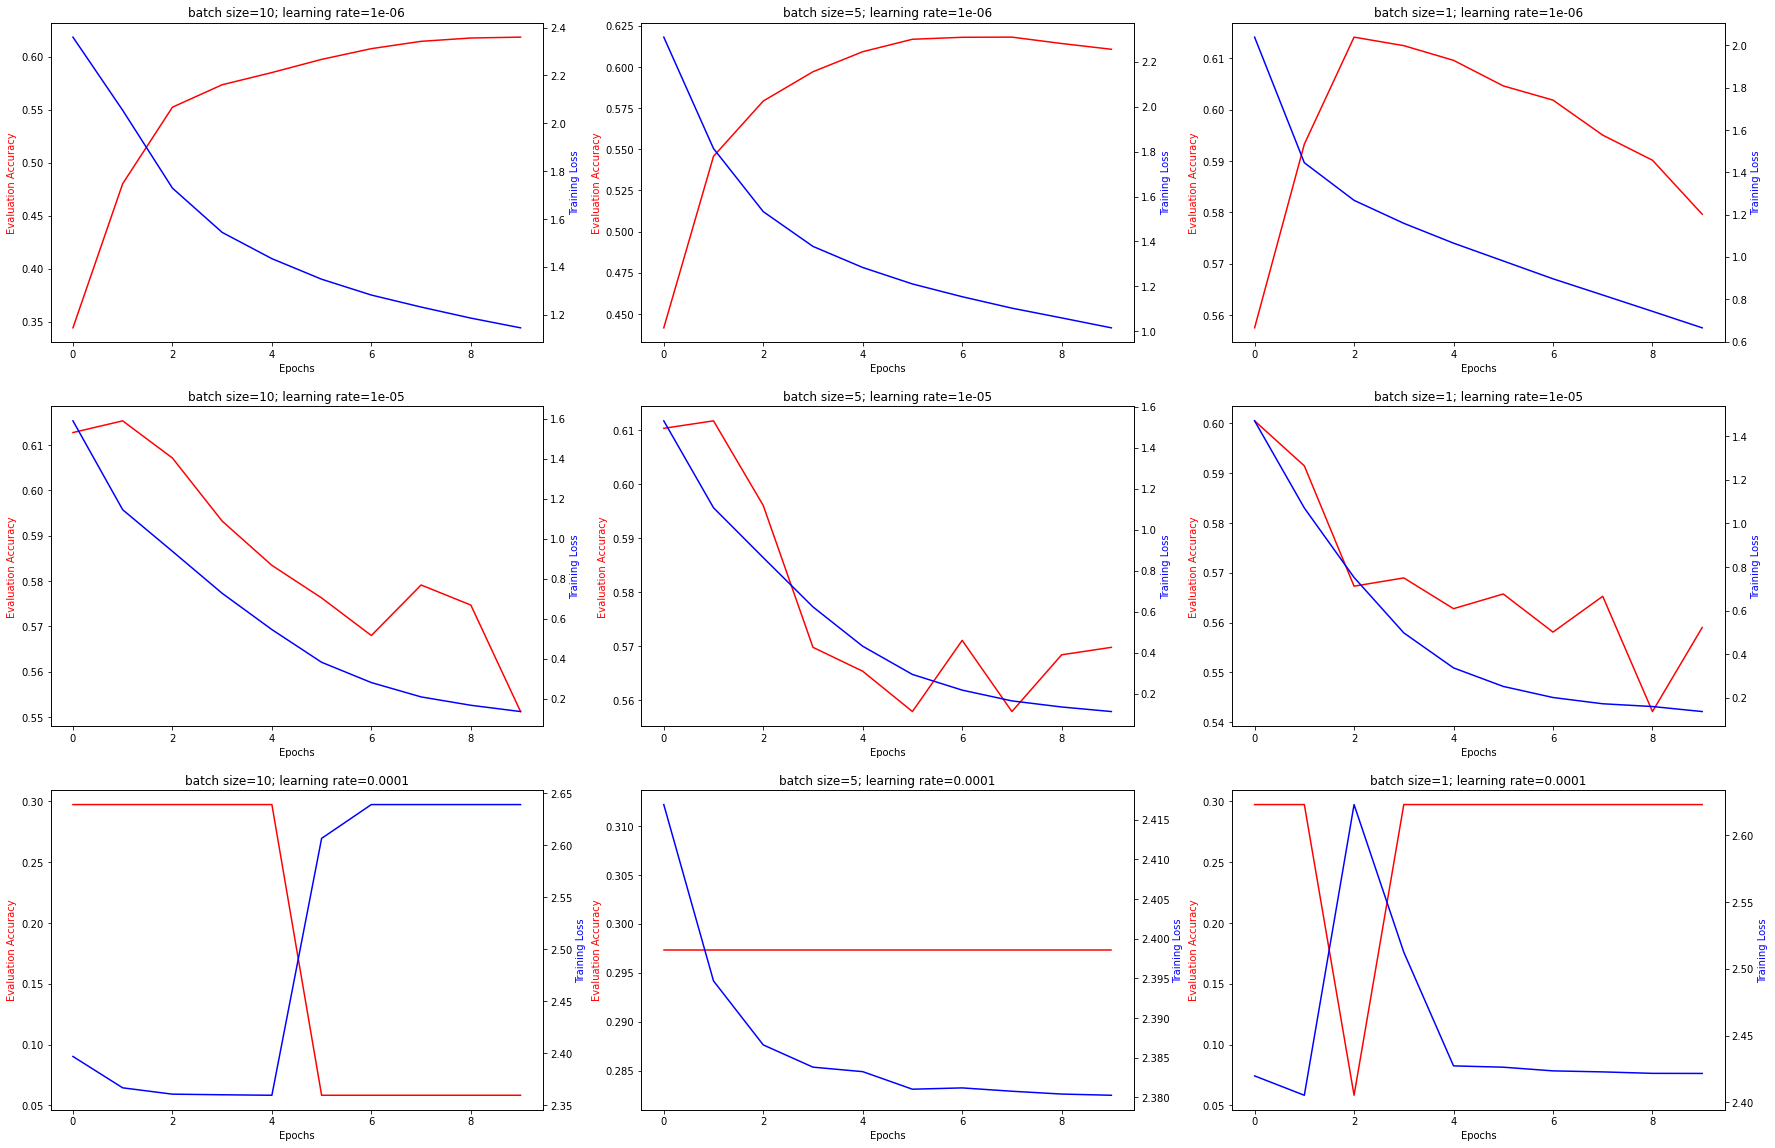

In [21]:
learing_rate = {1: 1e-6, 2: 1e-5, 3: 1e-4}
batch_size = [10,5,1]
epochs = 10

fig, ax = plt.subplots(3,3,figsize=(30,20))
for i, lr in learing_rate.items():
    for j, bs in enumerate(batch_size):

        output_modelfilename = 'batch' + str(bs) + '-lr' + str(i)  

        fname = SAVE_FOLDER + output_modelfilename + '_' + str(epochs) + 'epochs_trainloss.txt'
        with open(fname, 'r') as f:
            train_loss = [float(line.rstrip()) for line in f]
        
            
        fname = SAVE_FOLDER + output_modelfilename + '_' + str(epochs) + 'epochs_evalacc.txt'
        with open(fname, 'r') as f:
            val_acc = [float(line.rstrip()) for line in f]
        
        figtitle = 'batch size=' + str(bs) + '; learning rate=' + str(lr)  
        PlotTwinResults(ax[i-1,j], range(0,len(train_loss)), 
                            [val_acc, train_loss], 
                            'Epochs', ['Evaluation Accuracy', 'Training Loss'], 
                            figtitle)

    